In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import plot_importance
import random
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score
from xgboost.sklearn import XGBClassifier
import operator
import datetime
import sklearn 
from sklearn import linear_model
import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold

In [2]:
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

In [3]:
store = pd.read_csv('store.csv')
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

D:\DevSofeware\Anaconda3\envs\py35\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
test.describe()

,Id,Store,DayOfWeek,Open,Promo,SchoolHoliday
count,41088.000000,41088.000000,41088.000000,41077.000000,41088.000000,41088.000000
mean,20544.500000,555.899533,3.979167,0.854322,0.395833,0.443487
std,11861.228267,320.274496,2.015481,0.352787,0.489035,0.496802
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,10272.750000,279.750000,2.000000,1.000000,0.000000,0.000000
50%,20544.500000,553.500000,4.000000,1.000000,0.000000,0.000000
75%,30816.250000,832.250000,6.000000,1.000000,1.000000,1.000000
max,41088.000000,1115.000000,7.000000,1.000000,1.000000,1.000000


In [5]:
train.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


In [6]:
store.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


- Id :样本号，无参考作用。 
- Store:门店号，1~1115，不编码。 
- Sales :销售额（本项目的预测内容）。 
- Customers:日客流量。预测集不提供，考虑将该特征整合入店铺特征 
- Open:用来表征商店开张或闭店的数据，0表示闭店，1表示开张。
- StateHoliday:法定假期，a表示公共假期，b表示复活节，c表示圣诞节，0则意味着不是假期。
- SchoolHoliday:0,1数值，不需要处理 
- StoreType:使用a,b,c,d四个值来表征四种不同类型的商店，应当独立热码 
- Assortment:表征所售商品品类的等级，a为基础型，b为大型，c为特大型。应当独立热码 
- CompetitionDistance:距离最近竞争商家的距离（m）。连续数值量，考虑放缩 
- CompetitionOpenSinceMonth:距离最近竞争商家的开业时间月份 
- CompetitionOpenSinceyear:距离最近竞争商家的开业时间年份 
- Promo:表征某天是否有促销活动。 Promo2:表征门店是否在持续推出促销活动 
- Promo2Since[Year/Week]: 以年和年中周数表征该门店参与持续促销的时间。日期量，以分割为年和月 
- PromoInterval:'Feb,May,Aug,Nov', 'Jan,Apr,Jul,Oct', 'Mar,Jun,Sept,Dec', nan,四种取值，考虑独立热码为is_interval,is_fman,is_jajo,is_mjsd

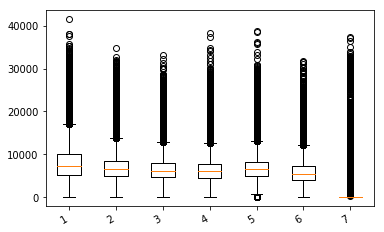

In [7]:
init_explore_fig = plt.figure(figsize=(20,4))
train_weekday = [train[train.DayOfWeek==i].Sales.values for i in [1,2,3,4,5,6,7]]
ief = init_explore_fig.add_subplot(131)
ief.boxplot(train_weekday)
plt.gcf().autofmt_xdate()
plt.show()

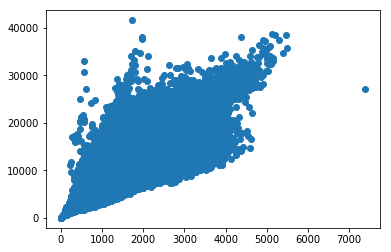

In [8]:
plt.scatter(train.Customers,train.Sales)
plt.show()

数据处理

In [9]:
#test
#Open有11个缺失值，根据Date、StateHoliday、SchoolHoliday所以只是把Open转化int格式
test['Open'] = test['Open'].fillna(1).astype(int)

#处理train
#Open没有缺失值，所以只是把Open转化int格式
train['Open'] = train['Open'].astype(int)

In [10]:
#对日期型数据进行处理
#处理test

#进行Date进行处理，首先转化为时间格式，把Date拆成year，month和day
test['Date']=pd.to_datetime(test['Date'])
test['Year']=test['Date'].dt.year
test['Month']=test['Date'].dt.month
test['Day']=test['Date'].dt.day
#WeekOfYear为Date得出在一年中的第几周
test['WeekOfYear']=test['Date'].dt.weekofyear
#DayOfWeek根据日期来计算，是这一周中
test['DayOfWeek']=test['Date'].dt.dayofweek


#对日期型数据进行处理,train
#进行Date进行处理，首先转化为时间格式，把Date拆成year，month和day
train['Date']=pd.to_datetime(train['Date'])
train['Year']=train['Date'].dt.year
train['Month']=train['Date'].dt.month
train['Day']=train['Date'].dt.day
#WeekOfYear为Date得出在一年中的第几周
train['WeekOfYear']=train['Date'].dt.weekofyear
#DayOfWeek根据日期来计算，是这一周中
train['DayOfWeek']=train['Date'].dt.dayofweek

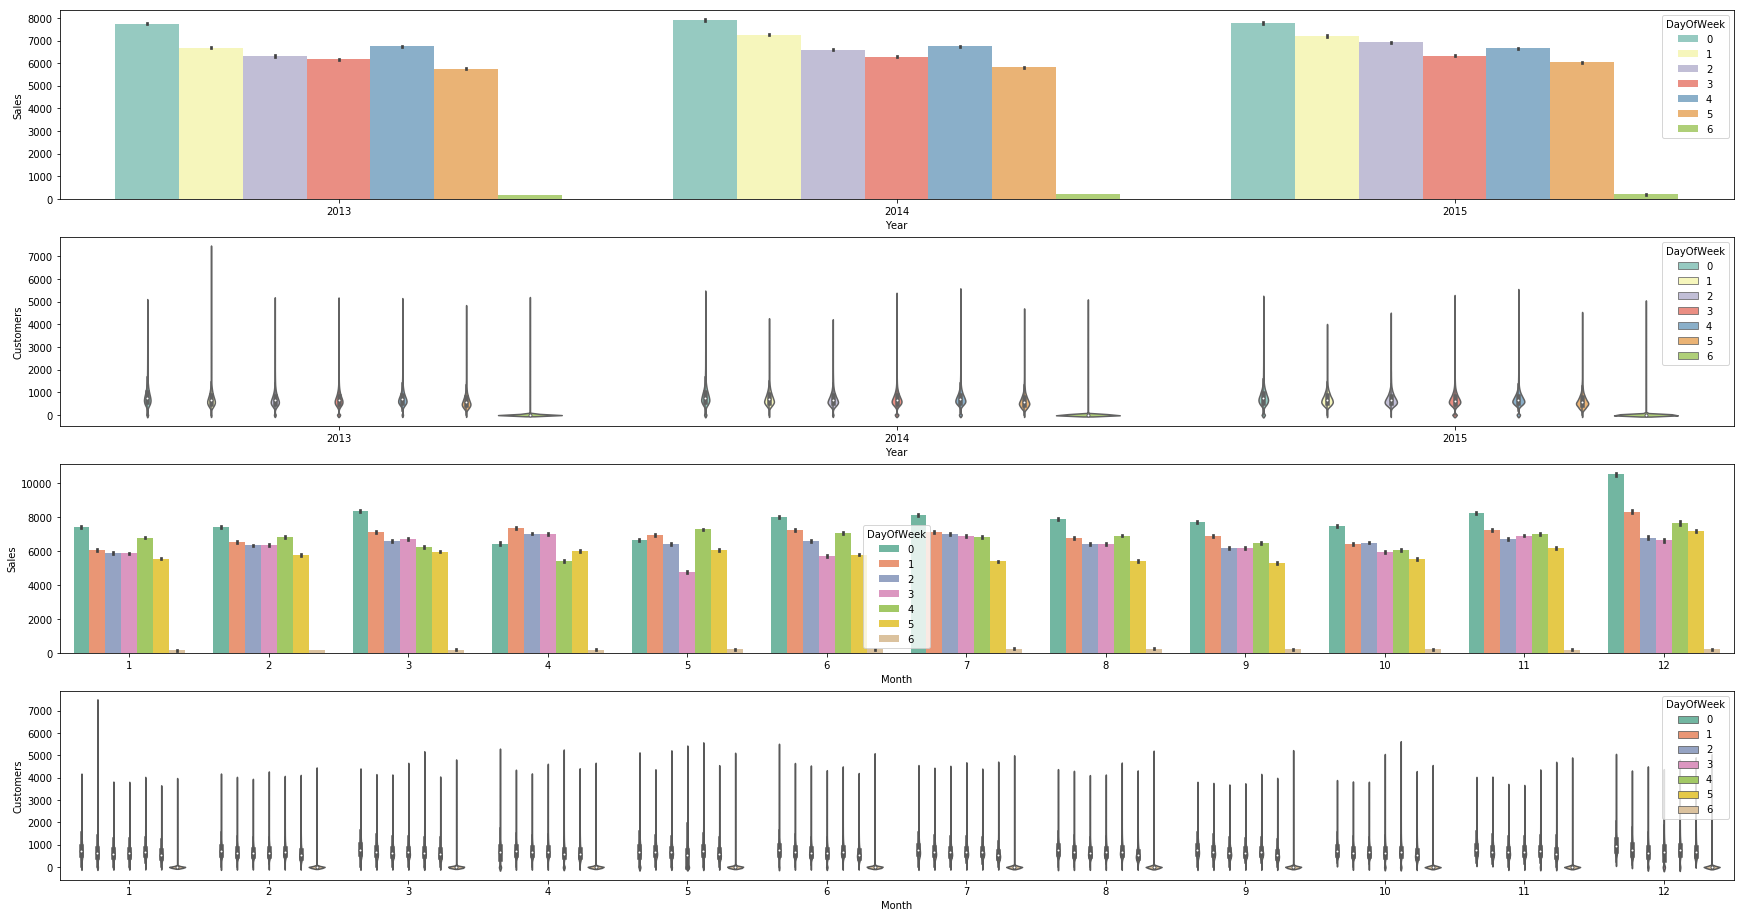

In [11]:
fig, axes = plt.subplots(4,1)
fig.set_size_inches(30, 16)
sns.barplot(x="Year", y="Sales", data=train ,hue="DayOfWeek",ax = axes[0],palette="Set3")
sns.violinplot(x="Year", y="Customers", data=train ,hue="DayOfWeek",ax = axes[1],palette="Set3")
sns.barplot(x="Month", y="Sales", data=train ,hue="DayOfWeek", ax = axes[2],palette="Set2")
sns.violinplot(x="Month", y="Customers", data=train ,hue="DayOfWeek", ax = axes[3],palette="Set2")
plt.show()

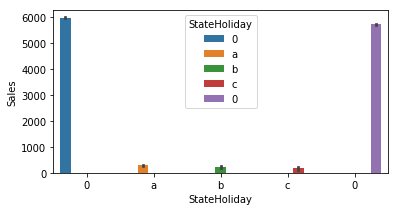

In [12]:
#StateHoliday对特征分析
fig, axes = plt.subplots(1,1)
fig.set_size_inches(6,3)
sns.barplot(x="StateHoliday", y="Sales", data=train ,hue="StateHoliday")
plt.show()
#把StateHoliday取值为a、b、c取值都转化为1，否则为0
train["StateHoliday"] = train["StateHoliday"].map({0: 0, "0": 0, "a": 1, "b": 1, "c": 1})
train['StateHoliday'] = train['StateHoliday'].astype(int)

test["StateHoliday"] = test["StateHoliday"].map({0: 0, "0": 0, "a": 1, "b": 1, "c": 1})
test['StateHoliday'] = test['StateHoliday'].astype(int)

In [13]:
#对SchoolHoliday进行分析
train.SchoolHoliday.value_counts()

0    835488
1    181721
Name: SchoolHoliday, dtype: int64

In [14]:
# 将test数据和store数据合并
test_store = pd.merge(test,store,how='inner',left_on=['Store'],right_on=['Store'])

# 将train数据和store数据合并
train_store = pd.merge(train,store,how='inner',left_on=['Store'],right_on=['Store'])

In [15]:
#处理CompetitionDistance
train_store['CompetitionDistance']=train_store['CompetitionDistance'].fillna(9999)
test_store['CompetitionDistance']=test_store['CompetitionDistance'].fillna(9999)

train_store['CompetitionOpenSinceMonth']=train_store['CompetitionOpenSinceMonth'].fillna(store['CompetitionOpenSinceMonth'].median())
test_store['CompetitionOpenSinceMonth']=test_store['CompetitionOpenSinceMonth'].fillna(store['CompetitionOpenSinceMonth'].median())

train_store['CompetitionMonths']=(train_store['Year']-train_store['CompetitionOpenSinceYear'])*12+(train_store['Month']-train_store['CompetitionOpenSinceMonth'])
test_store['CompetitionMonths']=(test_store['Year']-test_store['CompetitionOpenSinceYear'])*12+(test_store['Month']-test_store['CompetitionOpenSinceMonth'])

train_store.loc[train_store['CompetitionMonths']<0,'CompetitionMonths']=0
test_store.loc[test_store['CompetitionMonths']<0,'CompetitionMonths']=0

train_store['CompetitionMonths']=train_store['CompetitionMonths'].fillna(0)
test_store['CompetitionMonths']=test_store['CompetitionMonths'].fillna(0)

In [16]:
train_store['Promo2SinceWeek']=train_store['Promo2SinceWeek'].fillna(0)
test_store['Promo2SinceWeek']=test_store['Promo2SinceWeek'].fillna(0)

In [17]:

train_store['Promo2weeks']=train_store['Promo2']*((train_store['Year']-train_store['Promo2SinceYear'])*54+(train_store['WeekOfYear']-train_store['Promo2SinceWeek']))

test_store['Promo2weeks']=test_store['Promo2']*((test_store['Year']-test_store['Promo2SinceYear'])*54+(test_store['WeekOfYear']-test_store['Promo2SinceWeek']))

train_store.loc[train_store['Promo2weeks']<0,'Promo2weeks']=0
test_store.loc[test_store['Promo2weeks']<0,'Promo2weeks']=0

train_store['Promo2weeks']=train_store['Promo2weeks'].fillna(0)
test_store['Promo2weeks']=test_store['Promo2weeks'].fillna(0)

In [18]:
#对门店字段StoreType、Assortment根据时间序列进行独热编码
train_store = pd.get_dummies(train_store,columns=['StoreType','Assortment','StateHoliday'])
test_store = pd.get_dummies(test_store,columns=['StoreType','Assortment','StateHoliday'])

In [19]:
train_store["Promo2weeks"] =train_store["Promo2weeks"].astype(int)
train_store["CompetitionMonths"] =train_store["CompetitionMonths"].astype(int)
train_store["StoreType_a"] =train_store["StoreType_a"].astype(int)
train_store["StoreType_b"] =train_store["StoreType_b"].astype(int)
train_store["StoreType_c"] =train_store["StoreType_c"].astype(int)
train_store["StoreType_d"] =train_store["StoreType_d"].astype(int)
train_store["Assortment_a"] =train_store["Assortment_a"].astype(int)
train_store["Assortment_b"] =train_store["Assortment_b"].astype(int)
train_store["Assortment_c"] =train_store["Assortment_c"].astype(int)

test_store["Promo2weeks"] =test_store["Promo2weeks"].astype(int)
test_store["CompetitionMonths"] =test_store["CompetitionMonths"].astype(int)
test_store["StoreType_a"] =test_store["StoreType_a"].astype(int)
test_store["StoreType_b"] =test_store["StoreType_b"].astype(int)
test_store["StoreType_c"] =test_store["StoreType_c"].astype(int)
test_store["StoreType_d"] =test_store["StoreType_d"].astype(int)
test_store["Assortment_a"] =test_store["Assortment_a"].astype(int)
test_store["Assortment_b"] =test_store["Assortment_b"].astype(int)
test_store["Assortment_c"] =test_store["Assortment_c"].astype(int)

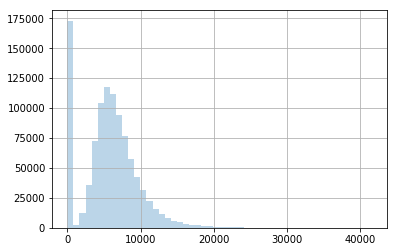

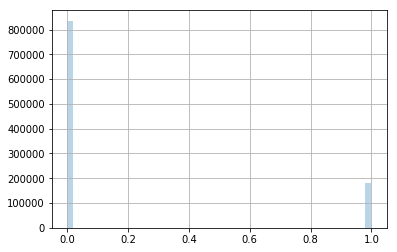

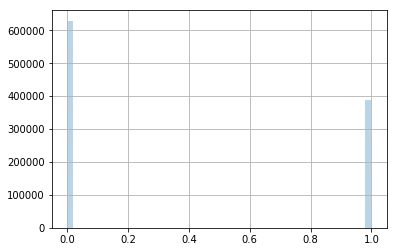

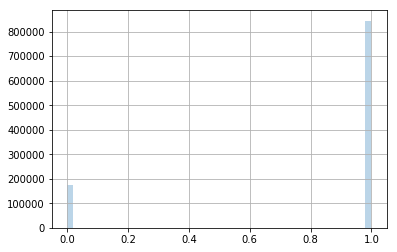

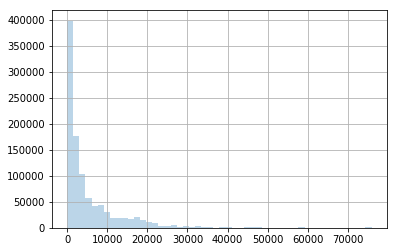

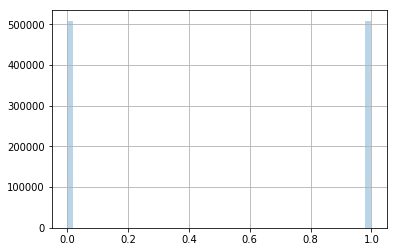

In [20]:
#观察每个变量的分布情况
wide_features = ['Sales','SchoolHoliday','Promo','Open','CompetitionDistance','Promo2']
for feature in wide_features:
    train_store[feature].hist(alpha=0.3,bins=50)
    plt.show()

In [21]:
train_data = train_store[train_store['Open'] == 1]

test_data = test_store[test_store['Open'] == 1]

In [22]:
train_data.to_csv('train_data.csv',index=False)
test_data.to_csv('test_data.csv',index=False)

In [23]:
train_store = pd.read_csv('train_data.csv')
test_store = pd.read_csv('test_data.csv')

In [24]:
test_store.set_index(['Id'],inplace=True)

In [25]:
train = train_store[train_store["Date"]<= '2015-07-10']
val= train_store[train_store["Date"]> '2015-07-10']

columns = ['Store','DayOfWeek','Open','Promo','SchoolHoliday','Year','Month','Day',
'WeekOfYear','CompetitionDistance','Promo2','Assortment_a','Assortment_b',
'Assortment_c','StoreType_a','StoreType_b','StoreType_c','StoreType_d',
'CompetitionMonths','Promo2weeks','StateHoliday_0','StateHoliday_1']

X_train = train[columns]
y_train = train['Sales']
X_val = val[columns]
y_val = val['Sales']


X_test = test_store[columns]

In [26]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35104 entries, 1 to 41088
Data columns (total 22 columns):
Store                  35104 non-null int64
DayOfWeek              35104 non-null int64
Open                   35104 non-null int64
Promo                  35104 non-null int64
SchoolHoliday          35104 non-null int64
Year                   35104 non-null int64
Month                  35104 non-null int64
Day                    35104 non-null int64
WeekOfYear             35104 non-null int64
CompetitionDistance    35104 non-null float64
Promo2                 35104 non-null int64
Assortment_a           35104 non-null int64
Assortment_b           35104 non-null int64
Assortment_c           35104 non-null int64
StoreType_a            35104 non-null int64
StoreType_b            35104 non-null int64
StoreType_c            35104 non-null int64
StoreType_d            35104 non-null int64
CompetitionMonths      35104 non-null int64
Promo2weeks            35104 non-null int64
StateHoli

In [27]:
# 验证数据占训练数据百分比
val_rate = len(y_val)/(len(y_train)+len(y_val))
val_rate

0.023837269893603918

In [28]:
%%time
RF_alpha = RandomForestRegressor()
RF_alpha.fit(X_train,np.log1p(y_train))

Wall time: 54.6 s


In [29]:
%%time
y_pred = RF_alpha.predict(X_val)

Wall time: 218 ms


In [30]:
rf_rmspe = rmspe(y_val,np.exp(y_pred))

In [31]:
rf_rmspe

0.23211046843621916

In [32]:
rf_importance =sorted(zip(X_train, map(lambda x: round(x, 4),RF_alpha.feature_importances_)),key=operator.itemgetter(1), reverse=True)

In [33]:
rf_feature_import = pd.DataFrame(rf_importance)

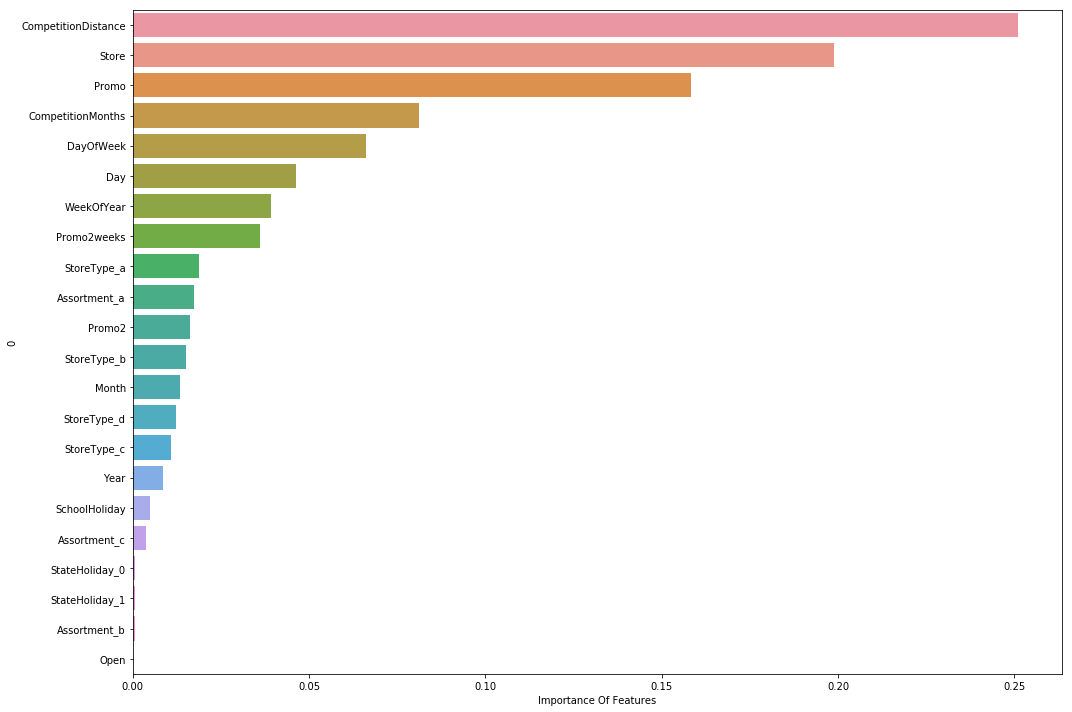

In [34]:
f, ax = plt.subplots(figsize=(15, 10))

sns.barplot(x=rf_feature_import[1], y=rf_feature_import[0], orient='h')
ax.set_xlabel("Importance Of Features")
plt.tight_layout()
plt.show()

In [35]:
%%time
#使用GridSearchCV进行调优
param_grid = {'max_features': [0.6,0.8,1],'max_depth':[6,7,8]}
rf = RandomForestRegressor() 
rf_grid = GridSearchCV(rf, param_grid=param_grid, cv=10, n_jobs=8, refit=True)
rf_grid.fit(X_train,y_train)

Wall time: 9min 51s


In [36]:
%%time
y_pred = rf_grid.predict(X_val)

Wall time: 2.16 s


In [37]:
dtrain = xgb.DMatrix(X_train, np.log1p(y_train))
dvalid = xgb.DMatrix(X_val, np.log1p(y_val))
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.3,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 1000,
          "learning_rate": 0.08
          }
num_trees = 100

In [38]:
%%time
gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)

[0]	train-rmse:7.60727	eval-rmse:7.64911	train-rmspe:0.999592	eval-rmspe:0.999641
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:7.00005	eval-rmse:7.03823	train-rmspe:0.999138	eval-rmspe:0.999205
[2]	train-rmse:6.4416	eval-rmse:6.47954	train-rmspe:0.998395	eval-rmspe:0.998493
[3]	train-rmse:5.9279	eval-rmse:5.96293	train-rmspe:0.997231	eval-rmspe:0.99737
[4]	train-rmse:5.45546	eval-rmse:5.48993	train-rmspe:0.995484	eval-rmspe:0.995688
[5]	train-rmse:5.02078	eval-rmse:5.05334	train-rmspe:0.992968	eval-rmspe:0.993255
[6]	train-rmse:4.62102	eval-rmse:4.6514	train-rmspe:0.989465	eval-rmspe:0.989858
[7]	train-rmse:4.25331	eval-rmse:4.28177	train-rmspe:0.984756	eval-rmspe:0.985282
[8]	train-rmse:3.91531	eval-rmse:3.94364	train-rmspe:0.97859	eval-rmspe:0.979306
[9]	train-rmse:3.60432	eval-rmse:3.63079	train-rmspe:0.970788	eval-rmspe:0.971698
[10]	train-rmse:3.3184	eval-rmse:3.3445

[96]	train-rmse:0.204756	eval-rmse:0.201968	train-rmspe:0.241649	eval-rmspe:0.206978
[97]	train-rmse:0.203681	eval-rmse:0.201106	train-rmspe:0.240953	eval-rmspe:0.206164
[98]	train-rmse:0.202071	eval-rmse:0.199758	train-rmspe:0.239469	eval-rmspe:0.204784
[99]	train-rmse:0.200023	eval-rmse:0.197871	train-rmspe:0.237602	eval-rmspe:0.202966
Wall time: 1min 23s


In [39]:
%%time
dtest = xgb.DMatrix(X_val)
yhat = gbm.predict(dtest)
error = rmspe(y_val,np.exp(y_pred))
print('RMSPE: {:.6f}'.format(error))

RMSPE: nan
Wall time: 686 ms


In [40]:
result_0=pd.DataFrame({"Id": test.query('Open==0')['Id'], 'Sales':0})

In [41]:
dtest = xgb.DMatrix(X_test)
yhat = gbm.predict(dtest)

In [42]:
# Make Submission
result = pd.DataFrame({"Id": test_store.index, 'Sales': np.expm1(yhat)})
result=result.append(result_0)
print(len(result))
result.to_csv("xgboost_submission_100.csv", index=False)

41088


In [43]:
dtrain = xgb.DMatrix(X_train, np.log1p(y_train))
dvalid = xgb.DMatrix(X_val, np.log1p(y_val))
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.3,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 1000,
          "learning_rate": 0.08
          }
num_trees = 300

In [44]:
%%time
gbm_300 = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)

[0]	train-rmse:7.60727	eval-rmse:7.64911	train-rmspe:0.999592	eval-rmspe:0.999641
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:7.00005	eval-rmse:7.03823	train-rmspe:0.999138	eval-rmspe:0.999205
[2]	train-rmse:6.4416	eval-rmse:6.47954	train-rmspe:0.998395	eval-rmspe:0.998493
[3]	train-rmse:5.9279	eval-rmse:5.96293	train-rmspe:0.997231	eval-rmspe:0.99737
[4]	train-rmse:5.45546	eval-rmse:5.48993	train-rmspe:0.995484	eval-rmspe:0.995688
[5]	train-rmse:5.02078	eval-rmse:5.05334	train-rmspe:0.992968	eval-rmspe:0.993255
[6]	train-rmse:4.62102	eval-rmse:4.6514	train-rmspe:0.989465	eval-rmspe:0.989858
[7]	train-rmse:4.25331	eval-rmse:4.28177	train-rmspe:0.984756	eval-rmspe:0.985282
[8]	train-rmse:3.91531	eval-rmse:3.94364	train-rmspe:0.97859	eval-rmspe:0.979306
[9]	train-rmse:3.60432	eval-rmse:3.63079	train-rmspe:0.970788	eval-rmspe:0.971698
[10]	train-rmse:3.3184	eval-rmse:3.3445

[96]	train-rmse:0.204756	eval-rmse:0.201968	train-rmspe:0.241649	eval-rmspe:0.206978
[97]	train-rmse:0.203681	eval-rmse:0.201106	train-rmspe:0.240953	eval-rmspe:0.206164
[98]	train-rmse:0.202071	eval-rmse:0.199758	train-rmspe:0.239469	eval-rmspe:0.204784
[99]	train-rmse:0.200023	eval-rmse:0.197871	train-rmspe:0.237602	eval-rmspe:0.202966
[100]	train-rmse:0.199837	eval-rmse:0.197845	train-rmspe:0.237436	eval-rmspe:0.202937
[101]	train-rmse:0.198853	eval-rmse:0.197195	train-rmspe:0.236163	eval-rmspe:0.202215
[102]	train-rmse:0.197579	eval-rmse:0.196067	train-rmspe:0.234896	eval-rmspe:0.201043
[103]	train-rmse:0.197266	eval-rmse:0.195756	train-rmspe:0.234567	eval-rmspe:0.200657
[104]	train-rmse:0.197063	eval-rmse:0.195591	train-rmspe:0.234411	eval-rmspe:0.200523
[105]	train-rmse:0.196665	eval-rmse:0.195205	train-rmspe:0.234329	eval-rmspe:0.20016
[106]	train-rmse:0.195111	eval-rmse:0.193973	train-rmspe:0.232949	eval-rmspe:0.198927
[107]	train-rmse:0.192649	eval-rmse:0.191516	train-rmspe:0.

[192]	train-rmse:0.146701	eval-rmse:0.151129	train-rmspe:0.183334	eval-rmspe:0.152007
[193]	train-rmse:0.146267	eval-rmse:0.150926	train-rmspe:0.182648	eval-rmspe:0.15171
[194]	train-rmse:0.146027	eval-rmse:0.150758	train-rmspe:0.182444	eval-rmspe:0.151509
[195]	train-rmse:0.145948	eval-rmse:0.150687	train-rmspe:0.18236	eval-rmspe:0.151432
[196]	train-rmse:0.145832	eval-rmse:0.150599	train-rmspe:0.182149	eval-rmspe:0.151338
[197]	train-rmse:0.145762	eval-rmse:0.150505	train-rmspe:0.182093	eval-rmspe:0.151253
[198]	train-rmse:0.145356	eval-rmse:0.150076	train-rmspe:0.181605	eval-rmspe:0.150778
[199]	train-rmse:0.145281	eval-rmse:0.150006	train-rmspe:0.181547	eval-rmspe:0.150688
[200]	train-rmse:0.145217	eval-rmse:0.149935	train-rmspe:0.18147	eval-rmspe:0.150623
[201]	train-rmse:0.144596	eval-rmse:0.14937	train-rmspe:0.180893	eval-rmspe:0.149975
[202]	train-rmse:0.144211	eval-rmse:0.149077	train-rmspe:0.180531	eval-rmspe:0.149589
[203]	train-rmse:0.143645	eval-rmse:0.148504	train-rmspe:0

[288]	train-rmse:0.122983	eval-rmse:0.131597	train-rmspe:0.15772	eval-rmspe:0.130602
[289]	train-rmse:0.122665	eval-rmse:0.131538	train-rmspe:0.157041	eval-rmspe:0.130539
[290]	train-rmse:0.122509	eval-rmse:0.131541	train-rmspe:0.156962	eval-rmspe:0.130536
[291]	train-rmse:0.12222	eval-rmse:0.131433	train-rmspe:0.156759	eval-rmspe:0.13055
[292]	train-rmse:0.122113	eval-rmse:0.131326	train-rmspe:0.156704	eval-rmspe:0.130449
[293]	train-rmse:0.121852	eval-rmse:0.13123	train-rmspe:0.156551	eval-rmspe:0.130377
[294]	train-rmse:0.121712	eval-rmse:0.131118	train-rmspe:0.156361	eval-rmspe:0.130316
[295]	train-rmse:0.121249	eval-rmse:0.130795	train-rmspe:0.155963	eval-rmspe:0.129936
[296]	train-rmse:0.121134	eval-rmse:0.130695	train-rmspe:0.15586	eval-rmspe:0.129861
[297]	train-rmse:0.121013	eval-rmse:0.130579	train-rmspe:0.155704	eval-rmspe:0.129737
[298]	train-rmse:0.120939	eval-rmse:0.130514	train-rmspe:0.15566	eval-rmspe:0.129668
[299]	train-rmse:0.120799	eval-rmse:0.130442	train-rmspe:0.1

In [45]:
%%time
dtest = xgb.DMatrix(X_val)
yhat = gbm_300.predict(dtest)
error = rmspe_xg(y_val,np.exp(y_pred))
print('RMSPE: {:.6f}'.format(error))

RMSPE: nan
Wall time: 281 ms


In [46]:
dtest = xgb.DMatrix(X_test)
yhat = gbm_300.predict(dtest)

In [47]:
# Make Submission
result = pd.DataFrame({"Id": test_store.index, 'Sales': np.expm1(yhat)})
result=result.append(result_0)
print(len(result))
result.to_csv("xgboost_submission_300.csv", index=False)

41088


In [48]:
dtrain = xgb.DMatrix(X_train, np.log1p(y_train))
dvalid = xgb.DMatrix(X_val, np.log1p(y_val))
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.3,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 1000,
          "learning_rate": 0.08
          }
num_trees = 800

In [49]:
%%time
gbm_800 = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)

[0]	train-rmse:7.60727	eval-rmse:7.64911	train-rmspe:0.999592	eval-rmspe:0.999641
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:7.00005	eval-rmse:7.03823	train-rmspe:0.999138	eval-rmspe:0.999205
[2]	train-rmse:6.4416	eval-rmse:6.47954	train-rmspe:0.998395	eval-rmspe:0.998493
[3]	train-rmse:5.9279	eval-rmse:5.96293	train-rmspe:0.997231	eval-rmspe:0.99737
[4]	train-rmse:5.45546	eval-rmse:5.48993	train-rmspe:0.995484	eval-rmspe:0.995688
[5]	train-rmse:5.02078	eval-rmse:5.05334	train-rmspe:0.992968	eval-rmspe:0.993255
[6]	train-rmse:4.62102	eval-rmse:4.6514	train-rmspe:0.989465	eval-rmspe:0.989858
[7]	train-rmse:4.25331	eval-rmse:4.28177	train-rmspe:0.984756	eval-rmspe:0.985282
[8]	train-rmse:3.91531	eval-rmse:3.94364	train-rmspe:0.97859	eval-rmspe:0.979306
[9]	train-rmse:3.60432	eval-rmse:3.63079	train-rmspe:0.970788	eval-rmspe:0.971698
[10]	train-rmse:3.3184	eval-rmse:3.3445

[96]	train-rmse:0.204756	eval-rmse:0.201968	train-rmspe:0.241649	eval-rmspe:0.206978
[97]	train-rmse:0.203681	eval-rmse:0.201106	train-rmspe:0.240953	eval-rmspe:0.206164
[98]	train-rmse:0.202071	eval-rmse:0.199758	train-rmspe:0.239469	eval-rmspe:0.204784
[99]	train-rmse:0.200023	eval-rmse:0.197871	train-rmspe:0.237602	eval-rmspe:0.202966
[100]	train-rmse:0.199837	eval-rmse:0.197845	train-rmspe:0.237436	eval-rmspe:0.202937
[101]	train-rmse:0.198853	eval-rmse:0.197195	train-rmspe:0.236163	eval-rmspe:0.202215
[102]	train-rmse:0.197579	eval-rmse:0.196067	train-rmspe:0.234896	eval-rmspe:0.201043
[103]	train-rmse:0.197266	eval-rmse:0.195756	train-rmspe:0.234567	eval-rmspe:0.200657
[104]	train-rmse:0.197063	eval-rmse:0.195591	train-rmspe:0.234411	eval-rmspe:0.200523
[105]	train-rmse:0.196665	eval-rmse:0.195205	train-rmspe:0.234329	eval-rmspe:0.20016
[106]	train-rmse:0.195111	eval-rmse:0.193973	train-rmspe:0.232949	eval-rmspe:0.198927
[107]	train-rmse:0.192649	eval-rmse:0.191516	train-rmspe:0.

[192]	train-rmse:0.146701	eval-rmse:0.151129	train-rmspe:0.183334	eval-rmspe:0.152007
[193]	train-rmse:0.146267	eval-rmse:0.150926	train-rmspe:0.182648	eval-rmspe:0.15171
[194]	train-rmse:0.146027	eval-rmse:0.150758	train-rmspe:0.182444	eval-rmspe:0.151509
[195]	train-rmse:0.145948	eval-rmse:0.150687	train-rmspe:0.18236	eval-rmspe:0.151432
[196]	train-rmse:0.145832	eval-rmse:0.150599	train-rmspe:0.182149	eval-rmspe:0.151338
[197]	train-rmse:0.145762	eval-rmse:0.150505	train-rmspe:0.182093	eval-rmspe:0.151253
[198]	train-rmse:0.145356	eval-rmse:0.150076	train-rmspe:0.181605	eval-rmspe:0.150778
[199]	train-rmse:0.145281	eval-rmse:0.150006	train-rmspe:0.181547	eval-rmspe:0.150688
[200]	train-rmse:0.145217	eval-rmse:0.149935	train-rmspe:0.18147	eval-rmspe:0.150623
[201]	train-rmse:0.144596	eval-rmse:0.14937	train-rmspe:0.180893	eval-rmspe:0.149975
[202]	train-rmse:0.144211	eval-rmse:0.149077	train-rmspe:0.180531	eval-rmspe:0.149589
[203]	train-rmse:0.143645	eval-rmse:0.148504	train-rmspe:0

[288]	train-rmse:0.122983	eval-rmse:0.131597	train-rmspe:0.15772	eval-rmspe:0.130602
[289]	train-rmse:0.122665	eval-rmse:0.131538	train-rmspe:0.157041	eval-rmspe:0.130539
[290]	train-rmse:0.122509	eval-rmse:0.131541	train-rmspe:0.156962	eval-rmspe:0.130536
[291]	train-rmse:0.12222	eval-rmse:0.131433	train-rmspe:0.156759	eval-rmspe:0.13055
[292]	train-rmse:0.122113	eval-rmse:0.131326	train-rmspe:0.156704	eval-rmspe:0.130449
[293]	train-rmse:0.121852	eval-rmse:0.13123	train-rmspe:0.156551	eval-rmspe:0.130377
[294]	train-rmse:0.121712	eval-rmse:0.131118	train-rmspe:0.156361	eval-rmspe:0.130316
[295]	train-rmse:0.121249	eval-rmse:0.130795	train-rmspe:0.155963	eval-rmspe:0.129936
[296]	train-rmse:0.121134	eval-rmse:0.130695	train-rmspe:0.15586	eval-rmspe:0.129861
[297]	train-rmse:0.121013	eval-rmse:0.130579	train-rmspe:0.155704	eval-rmspe:0.129737
[298]	train-rmse:0.120939	eval-rmse:0.130514	train-rmspe:0.15566	eval-rmspe:0.129668
[299]	train-rmse:0.120799	eval-rmse:0.130442	train-rmspe:0.1

[384]	train-rmse:0.109569	eval-rmse:0.126156	train-rmspe:0.143214	eval-rmspe:0.123201
[385]	train-rmse:0.109459	eval-rmse:0.126062	train-rmspe:0.143135	eval-rmspe:0.123116
[386]	train-rmse:0.109448	eval-rmse:0.126047	train-rmspe:0.143129	eval-rmspe:0.123105
[387]	train-rmse:0.109383	eval-rmse:0.125998	train-rmspe:0.14305	eval-rmspe:0.123068
[388]	train-rmse:0.109303	eval-rmse:0.125933	train-rmspe:0.142988	eval-rmspe:0.123011
[389]	train-rmse:0.109266	eval-rmse:0.125838	train-rmspe:0.142982	eval-rmspe:0.122942
[390]	train-rmse:0.10914	eval-rmse:0.125734	train-rmspe:0.142881	eval-rmspe:0.122828
[391]	train-rmse:0.109031	eval-rmse:0.125656	train-rmspe:0.142786	eval-rmspe:0.122777
[392]	train-rmse:0.108994	eval-rmse:0.125636	train-rmspe:0.142766	eval-rmspe:0.122757
[393]	train-rmse:0.108925	eval-rmse:0.125602	train-rmspe:0.142722	eval-rmspe:0.122721
[394]	train-rmse:0.108802	eval-rmse:0.125672	train-rmspe:0.142627	eval-rmspe:0.122686
[395]	train-rmse:0.1087	eval-rmse:0.125604	train-rmspe:0

[480]	train-rmse:0.100895	eval-rmse:0.12424	train-rmspe:0.1314	eval-rmspe:0.119332
[481]	train-rmse:0.100778	eval-rmse:0.124151	train-rmspe:0.131321	eval-rmspe:0.119236
[482]	train-rmse:0.100686	eval-rmse:0.124101	train-rmspe:0.131256	eval-rmspe:0.119183
[483]	train-rmse:0.100633	eval-rmse:0.124054	train-rmspe:0.131183	eval-rmspe:0.119152
[484]	train-rmse:0.100526	eval-rmse:0.124192	train-rmspe:0.131118	eval-rmspe:0.119075
[485]	train-rmse:0.100508	eval-rmse:0.124139	train-rmspe:0.131066	eval-rmspe:0.119081
[486]	train-rmse:0.100348	eval-rmse:0.124112	train-rmspe:0.13099	eval-rmspe:0.119024
[487]	train-rmse:0.100231	eval-rmse:0.124101	train-rmspe:0.130923	eval-rmspe:0.119005
[488]	train-rmse:0.100116	eval-rmse:0.12402	train-rmspe:0.130838	eval-rmspe:0.118935
[489]	train-rmse:0.100059	eval-rmse:0.123976	train-rmspe:0.130797	eval-rmspe:0.118893
[490]	train-rmse:0.09997	eval-rmse:0.123953	train-rmspe:0.13072	eval-rmspe:0.118879
[491]	train-rmse:0.09994	eval-rmse:0.123926	train-rmspe:0.130

[576]	train-rmse:0.094514	eval-rmse:0.12424	train-rmspe:0.119627	eval-rmspe:0.117289
[577]	train-rmse:0.094472	eval-rmse:0.124244	train-rmspe:0.119598	eval-rmspe:0.117291
[578]	train-rmse:0.094395	eval-rmse:0.124271	train-rmspe:0.119545	eval-rmspe:0.117294
[579]	train-rmse:0.094353	eval-rmse:0.12425	train-rmspe:0.119509	eval-rmspe:0.117274
[580]	train-rmse:0.094269	eval-rmse:0.124277	train-rmspe:0.119465	eval-rmspe:0.117263
[581]	train-rmse:0.094225	eval-rmse:0.124262	train-rmspe:0.119436	eval-rmspe:0.117239
[582]	train-rmse:0.094149	eval-rmse:0.124261	train-rmspe:0.119389	eval-rmspe:0.117221
[583]	train-rmse:0.094087	eval-rmse:0.124225	train-rmspe:0.119346	eval-rmspe:0.117183
[584]	train-rmse:0.094015	eval-rmse:0.124485	train-rmspe:0.119303	eval-rmspe:0.117219
[585]	train-rmse:0.09395	eval-rmse:0.124483	train-rmspe:0.119262	eval-rmspe:0.117206
[586]	train-rmse:0.093882	eval-rmse:0.124466	train-rmspe:0.119211	eval-rmspe:0.117197
[587]	train-rmse:0.093771	eval-rmse:0.124409	train-rmspe:

[672]	train-rmse:0.08923	eval-rmse:0.123596	train-rmspe:0.103012	eval-rmspe:0.115374
[673]	train-rmse:0.089191	eval-rmse:0.123583	train-rmspe:0.102987	eval-rmspe:0.115364
[674]	train-rmse:0.08917	eval-rmse:0.123585	train-rmspe:0.102968	eval-rmspe:0.115364
[675]	train-rmse:0.089094	eval-rmse:0.123551	train-rmspe:0.102844	eval-rmspe:0.115334
[676]	train-rmse:0.089037	eval-rmse:0.123534	train-rmspe:0.102765	eval-rmspe:0.115317
[677]	train-rmse:0.088961	eval-rmse:0.123486	train-rmspe:0.102713	eval-rmspe:0.115285
[678]	train-rmse:0.088906	eval-rmse:0.123472	train-rmspe:0.102684	eval-rmspe:0.115265
[679]	train-rmse:0.088897	eval-rmse:0.123486	train-rmspe:0.102675	eval-rmspe:0.115277
[680]	train-rmse:0.088861	eval-rmse:0.124549	train-rmspe:0.102656	eval-rmspe:0.115422
[681]	train-rmse:0.088781	eval-rmse:0.124577	train-rmspe:0.102598	eval-rmspe:0.115385
[682]	train-rmse:0.088769	eval-rmse:0.12458	train-rmspe:0.102587	eval-rmspe:0.115397
[683]	train-rmse:0.088745	eval-rmse:0.124568	train-rmspe:

[768]	train-rmse:0.085499	eval-rmse:0.123848	train-rmspe:0.098961	eval-rmspe:0.114448
[769]	train-rmse:0.085458	eval-rmse:0.124	train-rmspe:0.098936	eval-rmspe:0.114489
[770]	train-rmse:0.085439	eval-rmse:0.123999	train-rmspe:0.09892	eval-rmspe:0.114488
[771]	train-rmse:0.08538	eval-rmse:0.124004	train-rmspe:0.098892	eval-rmspe:0.114474
[772]	train-rmse:0.085308	eval-rmse:0.124004	train-rmspe:0.098862	eval-rmspe:0.114479
[773]	train-rmse:0.085277	eval-rmse:0.123988	train-rmspe:0.098817	eval-rmspe:0.114461
[774]	train-rmse:0.085248	eval-rmse:0.123982	train-rmspe:0.098813	eval-rmspe:0.114454
[775]	train-rmse:0.085186	eval-rmse:0.123961	train-rmspe:0.09876	eval-rmspe:0.114434
[776]	train-rmse:0.085166	eval-rmse:0.123943	train-rmspe:0.098741	eval-rmspe:0.114414
[777]	train-rmse:0.085138	eval-rmse:0.123904	train-rmspe:0.098692	eval-rmspe:0.114385
[778]	train-rmse:0.08512	eval-rmse:0.123849	train-rmspe:0.098661	eval-rmspe:0.114367
[779]	train-rmse:0.085091	eval-rmse:0.12385	train-rmspe:0.098

In [50]:
%%time
dtest = xgb.DMatrix(X_val)
yhat = gbm_800.predict(dtest)
error = rmspe_xg(y_val,np.exp(y_pred))
print('RMSPE: {:.6f}'.format(error))

RMSPE: nan
Wall time: 842 ms


In [51]:
dtest = xgb.DMatrix(X_test)
yhat = gbm_800.predict(dtest)

In [52]:
# Make Submission
result = pd.DataFrame({"Id": test_store.index, 'Sales': np.expm1(yhat)})
result=result.append(result_0)
print(len(result))
result.to_csv("xgboost_submission_800.csv", index=False)

41088


In [53]:
dtrain = xgb.DMatrix(X_train, np.log1p(y_train))
dvalid = xgb.DMatrix(X_val, np.log1p(y_val))
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.5,
          "max_depth": 15,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 1000,
          "learning_rate": 0.01
          }
num_trees =2000

In [54]:
%%time
gbm_2000 = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)

[0]	train-rmse:8.18485	eval-rmse:8.22831	train-rmspe:0.999831	eval-rmspe:0.99987
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:8.10315	eval-rmse:8.1462	train-rmspe:0.999805	eval-rmspe:0.999845
[2]	train-rmse:8.02229	eval-rmse:8.06534	train-rmspe:0.999777	eval-rmspe:0.999818
[3]	train-rmse:7.94224	eval-rmse:7.98494	train-rmspe:0.999747	eval-rmspe:0.99979
[4]	train-rmse:7.863	eval-rmse:7.90576	train-rmspe:0.999715	eval-rmspe:0.999759
[5]	train-rmse:7.78453	eval-rmse:7.82692	train-rmspe:0.99968	eval-rmspe:0.999726
[6]	train-rmse:7.70685	eval-rmse:7.74887	train-rmspe:0.999643	eval-rmspe:0.999691
[7]	train-rmse:7.62995	eval-rmse:7.67162	train-rmspe:0.999604	eval-rmspe:0.999653
[8]	train-rmse:7.55384	eval-rmse:7.59556	train-rmspe:0.999562	eval-rmspe:0.999613
[9]	train-rmse:7.47846	eval-rmse:7.51993	train-rmspe:0.999517	eval-rmspe:0.99957
[10]	train-rmse:7.40386	eval-rmse:7.44531

[98]	train-rmse:3.07057	eval-rmse:3.0951	train-rmspe:0.950702	eval-rmspe:0.952081
[99]	train-rmse:3.04011	eval-rmse:3.06443	train-rmspe:0.949193	eval-rmspe:0.950602
[100]	train-rmse:3.01002	eval-rmse:3.03414	train-rmspe:0.947641	eval-rmspe:0.949082
[101]	train-rmse:2.98021	eval-rmse:3.00412	train-rmspe:0.946065	eval-rmspe:0.947535
[102]	train-rmse:2.95067	eval-rmse:2.97441	train-rmspe:0.944464	eval-rmspe:0.945965
[103]	train-rmse:2.92147	eval-rmse:2.94499	train-rmspe:0.94282	eval-rmspe:0.944351
[104]	train-rmse:2.89253	eval-rmse:2.91573	train-rmspe:0.941156	eval-rmspe:0.942708
[105]	train-rmse:2.86387	eval-rmse:2.88704	train-rmspe:0.939462	eval-rmspe:0.941054
[106]	train-rmse:2.83552	eval-rmse:2.85859	train-rmspe:0.937731	eval-rmspe:0.939358
[107]	train-rmse:2.80744	eval-rmse:2.83026	train-rmspe:0.935974	eval-rmspe:0.937628
[108]	train-rmse:2.77965	eval-rmse:2.80221	train-rmspe:0.934182	eval-rmspe:0.935862
[109]	train-rmse:2.75213	eval-rmse:2.7745	train-rmspe:0.932366	eval-rmspe:0.9340

[197]	train-rmse:1.15907	eval-rmse:1.17431	train-rmspe:0.674011	eval-rmspe:0.677928
[198]	train-rmse:1.14797	eval-rmse:1.16318	train-rmspe:0.670443	eval-rmspe:0.674355
[199]	train-rmse:1.13695	eval-rmse:1.152	train-rmspe:0.666883	eval-rmspe:0.670759
[200]	train-rmse:1.12605	eval-rmse:1.1411	train-rmspe:0.663322	eval-rmspe:0.667221
[201]	train-rmse:1.11532	eval-rmse:1.13026	train-rmspe:0.659752	eval-rmspe:0.663621
[202]	train-rmse:1.10467	eval-rmse:1.11958	train-rmspe:0.656186	eval-rmspe:0.66004
[203]	train-rmse:1.09411	eval-rmse:1.109	train-rmspe:0.652622	eval-rmspe:0.656472
[204]	train-rmse:1.0837	eval-rmse:1.09861	train-rmspe:0.649034	eval-rmspe:0.652916
[205]	train-rmse:1.07339	eval-rmse:1.08832	train-rmspe:0.645467	eval-rmspe:0.649356
[206]	train-rmse:1.06313	eval-rmse:1.07806	train-rmspe:0.641907	eval-rmspe:0.645799
[207]	train-rmse:1.05297	eval-rmse:1.06791	train-rmspe:0.638355	eval-rmspe:0.642243
[208]	train-rmse:1.0429	eval-rmse:1.05774	train-rmspe:0.634807	eval-rmspe:0.638651


[294]	train-rmse:0.478548	eval-rmse:0.493187	train-rmspe:0.36959	eval-rmspe:0.372735
[295]	train-rmse:0.474611	eval-rmse:0.48927	train-rmspe:0.367209	eval-rmspe:0.370369
[296]	train-rmse:0.470741	eval-rmse:0.485428	train-rmspe:0.364908	eval-rmspe:0.368036
[297]	train-rmse:0.466856	eval-rmse:0.481599	train-rmspe:0.362529	eval-rmspe:0.365705
[298]	train-rmse:0.463095	eval-rmse:0.477963	train-rmspe:0.36014	eval-rmspe:0.36347
[299]	train-rmse:0.45936	eval-rmse:0.473971	train-rmspe:0.357909	eval-rmspe:0.361017
[300]	train-rmse:0.455611	eval-rmse:0.470223	train-rmspe:0.355657	eval-rmspe:0.358723
[301]	train-rmse:0.451841	eval-rmse:0.466443	train-rmspe:0.353426	eval-rmspe:0.356427
[302]	train-rmse:0.448149	eval-rmse:0.46277	train-rmspe:0.351222	eval-rmspe:0.354174
[303]	train-rmse:0.444478	eval-rmse:0.459121	train-rmspe:0.348987	eval-rmspe:0.351924
[304]	train-rmse:0.44086	eval-rmse:0.45555	train-rmspe:0.346725	eval-rmspe:0.349711
[305]	train-rmse:0.437057	eval-rmse:0.451775	train-rmspe:0.344

[390]	train-rmse:0.247495	eval-rmse:0.263831	train-rmspe:0.222609	eval-rmspe:0.223969
[391]	train-rmse:0.246188	eval-rmse:0.262542	train-rmspe:0.221714	eval-rmspe:0.223115
[392]	train-rmse:0.244857	eval-rmse:0.26121	train-rmspe:0.220864	eval-rmspe:0.222222
[393]	train-rmse:0.243701	eval-rmse:0.26006	train-rmspe:0.220163	eval-rmspe:0.221455
[394]	train-rmse:0.242527	eval-rmse:0.25898	train-rmspe:0.219304	eval-rmspe:0.220738
[395]	train-rmse:0.241325	eval-rmse:0.25777	train-rmspe:0.218561	eval-rmspe:0.219935
[396]	train-rmse:0.240134	eval-rmse:0.256675	train-rmspe:0.217545	eval-rmspe:0.219197
[397]	train-rmse:0.239016	eval-rmse:0.255413	train-rmspe:0.216746	eval-rmspe:0.218373
[398]	train-rmse:0.237822	eval-rmse:0.254256	train-rmspe:0.215995	eval-rmspe:0.217603
[399]	train-rmse:0.236522	eval-rmse:0.252963	train-rmspe:0.21512	eval-rmspe:0.216724
[400]	train-rmse:0.235445	eval-rmse:0.252031	train-rmspe:0.21435	eval-rmspe:0.216114
[401]	train-rmse:0.234333	eval-rmse:0.250886	train-rmspe:0.2

[486]	train-rmse:0.17468	eval-rmse:0.192283	train-rmspe:0.17422	eval-rmspe:0.177519
[487]	train-rmse:0.17425	eval-rmse:0.191877	train-rmspe:0.173899	eval-rmspe:0.177272
[488]	train-rmse:0.173814	eval-rmse:0.191403	train-rmspe:0.173624	eval-rmspe:0.17697
[489]	train-rmse:0.173428	eval-rmse:0.191016	train-rmspe:0.173396	eval-rmspe:0.176736
[490]	train-rmse:0.172995	eval-rmse:0.190579	train-rmspe:0.17314	eval-rmspe:0.176447
[491]	train-rmse:0.172671	eval-rmse:0.190345	train-rmspe:0.172972	eval-rmspe:0.176327
[492]	train-rmse:0.172313	eval-rmse:0.189946	train-rmspe:0.172768	eval-rmspe:0.176087
[493]	train-rmse:0.171963	eval-rmse:0.189596	train-rmspe:0.172526	eval-rmspe:0.175891
[494]	train-rmse:0.17162	eval-rmse:0.189268	train-rmspe:0.172256	eval-rmspe:0.175694
[495]	train-rmse:0.171264	eval-rmse:0.18892	train-rmspe:0.172059	eval-rmspe:0.175495
[496]	train-rmse:0.170933	eval-rmse:0.188583	train-rmspe:0.171879	eval-rmspe:0.175293
[497]	train-rmse:0.170508	eval-rmse:0.188155	train-rmspe:0.17

[582]	train-rmse:0.149602	eval-rmse:0.167522	train-rmspe:0.156913	eval-rmspe:0.161976
[583]	train-rmse:0.149191	eval-rmse:0.167146	train-rmspe:0.156549	eval-rmspe:0.161639
[584]	train-rmse:0.148926	eval-rmse:0.166919	train-rmspe:0.156347	eval-rmspe:0.161451
[585]	train-rmse:0.148762	eval-rmse:0.166767	train-rmspe:0.156174	eval-rmspe:0.161356
[586]	train-rmse:0.148631	eval-rmse:0.166638	train-rmspe:0.156096	eval-rmspe:0.161284
[587]	train-rmse:0.148531	eval-rmse:0.166521	train-rmspe:0.156051	eval-rmspe:0.161222
[588]	train-rmse:0.148282	eval-rmse:0.166278	train-rmspe:0.155857	eval-rmspe:0.161014
[589]	train-rmse:0.148045	eval-rmse:0.166062	train-rmspe:0.155687	eval-rmspe:0.16084
[590]	train-rmse:0.147912	eval-rmse:0.166009	train-rmspe:0.155545	eval-rmspe:0.16082
[591]	train-rmse:0.14775	eval-rmse:0.165835	train-rmspe:0.155438	eval-rmspe:0.160692
[592]	train-rmse:0.147542	eval-rmse:0.165638	train-rmspe:0.155293	eval-rmspe:0.16054
[593]	train-rmse:0.14722	eval-rmse:0.165344	train-rmspe:0.

[678]	train-rmse:0.133788	eval-rmse:0.15303	train-rmspe:0.141511	eval-rmspe:0.150543
[679]	train-rmse:0.133633	eval-rmse:0.152881	train-rmspe:0.141373	eval-rmspe:0.150417
[680]	train-rmse:0.133573	eval-rmse:0.152831	train-rmspe:0.141332	eval-rmspe:0.150388
[681]	train-rmse:0.133492	eval-rmse:0.152756	train-rmspe:0.141242	eval-rmspe:0.150343
[682]	train-rmse:0.133428	eval-rmse:0.152723	train-rmspe:0.141171	eval-rmspe:0.15032
[683]	train-rmse:0.133314	eval-rmse:0.152616	train-rmspe:0.141081	eval-rmspe:0.150225
[684]	train-rmse:0.133232	eval-rmse:0.152545	train-rmspe:0.140835	eval-rmspe:0.150182
[685]	train-rmse:0.13305	eval-rmse:0.152392	train-rmspe:0.140628	eval-rmspe:0.150044
[686]	train-rmse:0.132913	eval-rmse:0.152271	train-rmspe:0.140512	eval-rmspe:0.149955
[687]	train-rmse:0.132856	eval-rmse:0.152245	train-rmspe:0.140468	eval-rmspe:0.149942
[688]	train-rmse:0.13275	eval-rmse:0.152234	train-rmspe:0.140344	eval-rmspe:0.149909
[689]	train-rmse:0.132593	eval-rmse:0.152113	train-rmspe:0

[774]	train-rmse:0.121899	eval-rmse:0.143566	train-rmspe:0.127989	eval-rmspe:0.141924
[775]	train-rmse:0.121752	eval-rmse:0.14344	train-rmspe:0.127847	eval-rmspe:0.141802
[776]	train-rmse:0.121552	eval-rmse:0.143304	train-rmspe:0.12762	eval-rmspe:0.141654
[777]	train-rmse:0.12151	eval-rmse:0.143276	train-rmspe:0.127551	eval-rmspe:0.141631
[778]	train-rmse:0.121487	eval-rmse:0.14325	train-rmspe:0.127534	eval-rmspe:0.141614
[779]	train-rmse:0.121362	eval-rmse:0.143142	train-rmspe:0.127424	eval-rmspe:0.141505
[780]	train-rmse:0.12123	eval-rmse:0.14304	train-rmspe:0.127309	eval-rmspe:0.141399
[781]	train-rmse:0.121184	eval-rmse:0.142995	train-rmspe:0.127271	eval-rmspe:0.141362
[782]	train-rmse:0.121125	eval-rmse:0.142967	train-rmspe:0.127204	eval-rmspe:0.141346
[783]	train-rmse:0.121102	eval-rmse:0.142944	train-rmspe:0.127173	eval-rmspe:0.141332
[784]	train-rmse:0.120919	eval-rmse:0.142786	train-rmspe:0.126993	eval-rmspe:0.141172
[785]	train-rmse:0.120854	eval-rmse:0.142767	train-rmspe:0.1

[870]	train-rmse:0.112115	eval-rmse:0.136613	train-rmspe:0.117065	eval-rmspe:0.135006
[871]	train-rmse:0.111959	eval-rmse:0.136502	train-rmspe:0.116845	eval-rmspe:0.134897
[872]	train-rmse:0.111919	eval-rmse:0.136464	train-rmspe:0.116813	eval-rmspe:0.134862
[873]	train-rmse:0.111878	eval-rmse:0.136428	train-rmspe:0.116771	eval-rmspe:0.134829
[874]	train-rmse:0.111832	eval-rmse:0.136413	train-rmspe:0.116726	eval-rmspe:0.134805
[875]	train-rmse:0.111803	eval-rmse:0.136385	train-rmspe:0.1167	eval-rmspe:0.13478
[876]	train-rmse:0.111788	eval-rmse:0.136371	train-rmspe:0.116686	eval-rmspe:0.134768
[877]	train-rmse:0.111754	eval-rmse:0.136341	train-rmspe:0.116659	eval-rmspe:0.134741
[878]	train-rmse:0.111687	eval-rmse:0.136288	train-rmspe:0.116584	eval-rmspe:0.134689
[879]	train-rmse:0.111554	eval-rmse:0.136168	train-rmspe:0.116449	eval-rmspe:0.134559
[880]	train-rmse:0.111479	eval-rmse:0.136149	train-rmspe:0.116359	eval-rmspe:0.134535
[881]	train-rmse:0.111445	eval-rmse:0.136165	train-rmspe:

[966]	train-rmse:0.105595	eval-rmse:0.132078	train-rmspe:0.109691	eval-rmspe:0.130409
[967]	train-rmse:0.105502	eval-rmse:0.13201	train-rmspe:0.109601	eval-rmspe:0.130333
[968]	train-rmse:0.105466	eval-rmse:0.131988	train-rmspe:0.109567	eval-rmspe:0.130307
[969]	train-rmse:0.105415	eval-rmse:0.131962	train-rmspe:0.109512	eval-rmspe:0.130282
[970]	train-rmse:0.10533	eval-rmse:0.131958	train-rmspe:0.109434	eval-rmspe:0.130246
[971]	train-rmse:0.105279	eval-rmse:0.131925	train-rmspe:0.109389	eval-rmspe:0.130207
[972]	train-rmse:0.105258	eval-rmse:0.131913	train-rmspe:0.10937	eval-rmspe:0.130195
[973]	train-rmse:0.105136	eval-rmse:0.131824	train-rmspe:0.109247	eval-rmspe:0.130102
[974]	train-rmse:0.105069	eval-rmse:0.131758	train-rmspe:0.109158	eval-rmspe:0.130038
[975]	train-rmse:0.104967	eval-rmse:0.131716	train-rmspe:0.109058	eval-rmspe:0.129982
[976]	train-rmse:0.104951	eval-rmse:0.131703	train-rmspe:0.109039	eval-rmspe:0.12997
[977]	train-rmse:0.104901	eval-rmse:0.131668	train-rmspe:0

[1062]	train-rmse:0.099543	eval-rmse:0.12827	train-rmspe:0.103235	eval-rmspe:0.126314
[1063]	train-rmse:0.099467	eval-rmse:0.128226	train-rmspe:0.103163	eval-rmspe:0.126272
[1064]	train-rmse:0.099428	eval-rmse:0.128201	train-rmspe:0.10313	eval-rmspe:0.126247
[1065]	train-rmse:0.099374	eval-rmse:0.128179	train-rmspe:0.103084	eval-rmspe:0.126219
[1066]	train-rmse:0.099298	eval-rmse:0.128116	train-rmspe:0.103013	eval-rmspe:0.126159
[1067]	train-rmse:0.099251	eval-rmse:0.128108	train-rmspe:0.102915	eval-rmspe:0.126146
[1068]	train-rmse:0.099199	eval-rmse:0.128074	train-rmspe:0.102865	eval-rmspe:0.126112
[1069]	train-rmse:0.099085	eval-rmse:0.12798	train-rmspe:0.102724	eval-rmspe:0.126017
[1070]	train-rmse:0.099045	eval-rmse:0.127952	train-rmspe:0.102686	eval-rmspe:0.125989
[1071]	train-rmse:0.099036	eval-rmse:0.127943	train-rmspe:0.102676	eval-rmspe:0.12598
[1072]	train-rmse:0.098916	eval-rmse:0.12785	train-rmspe:0.10256	eval-rmspe:0.125886
[1073]	train-rmse:0.098809	eval-rmse:0.127858	tra

[1157]	train-rmse:0.09416	eval-rmse:0.125059	train-rmspe:0.097211	eval-rmspe:0.122919
[1158]	train-rmse:0.09414	eval-rmse:0.125062	train-rmspe:0.097184	eval-rmspe:0.12292
[1159]	train-rmse:0.094076	eval-rmse:0.125026	train-rmspe:0.097085	eval-rmspe:0.122886
[1160]	train-rmse:0.094056	eval-rmse:0.125014	train-rmspe:0.097065	eval-rmspe:0.122874
[1161]	train-rmse:0.093986	eval-rmse:0.124975	train-rmspe:0.097002	eval-rmspe:0.122833
[1162]	train-rmse:0.093921	eval-rmse:0.124956	train-rmspe:0.096945	eval-rmspe:0.12282
[1163]	train-rmse:0.093847	eval-rmse:0.124918	train-rmspe:0.096876	eval-rmspe:0.122776
[1164]	train-rmse:0.093772	eval-rmse:0.124896	train-rmspe:0.096808	eval-rmspe:0.122736
[1165]	train-rmse:0.093761	eval-rmse:0.124889	train-rmspe:0.096795	eval-rmspe:0.122729
[1166]	train-rmse:0.093709	eval-rmse:0.124875	train-rmspe:0.096748	eval-rmspe:0.122699
[1167]	train-rmse:0.093697	eval-rmse:0.124865	train-rmspe:0.09673	eval-rmspe:0.122689
[1168]	train-rmse:0.093576	eval-rmse:0.1248	trai

[1252]	train-rmse:0.089548	eval-rmse:0.123306	train-rmspe:0.092395	eval-rmspe:0.120696
[1253]	train-rmse:0.089511	eval-rmse:0.123307	train-rmspe:0.092363	eval-rmspe:0.120686
[1254]	train-rmse:0.089474	eval-rmse:0.123292	train-rmspe:0.092329	eval-rmspe:0.120672
[1255]	train-rmse:0.089445	eval-rmse:0.123272	train-rmspe:0.0923	eval-rmspe:0.120651
[1256]	train-rmse:0.08939	eval-rmse:0.123238	train-rmspe:0.092247	eval-rmspe:0.120616
[1257]	train-rmse:0.089331	eval-rmse:0.123208	train-rmspe:0.092185	eval-rmspe:0.120578
[1258]	train-rmse:0.089326	eval-rmse:0.123204	train-rmspe:0.092182	eval-rmspe:0.120575
[1259]	train-rmse:0.089272	eval-rmse:0.123166	train-rmspe:0.092126	eval-rmspe:0.120533
[1260]	train-rmse:0.089195	eval-rmse:0.123118	train-rmspe:0.092046	eval-rmspe:0.12048
[1261]	train-rmse:0.089159	eval-rmse:0.123094	train-rmspe:0.092008	eval-rmspe:0.120455
[1262]	train-rmse:0.089107	eval-rmse:0.123064	train-rmspe:0.091957	eval-rmspe:0.120423
[1263]	train-rmse:0.0891	eval-rmse:0.123061	tra

[1347]	train-rmse:0.086015	eval-rmse:0.122085	train-rmspe:0.088781	eval-rmspe:0.119053
[1348]	train-rmse:0.085998	eval-rmse:0.122074	train-rmspe:0.088765	eval-rmspe:0.119041
[1349]	train-rmse:0.085962	eval-rmse:0.122079	train-rmspe:0.088731	eval-rmspe:0.11903
[1350]	train-rmse:0.085882	eval-rmse:0.122029	train-rmspe:0.088649	eval-rmspe:0.118976
[1351]	train-rmse:0.085848	eval-rmse:0.12201	train-rmspe:0.088608	eval-rmspe:0.118956
[1352]	train-rmse:0.085822	eval-rmse:0.121993	train-rmspe:0.088582	eval-rmspe:0.118939
[1353]	train-rmse:0.08581	eval-rmse:0.121989	train-rmspe:0.08857	eval-rmspe:0.118936
[1354]	train-rmse:0.085779	eval-rmse:0.121988	train-rmspe:0.088544	eval-rmspe:0.118934
[1355]	train-rmse:0.085751	eval-rmse:0.121976	train-rmspe:0.088515	eval-rmspe:0.118921
[1356]	train-rmse:0.085723	eval-rmse:0.12197	train-rmspe:0.088485	eval-rmspe:0.118914
[1357]	train-rmse:0.085712	eval-rmse:0.121965	train-rmspe:0.088475	eval-rmspe:0.118909
[1358]	train-rmse:0.085699	eval-rmse:0.121958	tr

[1442]	train-rmse:0.083066	eval-rmse:0.12117	train-rmspe:0.085659	eval-rmspe:0.117785
[1443]	train-rmse:0.083036	eval-rmse:0.121166	train-rmspe:0.085624	eval-rmspe:0.117778
[1444]	train-rmse:0.082965	eval-rmse:0.12113	train-rmspe:0.085531	eval-rmspe:0.117739
[1445]	train-rmse:0.082943	eval-rmse:0.121121	train-rmspe:0.085492	eval-rmspe:0.117728
[1446]	train-rmse:0.082916	eval-rmse:0.121118	train-rmspe:0.085464	eval-rmspe:0.117718
[1447]	train-rmse:0.082872	eval-rmse:0.121107	train-rmspe:0.085419	eval-rmspe:0.117703
[1448]	train-rmse:0.082845	eval-rmse:0.121095	train-rmspe:0.085395	eval-rmspe:0.117691
[1449]	train-rmse:0.082768	eval-rmse:0.12106	train-rmspe:0.085326	eval-rmspe:0.117653
[1450]	train-rmse:0.082738	eval-rmse:0.121054	train-rmspe:0.085285	eval-rmspe:0.117638
[1451]	train-rmse:0.082692	eval-rmse:0.121073	train-rmspe:0.085244	eval-rmspe:0.117629
[1452]	train-rmse:0.082662	eval-rmse:0.121062	train-rmspe:0.085217	eval-rmspe:0.117609
[1453]	train-rmse:0.082654	eval-rmse:0.121059	

[1537]	train-rmse:0.080176	eval-rmse:0.120478	train-rmspe:0.082407	eval-rmspe:0.116625
[1538]	train-rmse:0.080157	eval-rmse:0.120483	train-rmspe:0.08239	eval-rmspe:0.116619
[1539]	train-rmse:0.080132	eval-rmse:0.120473	train-rmspe:0.082366	eval-rmspe:0.116608
[1540]	train-rmse:0.080097	eval-rmse:0.120456	train-rmspe:0.082336	eval-rmspe:0.11659
[1541]	train-rmse:0.080045	eval-rmse:0.120448	train-rmspe:0.08229	eval-rmspe:0.116582
[1542]	train-rmse:0.079996	eval-rmse:0.120421	train-rmspe:0.082222	eval-rmspe:0.116555
[1543]	train-rmse:0.079963	eval-rmse:0.120402	train-rmspe:0.082189	eval-rmspe:0.116535
[1544]	train-rmse:0.079931	eval-rmse:0.120412	train-rmspe:0.082157	eval-rmspe:0.116538
[1545]	train-rmse:0.079897	eval-rmse:0.120407	train-rmspe:0.082125	eval-rmspe:0.116533
[1546]	train-rmse:0.079888	eval-rmse:0.120402	train-rmspe:0.082114	eval-rmspe:0.116531
[1547]	train-rmse:0.079869	eval-rmse:0.12039	train-rmspe:0.082098	eval-rmspe:0.11652
[1548]	train-rmse:0.079855	eval-rmse:0.120384	tr

[1632]	train-rmse:0.077604	eval-rmse:0.120254	train-rmspe:0.079682	eval-rmspe:0.115829
[1633]	train-rmse:0.077585	eval-rmse:0.120295	train-rmspe:0.079669	eval-rmspe:0.115842
[1634]	train-rmse:0.077565	eval-rmse:0.120285	train-rmspe:0.079651	eval-rmspe:0.115831
[1635]	train-rmse:0.077547	eval-rmse:0.120278	train-rmspe:0.079638	eval-rmspe:0.115825
[1636]	train-rmse:0.077522	eval-rmse:0.120267	train-rmspe:0.079609	eval-rmspe:0.115812
[1637]	train-rmse:0.077504	eval-rmse:0.120259	train-rmspe:0.07959	eval-rmspe:0.115804
[1638]	train-rmse:0.077486	eval-rmse:0.120253	train-rmspe:0.079575	eval-rmspe:0.115798
[1639]	train-rmse:0.077474	eval-rmse:0.120249	train-rmspe:0.079563	eval-rmspe:0.115794
[1640]	train-rmse:0.077442	eval-rmse:0.120243	train-rmspe:0.079513	eval-rmspe:0.115789
[1641]	train-rmse:0.077419	eval-rmse:0.12024	train-rmspe:0.079488	eval-rmspe:0.115784
[1642]	train-rmse:0.077392	eval-rmse:0.120231	train-rmspe:0.079461	eval-rmspe:0.115774
[1643]	train-rmse:0.077364	eval-rmse:0.120217

[1727]	train-rmse:0.075078	eval-rmse:0.119887	train-rmspe:0.077098	eval-rmspe:0.115071
[1728]	train-rmse:0.075069	eval-rmse:0.119882	train-rmspe:0.077088	eval-rmspe:0.115067
[1729]	train-rmse:0.075052	eval-rmse:0.119879	train-rmspe:0.077069	eval-rmspe:0.115063
[1730]	train-rmse:0.075017	eval-rmse:0.119856	train-rmspe:0.077037	eval-rmspe:0.115031
[1731]	train-rmse:0.075007	eval-rmse:0.119855	train-rmspe:0.077028	eval-rmspe:0.115031
[1732]	train-rmse:0.074995	eval-rmse:0.119849	train-rmspe:0.077017	eval-rmspe:0.115025
[1733]	train-rmse:0.074984	eval-rmse:0.119845	train-rmspe:0.077008	eval-rmspe:0.115022
[1734]	train-rmse:0.074972	eval-rmse:0.119849	train-rmspe:0.076995	eval-rmspe:0.115016
[1735]	train-rmse:0.07493	eval-rmse:0.119837	train-rmspe:0.076937	eval-rmspe:0.114999
[1736]	train-rmse:0.074912	eval-rmse:0.11983	train-rmspe:0.076918	eval-rmspe:0.114995
[1737]	train-rmse:0.074873	eval-rmse:0.119812	train-rmspe:0.076868	eval-rmspe:0.114973
[1738]	train-rmse:0.074843	eval-rmse:0.119819

[1822]	train-rmse:0.072834	eval-rmse:0.119695	train-rmspe:0.074666	eval-rmspe:0.114385
[1823]	train-rmse:0.0728	eval-rmse:0.119722	train-rmspe:0.074639	eval-rmspe:0.114378
[1824]	train-rmse:0.072777	eval-rmse:0.119714	train-rmspe:0.074613	eval-rmspe:0.114368
[1825]	train-rmse:0.07275	eval-rmse:0.119717	train-rmspe:0.07459	eval-rmspe:0.114371
[1826]	train-rmse:0.072722	eval-rmse:0.119711	train-rmspe:0.074552	eval-rmspe:0.114366
[1827]	train-rmse:0.072693	eval-rmse:0.11973	train-rmspe:0.074523	eval-rmspe:0.114364
[1828]	train-rmse:0.072653	eval-rmse:0.119725	train-rmspe:0.074464	eval-rmspe:0.114355
[1829]	train-rmse:0.07264	eval-rmse:0.119728	train-rmspe:0.074436	eval-rmspe:0.114357
[1830]	train-rmse:0.072625	eval-rmse:0.119726	train-rmspe:0.074405	eval-rmspe:0.114355
[1831]	train-rmse:0.072611	eval-rmse:0.119722	train-rmspe:0.074391	eval-rmspe:0.114351
[1832]	train-rmse:0.0726	eval-rmse:0.119721	train-rmspe:0.07438	eval-rmspe:0.11435
[1833]	train-rmse:0.072567	eval-rmse:0.119726	train-r

[1917]	train-rmse:0.070674	eval-rmse:0.11996	train-rmspe:0.072374	eval-rmspe:0.113962
[1918]	train-rmse:0.070659	eval-rmse:0.119975	train-rmspe:0.072358	eval-rmspe:0.113964
[1919]	train-rmse:0.070645	eval-rmse:0.119977	train-rmspe:0.072345	eval-rmspe:0.113963
[1920]	train-rmse:0.070629	eval-rmse:0.119973	train-rmspe:0.072326	eval-rmspe:0.113959
[1921]	train-rmse:0.070614	eval-rmse:0.119968	train-rmspe:0.07231	eval-rmspe:0.113954
[1922]	train-rmse:0.070583	eval-rmse:0.120006	train-rmspe:0.072282	eval-rmspe:0.113946
[1923]	train-rmse:0.070565	eval-rmse:0.120001	train-rmspe:0.072264	eval-rmspe:0.113941
[1924]	train-rmse:0.070542	eval-rmse:0.120001	train-rmspe:0.072245	eval-rmspe:0.113942
[1925]	train-rmse:0.070526	eval-rmse:0.120002	train-rmspe:0.07223	eval-rmspe:0.113941
[1926]	train-rmse:0.070507	eval-rmse:0.119994	train-rmspe:0.072213	eval-rmspe:0.113933
[1927]	train-rmse:0.070488	eval-rmse:0.119988	train-rmspe:0.072195	eval-rmspe:0.113926
[1928]	train-rmse:0.070476	eval-rmse:0.119993	

In [55]:
%%time
dtest = xgb.DMatrix(X_val)
yhat = gbm_2000.predict(dtest)
error = rmspe_xg(y_val,np.exp(y_pred))
print('RMSPE: {:.6f}'.format(error))

RMSPE: nan
Wall time: 44.6 s


In [56]:
dtest = xgb.DMatrix(X_test)
yhat = gbm_2000.predict(dtest)

In [57]:
# Make Submission
result = pd.DataFrame({"Id": test_store.index, 'Sales': np.expm1(yhat)})
result=result.append(result_0)
print(len(result))
result.to_csv("xgboost_submission_2000.csv", index=False)

41088


In [58]:
dtrain = xgb.DMatrix(X_train, np.log1p(y_train))
dvalid = xgb.DMatrix(X_val, np.log1p(y_val))
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.5,
          "max_depth": 15,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 1000,
          "learning_rate": 0.01
          }
num_trees =30000

In [59]:
%%time
gbm_3000 = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)

[0]	train-rmse:8.18485	eval-rmse:8.22831	train-rmspe:0.999831	eval-rmspe:0.99987
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:8.10315	eval-rmse:8.1462	train-rmspe:0.999805	eval-rmspe:0.999845
[2]	train-rmse:8.02229	eval-rmse:8.06534	train-rmspe:0.999777	eval-rmspe:0.999818
[3]	train-rmse:7.94224	eval-rmse:7.98494	train-rmspe:0.999747	eval-rmspe:0.99979
[4]	train-rmse:7.863	eval-rmse:7.90576	train-rmspe:0.999715	eval-rmspe:0.999759
[5]	train-rmse:7.78453	eval-rmse:7.82692	train-rmspe:0.99968	eval-rmspe:0.999726
[6]	train-rmse:7.70685	eval-rmse:7.74887	train-rmspe:0.999643	eval-rmspe:0.999691
[7]	train-rmse:7.62995	eval-rmse:7.67162	train-rmspe:0.999604	eval-rmspe:0.999653
[8]	train-rmse:7.55384	eval-rmse:7.59556	train-rmspe:0.999562	eval-rmspe:0.999613
[9]	train-rmse:7.47846	eval-rmse:7.51993	train-rmspe:0.999517	eval-rmspe:0.99957
[10]	train-rmse:7.40386	eval-rmse:7.44531

[98]	train-rmse:3.07057	eval-rmse:3.0951	train-rmspe:0.950702	eval-rmspe:0.952081
[99]	train-rmse:3.04011	eval-rmse:3.06443	train-rmspe:0.949193	eval-rmspe:0.950602
[100]	train-rmse:3.01002	eval-rmse:3.03414	train-rmspe:0.947641	eval-rmspe:0.949082
[101]	train-rmse:2.98021	eval-rmse:3.00412	train-rmspe:0.946065	eval-rmspe:0.947535
[102]	train-rmse:2.95067	eval-rmse:2.97441	train-rmspe:0.944464	eval-rmspe:0.945965
[103]	train-rmse:2.92147	eval-rmse:2.94499	train-rmspe:0.94282	eval-rmspe:0.944351
[104]	train-rmse:2.89253	eval-rmse:2.91573	train-rmspe:0.941156	eval-rmspe:0.942708
[105]	train-rmse:2.86387	eval-rmse:2.88704	train-rmspe:0.939462	eval-rmspe:0.941054
[106]	train-rmse:2.83552	eval-rmse:2.85859	train-rmspe:0.937731	eval-rmspe:0.939358
[107]	train-rmse:2.80744	eval-rmse:2.83026	train-rmspe:0.935974	eval-rmspe:0.937628
[108]	train-rmse:2.77965	eval-rmse:2.80221	train-rmspe:0.934182	eval-rmspe:0.935862
[109]	train-rmse:2.75213	eval-rmse:2.7745	train-rmspe:0.932366	eval-rmspe:0.9340

[197]	train-rmse:1.15907	eval-rmse:1.17431	train-rmspe:0.674011	eval-rmspe:0.677928
[198]	train-rmse:1.14797	eval-rmse:1.16318	train-rmspe:0.670443	eval-rmspe:0.674355
[199]	train-rmse:1.13695	eval-rmse:1.152	train-rmspe:0.666883	eval-rmspe:0.670759
[200]	train-rmse:1.12605	eval-rmse:1.1411	train-rmspe:0.663322	eval-rmspe:0.667221
[201]	train-rmse:1.11532	eval-rmse:1.13026	train-rmspe:0.659752	eval-rmspe:0.663621
[202]	train-rmse:1.10467	eval-rmse:1.11958	train-rmspe:0.656186	eval-rmspe:0.66004
[203]	train-rmse:1.09411	eval-rmse:1.109	train-rmspe:0.652622	eval-rmspe:0.656472
[204]	train-rmse:1.0837	eval-rmse:1.09861	train-rmspe:0.649034	eval-rmspe:0.652916
[205]	train-rmse:1.07339	eval-rmse:1.08832	train-rmspe:0.645467	eval-rmspe:0.649356
[206]	train-rmse:1.06313	eval-rmse:1.07806	train-rmspe:0.641907	eval-rmspe:0.645799
[207]	train-rmse:1.05297	eval-rmse:1.06791	train-rmspe:0.638355	eval-rmspe:0.642243
[208]	train-rmse:1.0429	eval-rmse:1.05774	train-rmspe:0.634807	eval-rmspe:0.638651


[294]	train-rmse:0.478548	eval-rmse:0.493187	train-rmspe:0.36959	eval-rmspe:0.372735
[295]	train-rmse:0.474611	eval-rmse:0.48927	train-rmspe:0.367209	eval-rmspe:0.370369
[296]	train-rmse:0.470741	eval-rmse:0.485428	train-rmspe:0.364908	eval-rmspe:0.368036
[297]	train-rmse:0.466856	eval-rmse:0.481599	train-rmspe:0.362529	eval-rmspe:0.365705
[298]	train-rmse:0.463095	eval-rmse:0.477963	train-rmspe:0.36014	eval-rmspe:0.36347
[299]	train-rmse:0.45936	eval-rmse:0.473971	train-rmspe:0.357909	eval-rmspe:0.361017
[300]	train-rmse:0.455611	eval-rmse:0.470223	train-rmspe:0.355657	eval-rmspe:0.358723
[301]	train-rmse:0.451841	eval-rmse:0.466443	train-rmspe:0.353426	eval-rmspe:0.356427
[302]	train-rmse:0.448149	eval-rmse:0.46277	train-rmspe:0.351222	eval-rmspe:0.354174
[303]	train-rmse:0.444478	eval-rmse:0.459121	train-rmspe:0.348987	eval-rmspe:0.351924
[304]	train-rmse:0.44086	eval-rmse:0.45555	train-rmspe:0.346725	eval-rmspe:0.349711
[305]	train-rmse:0.437057	eval-rmse:0.451775	train-rmspe:0.344

[390]	train-rmse:0.247495	eval-rmse:0.263831	train-rmspe:0.222609	eval-rmspe:0.223969
[391]	train-rmse:0.246188	eval-rmse:0.262542	train-rmspe:0.221714	eval-rmspe:0.223115
[392]	train-rmse:0.244857	eval-rmse:0.26121	train-rmspe:0.220864	eval-rmspe:0.222222
[393]	train-rmse:0.243701	eval-rmse:0.26006	train-rmspe:0.220163	eval-rmspe:0.221455
[394]	train-rmse:0.242527	eval-rmse:0.25898	train-rmspe:0.219304	eval-rmspe:0.220738
[395]	train-rmse:0.241325	eval-rmse:0.25777	train-rmspe:0.218561	eval-rmspe:0.219935
[396]	train-rmse:0.240134	eval-rmse:0.256675	train-rmspe:0.217545	eval-rmspe:0.219197
[397]	train-rmse:0.239016	eval-rmse:0.255413	train-rmspe:0.216746	eval-rmspe:0.218373
[398]	train-rmse:0.237822	eval-rmse:0.254256	train-rmspe:0.215995	eval-rmspe:0.217603
[399]	train-rmse:0.236522	eval-rmse:0.252963	train-rmspe:0.21512	eval-rmspe:0.216724
[400]	train-rmse:0.235445	eval-rmse:0.252031	train-rmspe:0.21435	eval-rmspe:0.216114
[401]	train-rmse:0.234333	eval-rmse:0.250886	train-rmspe:0.2

[486]	train-rmse:0.17468	eval-rmse:0.192283	train-rmspe:0.17422	eval-rmspe:0.177519
[487]	train-rmse:0.17425	eval-rmse:0.191877	train-rmspe:0.173899	eval-rmspe:0.177272
[488]	train-rmse:0.173814	eval-rmse:0.191403	train-rmspe:0.173624	eval-rmspe:0.17697
[489]	train-rmse:0.173428	eval-rmse:0.191016	train-rmspe:0.173396	eval-rmspe:0.176736
[490]	train-rmse:0.172995	eval-rmse:0.190579	train-rmspe:0.17314	eval-rmspe:0.176447
[491]	train-rmse:0.172671	eval-rmse:0.190345	train-rmspe:0.172972	eval-rmspe:0.176327
[492]	train-rmse:0.172313	eval-rmse:0.189946	train-rmspe:0.172768	eval-rmspe:0.176087
[493]	train-rmse:0.171963	eval-rmse:0.189596	train-rmspe:0.172526	eval-rmspe:0.175891
[494]	train-rmse:0.17162	eval-rmse:0.189268	train-rmspe:0.172256	eval-rmspe:0.175694
[495]	train-rmse:0.171264	eval-rmse:0.18892	train-rmspe:0.172059	eval-rmspe:0.175495
[496]	train-rmse:0.170933	eval-rmse:0.188583	train-rmspe:0.171879	eval-rmspe:0.175293
[497]	train-rmse:0.170508	eval-rmse:0.188155	train-rmspe:0.17

[582]	train-rmse:0.149602	eval-rmse:0.167522	train-rmspe:0.156913	eval-rmspe:0.161976
[583]	train-rmse:0.149191	eval-rmse:0.167146	train-rmspe:0.156549	eval-rmspe:0.161639
[584]	train-rmse:0.148926	eval-rmse:0.166919	train-rmspe:0.156347	eval-rmspe:0.161451
[585]	train-rmse:0.148762	eval-rmse:0.166767	train-rmspe:0.156174	eval-rmspe:0.161356
[586]	train-rmse:0.148631	eval-rmse:0.166638	train-rmspe:0.156096	eval-rmspe:0.161284
[587]	train-rmse:0.148531	eval-rmse:0.166521	train-rmspe:0.156051	eval-rmspe:0.161222
[588]	train-rmse:0.148282	eval-rmse:0.166278	train-rmspe:0.155857	eval-rmspe:0.161014
[589]	train-rmse:0.148045	eval-rmse:0.166062	train-rmspe:0.155687	eval-rmspe:0.16084
[590]	train-rmse:0.147912	eval-rmse:0.166009	train-rmspe:0.155545	eval-rmspe:0.16082
[591]	train-rmse:0.14775	eval-rmse:0.165835	train-rmspe:0.155438	eval-rmspe:0.160692
[592]	train-rmse:0.147542	eval-rmse:0.165638	train-rmspe:0.155293	eval-rmspe:0.16054
[593]	train-rmse:0.14722	eval-rmse:0.165344	train-rmspe:0.

[678]	train-rmse:0.133788	eval-rmse:0.15303	train-rmspe:0.141511	eval-rmspe:0.150543
[679]	train-rmse:0.133633	eval-rmse:0.152881	train-rmspe:0.141373	eval-rmspe:0.150417
[680]	train-rmse:0.133573	eval-rmse:0.152831	train-rmspe:0.141332	eval-rmspe:0.150388
[681]	train-rmse:0.133492	eval-rmse:0.152756	train-rmspe:0.141242	eval-rmspe:0.150343
[682]	train-rmse:0.133428	eval-rmse:0.152723	train-rmspe:0.141171	eval-rmspe:0.15032
[683]	train-rmse:0.133314	eval-rmse:0.152616	train-rmspe:0.141081	eval-rmspe:0.150225
[684]	train-rmse:0.133232	eval-rmse:0.152545	train-rmspe:0.140835	eval-rmspe:0.150182
[685]	train-rmse:0.13305	eval-rmse:0.152392	train-rmspe:0.140628	eval-rmspe:0.150044
[686]	train-rmse:0.132913	eval-rmse:0.152271	train-rmspe:0.140512	eval-rmspe:0.149955
[687]	train-rmse:0.132856	eval-rmse:0.152245	train-rmspe:0.140468	eval-rmspe:0.149942
[688]	train-rmse:0.13275	eval-rmse:0.152234	train-rmspe:0.140344	eval-rmspe:0.149909
[689]	train-rmse:0.132593	eval-rmse:0.152113	train-rmspe:0

[774]	train-rmse:0.121899	eval-rmse:0.143566	train-rmspe:0.127989	eval-rmspe:0.141924
[775]	train-rmse:0.121752	eval-rmse:0.14344	train-rmspe:0.127847	eval-rmspe:0.141802
[776]	train-rmse:0.121552	eval-rmse:0.143304	train-rmspe:0.12762	eval-rmspe:0.141654
[777]	train-rmse:0.12151	eval-rmse:0.143276	train-rmspe:0.127551	eval-rmspe:0.141631
[778]	train-rmse:0.121487	eval-rmse:0.14325	train-rmspe:0.127534	eval-rmspe:0.141614
[779]	train-rmse:0.121362	eval-rmse:0.143142	train-rmspe:0.127424	eval-rmspe:0.141505
[780]	train-rmse:0.12123	eval-rmse:0.14304	train-rmspe:0.127309	eval-rmspe:0.141399
[781]	train-rmse:0.121184	eval-rmse:0.142995	train-rmspe:0.127271	eval-rmspe:0.141362
[782]	train-rmse:0.121125	eval-rmse:0.142967	train-rmspe:0.127204	eval-rmspe:0.141346
[783]	train-rmse:0.121102	eval-rmse:0.142944	train-rmspe:0.127173	eval-rmspe:0.141332
[784]	train-rmse:0.120919	eval-rmse:0.142786	train-rmspe:0.126993	eval-rmspe:0.141172
[785]	train-rmse:0.120854	eval-rmse:0.142767	train-rmspe:0.1

[870]	train-rmse:0.112115	eval-rmse:0.136613	train-rmspe:0.117065	eval-rmspe:0.135006
[871]	train-rmse:0.111959	eval-rmse:0.136502	train-rmspe:0.116845	eval-rmspe:0.134897
[872]	train-rmse:0.111919	eval-rmse:0.136464	train-rmspe:0.116813	eval-rmspe:0.134862
[873]	train-rmse:0.111878	eval-rmse:0.136428	train-rmspe:0.116771	eval-rmspe:0.134829
[874]	train-rmse:0.111832	eval-rmse:0.136413	train-rmspe:0.116726	eval-rmspe:0.134805
[875]	train-rmse:0.111803	eval-rmse:0.136385	train-rmspe:0.1167	eval-rmspe:0.13478
[876]	train-rmse:0.111788	eval-rmse:0.136371	train-rmspe:0.116686	eval-rmspe:0.134768
[877]	train-rmse:0.111754	eval-rmse:0.136341	train-rmspe:0.116659	eval-rmspe:0.134741
[878]	train-rmse:0.111687	eval-rmse:0.136288	train-rmspe:0.116584	eval-rmspe:0.134689
[879]	train-rmse:0.111554	eval-rmse:0.136168	train-rmspe:0.116449	eval-rmspe:0.134559
[880]	train-rmse:0.111479	eval-rmse:0.136149	train-rmspe:0.116359	eval-rmspe:0.134535
[881]	train-rmse:0.111445	eval-rmse:0.136165	train-rmspe:

[966]	train-rmse:0.105595	eval-rmse:0.132078	train-rmspe:0.109691	eval-rmspe:0.130409
[967]	train-rmse:0.105502	eval-rmse:0.13201	train-rmspe:0.109601	eval-rmspe:0.130333
[968]	train-rmse:0.105466	eval-rmse:0.131988	train-rmspe:0.109567	eval-rmspe:0.130307
[969]	train-rmse:0.105415	eval-rmse:0.131962	train-rmspe:0.109512	eval-rmspe:0.130282
[970]	train-rmse:0.10533	eval-rmse:0.131958	train-rmspe:0.109434	eval-rmspe:0.130246
[971]	train-rmse:0.105279	eval-rmse:0.131925	train-rmspe:0.109389	eval-rmspe:0.130207
[972]	train-rmse:0.105258	eval-rmse:0.131913	train-rmspe:0.10937	eval-rmspe:0.130195
[973]	train-rmse:0.105136	eval-rmse:0.131824	train-rmspe:0.109247	eval-rmspe:0.130102
[974]	train-rmse:0.105069	eval-rmse:0.131758	train-rmspe:0.109158	eval-rmspe:0.130038
[975]	train-rmse:0.104967	eval-rmse:0.131716	train-rmspe:0.109058	eval-rmspe:0.129982
[976]	train-rmse:0.104951	eval-rmse:0.131703	train-rmspe:0.109039	eval-rmspe:0.12997
[977]	train-rmse:0.104901	eval-rmse:0.131668	train-rmspe:0

[1062]	train-rmse:0.099543	eval-rmse:0.12827	train-rmspe:0.103235	eval-rmspe:0.126314
[1063]	train-rmse:0.099467	eval-rmse:0.128226	train-rmspe:0.103163	eval-rmspe:0.126272
[1064]	train-rmse:0.099428	eval-rmse:0.128201	train-rmspe:0.10313	eval-rmspe:0.126247
[1065]	train-rmse:0.099374	eval-rmse:0.128179	train-rmspe:0.103084	eval-rmspe:0.126219
[1066]	train-rmse:0.099298	eval-rmse:0.128116	train-rmspe:0.103013	eval-rmspe:0.126159
[1067]	train-rmse:0.099251	eval-rmse:0.128108	train-rmspe:0.102915	eval-rmspe:0.126146
[1068]	train-rmse:0.099199	eval-rmse:0.128074	train-rmspe:0.102865	eval-rmspe:0.126112
[1069]	train-rmse:0.099085	eval-rmse:0.12798	train-rmspe:0.102724	eval-rmspe:0.126017
[1070]	train-rmse:0.099045	eval-rmse:0.127952	train-rmspe:0.102686	eval-rmspe:0.125989
[1071]	train-rmse:0.099036	eval-rmse:0.127943	train-rmspe:0.102676	eval-rmspe:0.12598
[1072]	train-rmse:0.098916	eval-rmse:0.12785	train-rmspe:0.10256	eval-rmspe:0.125886
[1073]	train-rmse:0.098809	eval-rmse:0.127858	tra

[1157]	train-rmse:0.09416	eval-rmse:0.125059	train-rmspe:0.097211	eval-rmspe:0.122919
[1158]	train-rmse:0.09414	eval-rmse:0.125062	train-rmspe:0.097184	eval-rmspe:0.12292
[1159]	train-rmse:0.094076	eval-rmse:0.125026	train-rmspe:0.097085	eval-rmspe:0.122886
[1160]	train-rmse:0.094056	eval-rmse:0.125014	train-rmspe:0.097065	eval-rmspe:0.122874
[1161]	train-rmse:0.093986	eval-rmse:0.124975	train-rmspe:0.097002	eval-rmspe:0.122833
[1162]	train-rmse:0.093921	eval-rmse:0.124956	train-rmspe:0.096945	eval-rmspe:0.12282
[1163]	train-rmse:0.093847	eval-rmse:0.124918	train-rmspe:0.096876	eval-rmspe:0.122776
[1164]	train-rmse:0.093772	eval-rmse:0.124896	train-rmspe:0.096808	eval-rmspe:0.122736
[1165]	train-rmse:0.093761	eval-rmse:0.124889	train-rmspe:0.096795	eval-rmspe:0.122729
[1166]	train-rmse:0.093709	eval-rmse:0.124875	train-rmspe:0.096748	eval-rmspe:0.122699
[1167]	train-rmse:0.093697	eval-rmse:0.124865	train-rmspe:0.09673	eval-rmspe:0.122689
[1168]	train-rmse:0.093576	eval-rmse:0.1248	trai

[1252]	train-rmse:0.089548	eval-rmse:0.123306	train-rmspe:0.092395	eval-rmspe:0.120696
[1253]	train-rmse:0.089511	eval-rmse:0.123307	train-rmspe:0.092363	eval-rmspe:0.120686
[1254]	train-rmse:0.089474	eval-rmse:0.123292	train-rmspe:0.092329	eval-rmspe:0.120672
[1255]	train-rmse:0.089445	eval-rmse:0.123272	train-rmspe:0.0923	eval-rmspe:0.120651
[1256]	train-rmse:0.08939	eval-rmse:0.123238	train-rmspe:0.092247	eval-rmspe:0.120616
[1257]	train-rmse:0.089331	eval-rmse:0.123208	train-rmspe:0.092185	eval-rmspe:0.120578
[1258]	train-rmse:0.089326	eval-rmse:0.123204	train-rmspe:0.092182	eval-rmspe:0.120575
[1259]	train-rmse:0.089272	eval-rmse:0.123166	train-rmspe:0.092126	eval-rmspe:0.120533
[1260]	train-rmse:0.089195	eval-rmse:0.123118	train-rmspe:0.092046	eval-rmspe:0.12048
[1261]	train-rmse:0.089159	eval-rmse:0.123094	train-rmspe:0.092008	eval-rmspe:0.120455
[1262]	train-rmse:0.089107	eval-rmse:0.123064	train-rmspe:0.091957	eval-rmspe:0.120423
[1263]	train-rmse:0.0891	eval-rmse:0.123061	tra

[1347]	train-rmse:0.086015	eval-rmse:0.122085	train-rmspe:0.088781	eval-rmspe:0.119053
[1348]	train-rmse:0.085998	eval-rmse:0.122074	train-rmspe:0.088765	eval-rmspe:0.119041
[1349]	train-rmse:0.085962	eval-rmse:0.122079	train-rmspe:0.088731	eval-rmspe:0.11903
[1350]	train-rmse:0.085882	eval-rmse:0.122029	train-rmspe:0.088649	eval-rmspe:0.118976
[1351]	train-rmse:0.085848	eval-rmse:0.12201	train-rmspe:0.088608	eval-rmspe:0.118956
[1352]	train-rmse:0.085822	eval-rmse:0.121993	train-rmspe:0.088582	eval-rmspe:0.118939
[1353]	train-rmse:0.08581	eval-rmse:0.121989	train-rmspe:0.08857	eval-rmspe:0.118936
[1354]	train-rmse:0.085779	eval-rmse:0.121988	train-rmspe:0.088544	eval-rmspe:0.118934
[1355]	train-rmse:0.085751	eval-rmse:0.121976	train-rmspe:0.088515	eval-rmspe:0.118921
[1356]	train-rmse:0.085723	eval-rmse:0.12197	train-rmspe:0.088485	eval-rmspe:0.118914
[1357]	train-rmse:0.085712	eval-rmse:0.121965	train-rmspe:0.088475	eval-rmspe:0.118909
[1358]	train-rmse:0.085699	eval-rmse:0.121958	tr

[1442]	train-rmse:0.083066	eval-rmse:0.12117	train-rmspe:0.085659	eval-rmspe:0.117785
[1443]	train-rmse:0.083036	eval-rmse:0.121166	train-rmspe:0.085624	eval-rmspe:0.117778
[1444]	train-rmse:0.082965	eval-rmse:0.12113	train-rmspe:0.085531	eval-rmspe:0.117739
[1445]	train-rmse:0.082943	eval-rmse:0.121121	train-rmspe:0.085492	eval-rmspe:0.117728
[1446]	train-rmse:0.082916	eval-rmse:0.121118	train-rmspe:0.085464	eval-rmspe:0.117718
[1447]	train-rmse:0.082872	eval-rmse:0.121107	train-rmspe:0.085419	eval-rmspe:0.117703
[1448]	train-rmse:0.082845	eval-rmse:0.121095	train-rmspe:0.085395	eval-rmspe:0.117691
[1449]	train-rmse:0.082768	eval-rmse:0.12106	train-rmspe:0.085326	eval-rmspe:0.117653
[1450]	train-rmse:0.082738	eval-rmse:0.121054	train-rmspe:0.085285	eval-rmspe:0.117638
[1451]	train-rmse:0.082692	eval-rmse:0.121073	train-rmspe:0.085244	eval-rmspe:0.117629
[1452]	train-rmse:0.082662	eval-rmse:0.121062	train-rmspe:0.085217	eval-rmspe:0.117609
[1453]	train-rmse:0.082654	eval-rmse:0.121059	

[1537]	train-rmse:0.080176	eval-rmse:0.120478	train-rmspe:0.082407	eval-rmspe:0.116625
[1538]	train-rmse:0.080157	eval-rmse:0.120483	train-rmspe:0.08239	eval-rmspe:0.116619
[1539]	train-rmse:0.080132	eval-rmse:0.120473	train-rmspe:0.082366	eval-rmspe:0.116608
[1540]	train-rmse:0.080097	eval-rmse:0.120456	train-rmspe:0.082336	eval-rmspe:0.11659
[1541]	train-rmse:0.080045	eval-rmse:0.120448	train-rmspe:0.08229	eval-rmspe:0.116582
[1542]	train-rmse:0.079996	eval-rmse:0.120421	train-rmspe:0.082222	eval-rmspe:0.116555
[1543]	train-rmse:0.079963	eval-rmse:0.120402	train-rmspe:0.082189	eval-rmspe:0.116535
[1544]	train-rmse:0.079931	eval-rmse:0.120412	train-rmspe:0.082157	eval-rmspe:0.116538
[1545]	train-rmse:0.079897	eval-rmse:0.120407	train-rmspe:0.082125	eval-rmspe:0.116533
[1546]	train-rmse:0.079888	eval-rmse:0.120402	train-rmspe:0.082114	eval-rmspe:0.116531
[1547]	train-rmse:0.079869	eval-rmse:0.12039	train-rmspe:0.082098	eval-rmspe:0.11652
[1548]	train-rmse:0.079855	eval-rmse:0.120384	tr

[1632]	train-rmse:0.077604	eval-rmse:0.120254	train-rmspe:0.079682	eval-rmspe:0.115829
[1633]	train-rmse:0.077585	eval-rmse:0.120295	train-rmspe:0.079669	eval-rmspe:0.115842
[1634]	train-rmse:0.077565	eval-rmse:0.120285	train-rmspe:0.079651	eval-rmspe:0.115831
[1635]	train-rmse:0.077547	eval-rmse:0.120278	train-rmspe:0.079638	eval-rmspe:0.115825
[1636]	train-rmse:0.077522	eval-rmse:0.120267	train-rmspe:0.079609	eval-rmspe:0.115812
[1637]	train-rmse:0.077504	eval-rmse:0.120259	train-rmspe:0.07959	eval-rmspe:0.115804
[1638]	train-rmse:0.077486	eval-rmse:0.120253	train-rmspe:0.079575	eval-rmspe:0.115798
[1639]	train-rmse:0.077474	eval-rmse:0.120249	train-rmspe:0.079563	eval-rmspe:0.115794
[1640]	train-rmse:0.077442	eval-rmse:0.120243	train-rmspe:0.079513	eval-rmspe:0.115789
[1641]	train-rmse:0.077419	eval-rmse:0.12024	train-rmspe:0.079488	eval-rmspe:0.115784
[1642]	train-rmse:0.077392	eval-rmse:0.120231	train-rmspe:0.079461	eval-rmspe:0.115774
[1643]	train-rmse:0.077364	eval-rmse:0.120217

[1727]	train-rmse:0.075078	eval-rmse:0.119887	train-rmspe:0.077098	eval-rmspe:0.115071
[1728]	train-rmse:0.075069	eval-rmse:0.119882	train-rmspe:0.077088	eval-rmspe:0.115067
[1729]	train-rmse:0.075052	eval-rmse:0.119879	train-rmspe:0.077069	eval-rmspe:0.115063
[1730]	train-rmse:0.075017	eval-rmse:0.119856	train-rmspe:0.077037	eval-rmspe:0.115031
[1731]	train-rmse:0.075007	eval-rmse:0.119855	train-rmspe:0.077028	eval-rmspe:0.115031
[1732]	train-rmse:0.074995	eval-rmse:0.119849	train-rmspe:0.077017	eval-rmspe:0.115025
[1733]	train-rmse:0.074984	eval-rmse:0.119845	train-rmspe:0.077008	eval-rmspe:0.115022
[1734]	train-rmse:0.074972	eval-rmse:0.119849	train-rmspe:0.076995	eval-rmspe:0.115016
[1735]	train-rmse:0.07493	eval-rmse:0.119837	train-rmspe:0.076937	eval-rmspe:0.114999
[1736]	train-rmse:0.074912	eval-rmse:0.11983	train-rmspe:0.076918	eval-rmspe:0.114995
[1737]	train-rmse:0.074873	eval-rmse:0.119812	train-rmspe:0.076868	eval-rmspe:0.114973
[1738]	train-rmse:0.074843	eval-rmse:0.119819

[1822]	train-rmse:0.072834	eval-rmse:0.119695	train-rmspe:0.074666	eval-rmspe:0.114385
[1823]	train-rmse:0.0728	eval-rmse:0.119722	train-rmspe:0.074639	eval-rmspe:0.114378
[1824]	train-rmse:0.072777	eval-rmse:0.119714	train-rmspe:0.074613	eval-rmspe:0.114368
[1825]	train-rmse:0.07275	eval-rmse:0.119717	train-rmspe:0.07459	eval-rmspe:0.114371
[1826]	train-rmse:0.072722	eval-rmse:0.119711	train-rmspe:0.074552	eval-rmspe:0.114366
[1827]	train-rmse:0.072693	eval-rmse:0.11973	train-rmspe:0.074523	eval-rmspe:0.114364
[1828]	train-rmse:0.072653	eval-rmse:0.119725	train-rmspe:0.074464	eval-rmspe:0.114355
[1829]	train-rmse:0.07264	eval-rmse:0.119728	train-rmspe:0.074436	eval-rmspe:0.114357
[1830]	train-rmse:0.072625	eval-rmse:0.119726	train-rmspe:0.074405	eval-rmspe:0.114355
[1831]	train-rmse:0.072611	eval-rmse:0.119722	train-rmspe:0.074391	eval-rmspe:0.114351
[1832]	train-rmse:0.0726	eval-rmse:0.119721	train-rmspe:0.07438	eval-rmspe:0.11435
[1833]	train-rmse:0.072567	eval-rmse:0.119726	train-r

[1917]	train-rmse:0.070674	eval-rmse:0.11996	train-rmspe:0.072374	eval-rmspe:0.113962
[1918]	train-rmse:0.070659	eval-rmse:0.119975	train-rmspe:0.072358	eval-rmspe:0.113964
[1919]	train-rmse:0.070645	eval-rmse:0.119977	train-rmspe:0.072345	eval-rmspe:0.113963
[1920]	train-rmse:0.070629	eval-rmse:0.119973	train-rmspe:0.072326	eval-rmspe:0.113959
[1921]	train-rmse:0.070614	eval-rmse:0.119968	train-rmspe:0.07231	eval-rmspe:0.113954
[1922]	train-rmse:0.070583	eval-rmse:0.120006	train-rmspe:0.072282	eval-rmspe:0.113946
[1923]	train-rmse:0.070565	eval-rmse:0.120001	train-rmspe:0.072264	eval-rmspe:0.113941
[1924]	train-rmse:0.070542	eval-rmse:0.120001	train-rmspe:0.072245	eval-rmspe:0.113942
[1925]	train-rmse:0.070526	eval-rmse:0.120002	train-rmspe:0.07223	eval-rmspe:0.113941
[1926]	train-rmse:0.070507	eval-rmse:0.119994	train-rmspe:0.072213	eval-rmspe:0.113933
[1927]	train-rmse:0.070488	eval-rmse:0.119988	train-rmspe:0.072195	eval-rmspe:0.113926
[1928]	train-rmse:0.070476	eval-rmse:0.119993	

[2012]	train-rmse:0.068722	eval-rmse:0.120025	train-rmspe:0.070255	eval-rmspe:0.11359
[2013]	train-rmse:0.068699	eval-rmse:0.120021	train-rmspe:0.070239	eval-rmspe:0.113587
[2014]	train-rmse:0.068696	eval-rmse:0.12002	train-rmspe:0.070234	eval-rmspe:0.113586
[2015]	train-rmse:0.06865	eval-rmse:0.120004	train-rmspe:0.070191	eval-rmspe:0.113569
[2016]	train-rmse:0.068626	eval-rmse:0.12001	train-rmspe:0.070167	eval-rmspe:0.113567
[2017]	train-rmse:0.068613	eval-rmse:0.120004	train-rmspe:0.070152	eval-rmspe:0.113561
[2018]	train-rmse:0.068578	eval-rmse:0.120038	train-rmspe:0.070125	eval-rmspe:0.11357
[2019]	train-rmse:0.068556	eval-rmse:0.120037	train-rmspe:0.070101	eval-rmspe:0.113566
[2020]	train-rmse:0.068542	eval-rmse:0.120034	train-rmspe:0.070082	eval-rmspe:0.11356
[2021]	train-rmse:0.068526	eval-rmse:0.120031	train-rmspe:0.070063	eval-rmspe:0.113555
[2022]	train-rmse:0.06851	eval-rmse:0.12003	train-rmspe:0.070047	eval-rmspe:0.113553
[2023]	train-rmse:0.068496	eval-rmse:0.120037	train

[2107]	train-rmse:0.066751	eval-rmse:0.12026	train-rmspe:0.068137	eval-rmspe:0.113309
[2108]	train-rmse:0.066728	eval-rmse:0.120305	train-rmspe:0.068113	eval-rmspe:0.113313
[2109]	train-rmse:0.066709	eval-rmse:0.120305	train-rmspe:0.068095	eval-rmspe:0.11331
[2110]	train-rmse:0.066685	eval-rmse:0.120296	train-rmspe:0.068068	eval-rmspe:0.113301
[2111]	train-rmse:0.066672	eval-rmse:0.120293	train-rmspe:0.068056	eval-rmspe:0.113299
[2112]	train-rmse:0.066659	eval-rmse:0.120289	train-rmspe:0.068042	eval-rmspe:0.113294
[2113]	train-rmse:0.066642	eval-rmse:0.120279	train-rmspe:0.068027	eval-rmspe:0.113286
[2114]	train-rmse:0.066606	eval-rmse:0.120281	train-rmspe:0.067984	eval-rmspe:0.113287
[2115]	train-rmse:0.06658	eval-rmse:0.120277	train-rmspe:0.067956	eval-rmspe:0.113283
[2116]	train-rmse:0.066557	eval-rmse:0.12027	train-rmspe:0.067937	eval-rmspe:0.113276
[2117]	train-rmse:0.066547	eval-rmse:0.120268	train-rmspe:0.067921	eval-rmspe:0.113274
[2118]	train-rmse:0.066545	eval-rmse:0.120267	t

[2202]	train-rmse:0.065063	eval-rmse:0.120292	train-rmspe:0.066326	eval-rmspe:0.113052
[2203]	train-rmse:0.065046	eval-rmse:0.120285	train-rmspe:0.066308	eval-rmspe:0.113043
[2204]	train-rmse:0.065033	eval-rmse:0.120282	train-rmspe:0.066293	eval-rmspe:0.113038
[2205]	train-rmse:0.065015	eval-rmse:0.120279	train-rmspe:0.066278	eval-rmspe:0.113033
[2206]	train-rmse:0.065006	eval-rmse:0.120277	train-rmspe:0.06627	eval-rmspe:0.113031
[2207]	train-rmse:0.064988	eval-rmse:0.120295	train-rmspe:0.066252	eval-rmspe:0.11303
[2208]	train-rmse:0.064975	eval-rmse:0.120293	train-rmspe:0.066238	eval-rmspe:0.113028
[2209]	train-rmse:0.064956	eval-rmse:0.120289	train-rmspe:0.066223	eval-rmspe:0.113024
[2210]	train-rmse:0.064938	eval-rmse:0.120341	train-rmspe:0.066207	eval-rmspe:0.113036
[2211]	train-rmse:0.064934	eval-rmse:0.120342	train-rmspe:0.066203	eval-rmspe:0.113037
[2212]	train-rmse:0.064923	eval-rmse:0.120341	train-rmspe:0.066191	eval-rmspe:0.113035
[2213]	train-rmse:0.064918	eval-rmse:0.12034	

[2297]	train-rmse:0.063527	eval-rmse:0.120396	train-rmspe:0.064768	eval-rmspe:0.112883
[2298]	train-rmse:0.063522	eval-rmse:0.120394	train-rmspe:0.064762	eval-rmspe:0.112881
[2299]	train-rmse:0.063498	eval-rmse:0.120393	train-rmspe:0.064739	eval-rmspe:0.112878
[2300]	train-rmse:0.063485	eval-rmse:0.120393	train-rmspe:0.064726	eval-rmspe:0.112879
[2301]	train-rmse:0.063477	eval-rmse:0.120392	train-rmspe:0.064712	eval-rmspe:0.112877
[2302]	train-rmse:0.063455	eval-rmse:0.120389	train-rmspe:0.064689	eval-rmspe:0.112875
[2303]	train-rmse:0.063435	eval-rmse:0.120383	train-rmspe:0.064663	eval-rmspe:0.11287
[2304]	train-rmse:0.063424	eval-rmse:0.12038	train-rmspe:0.064654	eval-rmspe:0.112867
[2305]	train-rmse:0.063417	eval-rmse:0.120377	train-rmspe:0.064648	eval-rmspe:0.112864
[2306]	train-rmse:0.063411	eval-rmse:0.120376	train-rmspe:0.064644	eval-rmspe:0.112863
[2307]	train-rmse:0.063392	eval-rmse:0.12038	train-rmspe:0.064625	eval-rmspe:0.11286
[2308]	train-rmse:0.063382	eval-rmse:0.12038	tr

[2392]	train-rmse:0.062012	eval-rmse:0.120526	train-rmspe:0.063188	eval-rmspe:0.112703
[2393]	train-rmse:0.061997	eval-rmse:0.120524	train-rmspe:0.063163	eval-rmspe:0.112699
[2394]	train-rmse:0.06199	eval-rmse:0.120523	train-rmspe:0.063156	eval-rmspe:0.112696
[2395]	train-rmse:0.061983	eval-rmse:0.120522	train-rmspe:0.06315	eval-rmspe:0.112695
[2396]	train-rmse:0.061971	eval-rmse:0.120521	train-rmspe:0.063136	eval-rmspe:0.112695
[2397]	train-rmse:0.061951	eval-rmse:0.120514	train-rmspe:0.063115	eval-rmspe:0.112691
[2398]	train-rmse:0.061924	eval-rmse:0.120512	train-rmspe:0.063085	eval-rmspe:0.112689
[2399]	train-rmse:0.061902	eval-rmse:0.120507	train-rmspe:0.06306	eval-rmspe:0.112683
[2400]	train-rmse:0.061883	eval-rmse:0.120517	train-rmspe:0.063045	eval-rmspe:0.112682
[2401]	train-rmse:0.061858	eval-rmse:0.120517	train-rmspe:0.063022	eval-rmspe:0.112681
[2402]	train-rmse:0.061844	eval-rmse:0.120514	train-rmspe:0.063008	eval-rmspe:0.112678
[2403]	train-rmse:0.061832	eval-rmse:0.120529	

[2487]	train-rmse:0.060594	eval-rmse:0.120477	train-rmspe:0.061707	eval-rmspe:0.112541
[2488]	train-rmse:0.060572	eval-rmse:0.120474	train-rmspe:0.061679	eval-rmspe:0.112539
[2489]	train-rmse:0.060535	eval-rmse:0.120478	train-rmspe:0.061637	eval-rmspe:0.112534
[2490]	train-rmse:0.060509	eval-rmse:0.120485	train-rmspe:0.061606	eval-rmspe:0.112534
[2491]	train-rmse:0.06049	eval-rmse:0.120479	train-rmspe:0.061585	eval-rmspe:0.11253
[2492]	train-rmse:0.060472	eval-rmse:0.12051	train-rmspe:0.061564	eval-rmspe:0.11254
[2493]	train-rmse:0.060468	eval-rmse:0.120509	train-rmspe:0.061556	eval-rmspe:0.112539
[2494]	train-rmse:0.060444	eval-rmse:0.120504	train-rmspe:0.061535	eval-rmspe:0.112534
[2495]	train-rmse:0.06043	eval-rmse:0.120504	train-rmspe:0.06152	eval-rmspe:0.112534
[2496]	train-rmse:0.060414	eval-rmse:0.120502	train-rmspe:0.061503	eval-rmspe:0.11253
[2497]	train-rmse:0.06039	eval-rmse:0.120506	train-rmspe:0.061474	eval-rmspe:0.11253
[2498]	train-rmse:0.060382	eval-rmse:0.120501	train-

[2582]	train-rmse:0.059267	eval-rmse:0.120588	train-rmspe:0.060269	eval-rmspe:0.112441
[2583]	train-rmse:0.05924	eval-rmse:0.120588	train-rmspe:0.060245	eval-rmspe:0.11244
[2584]	train-rmse:0.059229	eval-rmse:0.12059	train-rmspe:0.060232	eval-rmspe:0.112439
[2585]	train-rmse:0.059214	eval-rmse:0.120588	train-rmspe:0.060218	eval-rmspe:0.112437
[2586]	train-rmse:0.059196	eval-rmse:0.120586	train-rmspe:0.060196	eval-rmspe:0.112434
[2587]	train-rmse:0.059174	eval-rmse:0.12058	train-rmspe:0.060175	eval-rmspe:0.112429
[2588]	train-rmse:0.059155	eval-rmse:0.120576	train-rmspe:0.060151	eval-rmspe:0.112426
[2589]	train-rmse:0.059145	eval-rmse:0.120574	train-rmspe:0.060141	eval-rmspe:0.112426
[2590]	train-rmse:0.059128	eval-rmse:0.120571	train-rmspe:0.060123	eval-rmspe:0.112422
[2591]	train-rmse:0.05911	eval-rmse:0.120569	train-rmspe:0.060106	eval-rmspe:0.112419
[2592]	train-rmse:0.059097	eval-rmse:0.120567	train-rmspe:0.060087	eval-rmspe:0.112418
[2593]	train-rmse:0.059075	eval-rmse:0.120565	tr

[2677]	train-rmse:0.057914	eval-rmse:0.120767	train-rmspe:0.058853	eval-rmspe:0.11235
[2678]	train-rmse:0.057902	eval-rmse:0.120769	train-rmspe:0.058839	eval-rmspe:0.112351
[2679]	train-rmse:0.057882	eval-rmse:0.12081	train-rmspe:0.05882	eval-rmspe:0.112357
[2680]	train-rmse:0.057875	eval-rmse:0.120813	train-rmspe:0.058811	eval-rmspe:0.11236
[2681]	train-rmse:0.057862	eval-rmse:0.120812	train-rmspe:0.058798	eval-rmspe:0.11236
[2682]	train-rmse:0.057854	eval-rmse:0.120811	train-rmspe:0.058792	eval-rmspe:0.112358
[2683]	train-rmse:0.057841	eval-rmse:0.12081	train-rmspe:0.058781	eval-rmspe:0.112356
[2684]	train-rmse:0.057826	eval-rmse:0.120827	train-rmspe:0.058764	eval-rmspe:0.112359
[2685]	train-rmse:0.057814	eval-rmse:0.120827	train-rmspe:0.058751	eval-rmspe:0.112359
[2686]	train-rmse:0.057797	eval-rmse:0.120826	train-rmspe:0.058731	eval-rmspe:0.112359
[2687]	train-rmse:0.057779	eval-rmse:0.120823	train-rmspe:0.058709	eval-rmspe:0.112355
[2688]	train-rmse:0.057758	eval-rmse:0.120825	tra

[2772]	train-rmse:0.05669	eval-rmse:0.12081	train-rmspe:0.057559	eval-rmspe:0.112254
[2773]	train-rmse:0.056674	eval-rmse:0.120829	train-rmspe:0.057544	eval-rmspe:0.11225
[2774]	train-rmse:0.05667	eval-rmse:0.120827	train-rmspe:0.05754	eval-rmspe:0.112248
[2775]	train-rmse:0.056656	eval-rmse:0.120825	train-rmspe:0.057525	eval-rmspe:0.112245
[2776]	train-rmse:0.056636	eval-rmse:0.120824	train-rmspe:0.057502	eval-rmspe:0.112244
[2777]	train-rmse:0.056618	eval-rmse:0.120825	train-rmspe:0.057482	eval-rmspe:0.112244
[2778]	train-rmse:0.056611	eval-rmse:0.120823	train-rmspe:0.057475	eval-rmspe:0.112242
[2779]	train-rmse:0.056604	eval-rmse:0.120823	train-rmspe:0.057469	eval-rmspe:0.112242
[2780]	train-rmse:0.0566	eval-rmse:0.120823	train-rmspe:0.057465	eval-rmspe:0.112242
[2781]	train-rmse:0.056583	eval-rmse:0.120824	train-rmspe:0.057442	eval-rmspe:0.112241
[2782]	train-rmse:0.05657	eval-rmse:0.120823	train-rmspe:0.057429	eval-rmspe:0.112239
[2783]	train-rmse:0.056559	eval-rmse:0.120822	train

[2867]	train-rmse:0.055577	eval-rmse:0.120899	train-rmspe:0.0564	eval-rmspe:0.112166
[2868]	train-rmse:0.055562	eval-rmse:0.120895	train-rmspe:0.05638	eval-rmspe:0.112162
[2869]	train-rmse:0.055554	eval-rmse:0.120896	train-rmspe:0.056368	eval-rmspe:0.112163
[2870]	train-rmse:0.055549	eval-rmse:0.120892	train-rmspe:0.056363	eval-rmspe:0.112162
[2871]	train-rmse:0.055539	eval-rmse:0.12089	train-rmspe:0.056353	eval-rmspe:0.11216
[2872]	train-rmse:0.055513	eval-rmse:0.120904	train-rmspe:0.056329	eval-rmspe:0.112163
[2873]	train-rmse:0.0555	eval-rmse:0.120904	train-rmspe:0.056315	eval-rmspe:0.112163
[2874]	train-rmse:0.055487	eval-rmse:0.120902	train-rmspe:0.056303	eval-rmspe:0.112161
[2875]	train-rmse:0.055469	eval-rmse:0.120913	train-rmspe:0.056285	eval-rmspe:0.112158
[2876]	train-rmse:0.055462	eval-rmse:0.120912	train-rmspe:0.056278	eval-rmspe:0.112158
[2877]	train-rmse:0.055448	eval-rmse:0.120911	train-rmspe:0.056264	eval-rmspe:0.112156
[2878]	train-rmse:0.055434	eval-rmse:0.12091	train

[2962]	train-rmse:0.054441	eval-rmse:0.121027	train-rmspe:0.055209	eval-rmspe:0.112115
[2963]	train-rmse:0.054429	eval-rmse:0.121024	train-rmspe:0.055198	eval-rmspe:0.112112
[2964]	train-rmse:0.054411	eval-rmse:0.121024	train-rmspe:0.055177	eval-rmspe:0.112111
[2965]	train-rmse:0.054389	eval-rmse:0.121022	train-rmspe:0.055156	eval-rmspe:0.112108
[2966]	train-rmse:0.054364	eval-rmse:0.121028	train-rmspe:0.055127	eval-rmspe:0.112107
[2967]	train-rmse:0.054357	eval-rmse:0.121028	train-rmspe:0.05512	eval-rmspe:0.112108
[2968]	train-rmse:0.054346	eval-rmse:0.121027	train-rmspe:0.055109	eval-rmspe:0.112106
[2969]	train-rmse:0.054342	eval-rmse:0.121025	train-rmspe:0.055105	eval-rmspe:0.112104
[2970]	train-rmse:0.054318	eval-rmse:0.121027	train-rmspe:0.055082	eval-rmspe:0.112102
[2971]	train-rmse:0.054313	eval-rmse:0.121027	train-rmspe:0.055075	eval-rmspe:0.112101
[2972]	train-rmse:0.054303	eval-rmse:0.121026	train-rmspe:0.055066	eval-rmspe:0.1121
[2973]	train-rmse:0.054296	eval-rmse:0.121025	

[3057]	train-rmse:0.05336	eval-rmse:0.121159	train-rmspe:0.054089	eval-rmspe:0.112051
[3058]	train-rmse:0.053353	eval-rmse:0.121157	train-rmspe:0.054082	eval-rmspe:0.11205
[3059]	train-rmse:0.053342	eval-rmse:0.121156	train-rmspe:0.054071	eval-rmspe:0.112049
[3060]	train-rmse:0.053327	eval-rmse:0.121155	train-rmspe:0.054055	eval-rmspe:0.112047
[3061]	train-rmse:0.053315	eval-rmse:0.121157	train-rmspe:0.054044	eval-rmspe:0.112046
[3062]	train-rmse:0.05331	eval-rmse:0.121156	train-rmspe:0.054038	eval-rmspe:0.112045
[3063]	train-rmse:0.053301	eval-rmse:0.121159	train-rmspe:0.05403	eval-rmspe:0.112045
[3064]	train-rmse:0.053289	eval-rmse:0.121158	train-rmspe:0.054016	eval-rmspe:0.112045
[3065]	train-rmse:0.053277	eval-rmse:0.121157	train-rmspe:0.054006	eval-rmspe:0.112045
[3066]	train-rmse:0.053274	eval-rmse:0.121156	train-rmspe:0.054003	eval-rmspe:0.112043
[3067]	train-rmse:0.05326	eval-rmse:0.121153	train-rmspe:0.053987	eval-rmspe:0.112042
[3068]	train-rmse:0.053246	eval-rmse:0.121153	tr

[3152]	train-rmse:0.052338	eval-rmse:0.121163	train-rmspe:0.053035	eval-rmspe:0.11201
[3153]	train-rmse:0.05233	eval-rmse:0.12116	train-rmspe:0.053025	eval-rmspe:0.112008
[3154]	train-rmse:0.05232	eval-rmse:0.121159	train-rmspe:0.053015	eval-rmspe:0.112008
[3155]	train-rmse:0.052311	eval-rmse:0.121155	train-rmspe:0.053005	eval-rmspe:0.112004
[3156]	train-rmse:0.052306	eval-rmse:0.121154	train-rmspe:0.053001	eval-rmspe:0.112004
[3157]	train-rmse:0.052293	eval-rmse:0.121153	train-rmspe:0.052989	eval-rmspe:0.112003
[3158]	train-rmse:0.052284	eval-rmse:0.12115	train-rmspe:0.05298	eval-rmspe:0.112001
[3159]	train-rmse:0.052279	eval-rmse:0.121146	train-rmspe:0.052975	eval-rmspe:0.111998
[3160]	train-rmse:0.052266	eval-rmse:0.121146	train-rmspe:0.052961	eval-rmspe:0.111998
[3161]	train-rmse:0.052247	eval-rmse:0.121163	train-rmspe:0.052943	eval-rmspe:0.111996
[3162]	train-rmse:0.052232	eval-rmse:0.121161	train-rmspe:0.052929	eval-rmspe:0.111994
[3163]	train-rmse:0.052223	eval-rmse:0.121162	tra

[3247]	train-rmse:0.051343	eval-rmse:0.121203	train-rmspe:0.051989	eval-rmspe:0.111962
[3248]	train-rmse:0.051332	eval-rmse:0.121201	train-rmspe:0.051977	eval-rmspe:0.111961
[3249]	train-rmse:0.051313	eval-rmse:0.121203	train-rmspe:0.051954	eval-rmspe:0.111961
[3250]	train-rmse:0.051302	eval-rmse:0.121203	train-rmspe:0.051943	eval-rmspe:0.111961
[3251]	train-rmse:0.051287	eval-rmse:0.121209	train-rmspe:0.051925	eval-rmspe:0.111962
[3252]	train-rmse:0.051269	eval-rmse:0.121207	train-rmspe:0.051906	eval-rmspe:0.11196
[3253]	train-rmse:0.051253	eval-rmse:0.121221	train-rmspe:0.051887	eval-rmspe:0.111961
[3254]	train-rmse:0.051229	eval-rmse:0.121222	train-rmspe:0.051859	eval-rmspe:0.111962
[3255]	train-rmse:0.051224	eval-rmse:0.121221	train-rmspe:0.051853	eval-rmspe:0.111962
[3256]	train-rmse:0.051203	eval-rmse:0.121218	train-rmspe:0.051832	eval-rmspe:0.111959
[3257]	train-rmse:0.051188	eval-rmse:0.121218	train-rmspe:0.051816	eval-rmspe:0.111959
[3258]	train-rmse:0.051181	eval-rmse:0.12121

[3342]	train-rmse:0.050318	eval-rmse:0.121283	train-rmspe:0.050907	eval-rmspe:0.11194
[3343]	train-rmse:0.050308	eval-rmse:0.121283	train-rmspe:0.050896	eval-rmspe:0.11194
[3344]	train-rmse:0.0503	eval-rmse:0.121288	train-rmspe:0.050887	eval-rmspe:0.111944
[3345]	train-rmse:0.050291	eval-rmse:0.121287	train-rmspe:0.050878	eval-rmspe:0.111943
[3346]	train-rmse:0.05028	eval-rmse:0.12129	train-rmspe:0.050865	eval-rmspe:0.111944
[3347]	train-rmse:0.050265	eval-rmse:0.121291	train-rmspe:0.050851	eval-rmspe:0.111944
[3348]	train-rmse:0.050249	eval-rmse:0.12129	train-rmspe:0.050833	eval-rmspe:0.111943
[3349]	train-rmse:0.05024	eval-rmse:0.12129	train-rmspe:0.050823	eval-rmspe:0.111943
[3350]	train-rmse:0.050227	eval-rmse:0.121318	train-rmspe:0.050811	eval-rmspe:0.111949
[3351]	train-rmse:0.050217	eval-rmse:0.121318	train-rmspe:0.050803	eval-rmspe:0.11195
[3352]	train-rmse:0.050211	eval-rmse:0.121317	train-rmspe:0.050795	eval-rmspe:0.11195
[3353]	train-rmse:0.050204	eval-rmse:0.121313	train-rm

In [60]:
%%time
dtest = xgb.DMatrix(X_val)
yhat = gbm_3000.predict(dtest)
error = rmspe_xg(y_val,np.exp(y_pred))
print('RMSPE: {:.6f}'.format(error))

RMSPE: nan
Wall time: 3min 35s


In [61]:
dtest = xgb.DMatrix(X_test)
yhat = gbm_3000.predict(dtest)

In [62]:
# Make Submission
result = pd.DataFrame({"Id": test_store.index, 'Sales': np.expm1(yhat)})
result=result.append(result_0)
print(len(result))
result.to_csv("xgboost_submission_3000.csv", index=False)

41088


In [63]:
importance = gbm_3000.get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1))
print (importance)

[('StateHoliday_1', 7303), ('StateHoliday_0', 23979), ('Assortment_b', 29201), ('StoreType_b', 38570), ('Assortment_c', 121724), ('StoreType_c', 166521), ('StoreType_d', 168958), ('Promo2', 217060), ('StoreType_a', 256849), ('Assortment_a', 349748), ('SchoolHoliday', 615971), ('Promo', 687388), ('Year', 1061268), ('CompetitionDistance', 1894087), ('Promo2weeks', 2152425), ('Month', 2155317), ('DayOfWeek', 2706317), ('Store', 2713559), ('WeekOfYear', 2758023), ('CompetitionMonths', 2792863), ('Day', 4601452)]


In [64]:
feature_import = pd.DataFrame(importance)

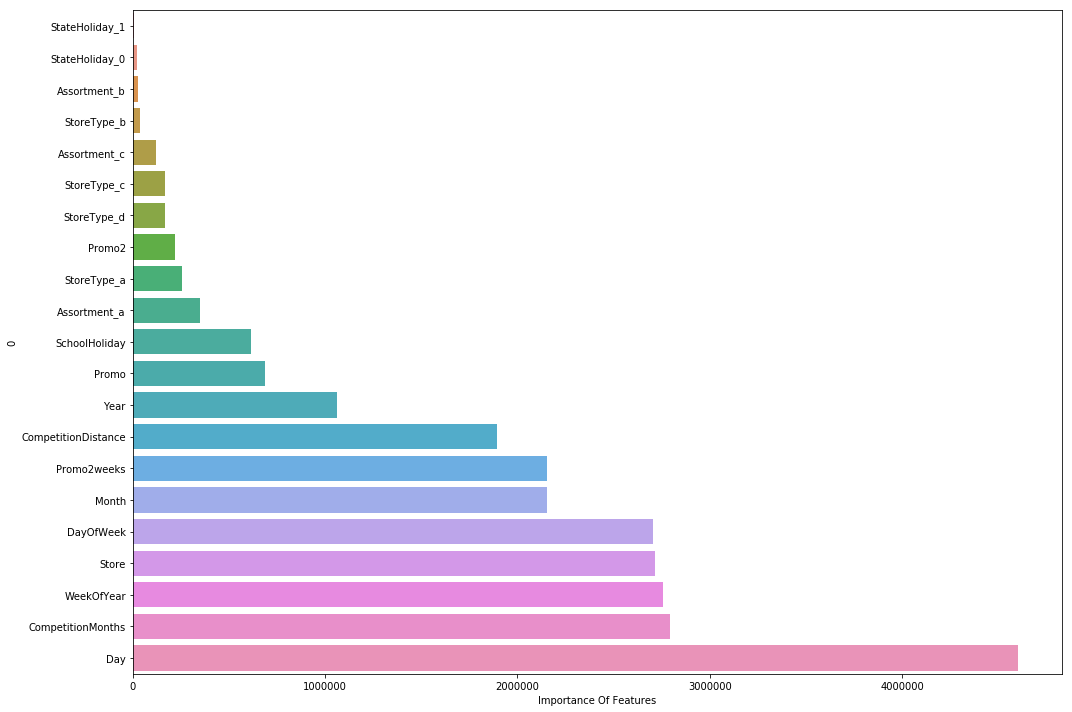

In [65]:
f, ax = plt.subplots(figsize=(15, 10))

sns.barplot(x=feature_import[1], y=feature_import[0], orient='h')
ax.set_xlabel("Importance Of Features")
plt.tight_layout()
plt.show()

In [ ]:
X_all = train_store[columns]
y_all = train_store['Sales']

dtrain = xgb.DMatrix(X_all, np.log1p(y_all))
watchlist = [(dtrain, 'train')]
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.5,
          "max_depth": 15,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 1000,
          "learning_rate": 0.01
          }
num_trees =30000
finall_3000 = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)
dtest = xgb.DMatrix(X_test)
yhat = finall_3000.predict(dtest)
# Make Submission
finall_result = pd.DataFrame({"Id": test_store.index, 'Sales': np.expm1(yhat)})
finall_result=result.append(result_0)
print(len(finall_result))
result.to_csv("fianll_xgboost_submission_3000.csv", index=False)

[0]	train-rmse:8.18588	train-rmspe:0.999832
Multiple eval metrics have been passed: 'train-rmspe' will be used for early stopping.

Will train until train-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:8.1042	train-rmspe:0.999806
[2]	train-rmse:8.02331	train-rmspe:0.999778
[3]	train-rmse:7.94323	train-rmspe:0.999748
[4]	train-rmse:7.86395	train-rmspe:0.999716
[5]	train-rmse:7.78547	train-rmspe:0.999681
[6]	train-rmse:7.70779	train-rmspe:0.999644
[7]	train-rmse:7.63087	train-rmspe:0.999605
[8]	train-rmse:7.55473	train-rmspe:0.999563
[9]	train-rmse:7.47934	train-rmspe:0.999518
[10]	train-rmse:7.40471	train-rmspe:0.999471
[11]	train-rmse:7.33084	train-rmspe:0.99942
[12]	train-rmse:7.25768	train-rmspe:0.999366
[13]	train-rmse:7.18529	train-rmspe:0.999308
[14]	train-rmse:7.1136	train-rmspe:0.999246
[15]	train-rmse:7.04265	train-rmspe:0.999181
[16]	train-rmse:6.9724	train-rmspe:0.999112
[17]	train-rmse:6.90285	train-rmspe:0.999038
[18]	train-rmse:6.83401	train-rmspe:0.99896
[19]	train-r

[179]	train-rmse:1.37958	train-rmspe:0.737583
[180]	train-rmse:1.36625	train-rmspe:0.7341
[181]	train-rmse:1.35305	train-rmspe:0.730597
[182]	train-rmse:1.33997	train-rmspe:0.7271
[183]	train-rmse:1.327	train-rmspe:0.723568
[184]	train-rmse:1.31418	train-rmspe:0.720055
[185]	train-rmse:1.30145	train-rmspe:0.716544
[186]	train-rmse:1.28886	train-rmspe:0.713023
[187]	train-rmse:1.2764	train-rmspe:0.709501
[188]	train-rmse:1.2641	train-rmspe:0.705961
[189]	train-rmse:1.25196	train-rmspe:0.702409
[190]	train-rmse:1.23994	train-rmspe:0.698851
[191]	train-rmse:1.22801	train-rmspe:0.695295
[192]	train-rmse:1.2162	train-rmspe:0.69174
[193]	train-rmse:1.2045	train-rmspe:0.688182
[194]	train-rmse:1.19284	train-rmspe:0.684639
[195]	train-rmse:1.18139	train-rmspe:0.681075
[196]	train-rmse:1.17003	train-rmspe:0.677519
[197]	train-rmse:1.15883	train-rmspe:0.67393
[198]	train-rmse:1.14775	train-rmspe:0.670352
[199]	train-rmse:1.13675	train-rmspe:0.666787
[200]	train-rmse:1.12588	train-rmspe:0.663214


[356]	train-rmse:0.301489	train-rmspe:0.258864
[357]	train-rmse:0.299618	train-rmspe:0.257568
[358]	train-rmse:0.297675	train-rmspe:0.256339
[359]	train-rmse:0.295838	train-rmspe:0.255174
[360]	train-rmse:0.294005	train-rmspe:0.253826
[361]	train-rmse:0.292024	train-rmspe:0.252544
[362]	train-rmse:0.29021	train-rmspe:0.251402
[363]	train-rmse:0.288449	train-rmspe:0.249995
[364]	train-rmse:0.286633	train-rmspe:0.248826
[365]	train-rmse:0.284936	train-rmspe:0.247752
[366]	train-rmse:0.283301	train-rmspe:0.246721
[367]	train-rmse:0.281419	train-rmspe:0.24553
[368]	train-rmse:0.279722	train-rmspe:0.244414
[369]	train-rmse:0.278034	train-rmspe:0.243245
[370]	train-rmse:0.276407	train-rmspe:0.242081
[371]	train-rmse:0.274751	train-rmspe:0.241038
[372]	train-rmse:0.273139	train-rmspe:0.240004
[373]	train-rmse:0.271473	train-rmspe:0.238966
[374]	train-rmse:0.269907	train-rmspe:0.237958
[375]	train-rmse:0.268418	train-rmspe:0.236648
[376]	train-rmse:0.266898	train-rmspe:0.235691
[377]	train-rms

[531]	train-rmse:0.163592	train-rmspe:0.168057
[532]	train-rmse:0.163299	train-rmspe:0.167887
[533]	train-rmse:0.162999	train-rmspe:0.167631
[534]	train-rmse:0.162823	train-rmspe:0.167545
[535]	train-rmse:0.162377	train-rmspe:0.167174
[536]	train-rmse:0.1621	train-rmspe:0.166996
[537]	train-rmse:0.161836	train-rmspe:0.166638
[538]	train-rmse:0.161669	train-rmspe:0.166531
[539]	train-rmse:0.16144	train-rmspe:0.166388
[540]	train-rmse:0.16129	train-rmspe:0.166327
[541]	train-rmse:0.16107	train-rmspe:0.166194
[542]	train-rmse:0.160886	train-rmspe:0.166078
[543]	train-rmse:0.160553	train-rmspe:0.165795
[544]	train-rmse:0.160191	train-rmspe:0.165483
[545]	train-rmse:0.16002	train-rmspe:0.165208
[546]	train-rmse:0.159854	train-rmspe:0.165128
[547]	train-rmse:0.159687	train-rmspe:0.16503
[548]	train-rmse:0.159501	train-rmspe:0.164905
[549]	train-rmse:0.159398	train-rmspe:0.164815
[550]	train-rmse:0.159244	train-rmspe:0.164738
[551]	train-rmse:0.158897	train-rmspe:0.164432
[552]	train-rmse:0.1

[707]	train-rmse:0.13145	train-rmspe:0.136919
[708]	train-rmse:0.131211	train-rmspe:0.136696
[709]	train-rmse:0.131071	train-rmspe:0.136542
[710]	train-rmse:0.131006	train-rmspe:0.13644
[711]	train-rmse:0.130766	train-rmspe:0.136107
[712]	train-rmse:0.130611	train-rmspe:0.135939
[713]	train-rmse:0.130496	train-rmspe:0.135826
[714]	train-rmse:0.130255	train-rmspe:0.135597
[715]	train-rmse:0.130046	train-rmspe:0.135352
[716]	train-rmse:0.13	train-rmspe:0.135307
[717]	train-rmse:0.129919	train-rmspe:0.135163
[718]	train-rmse:0.129872	train-rmspe:0.135117
[719]	train-rmse:0.129739	train-rmspe:0.134993
[720]	train-rmse:0.129712	train-rmspe:0.134973
[721]	train-rmse:0.129645	train-rmspe:0.1349
[722]	train-rmse:0.129551	train-rmspe:0.134824
[723]	train-rmse:0.129443	train-rmspe:0.134698
[724]	train-rmse:0.129251	train-rmspe:0.13453
[725]	train-rmse:0.129129	train-rmspe:0.13439
[726]	train-rmse:0.128866	train-rmspe:0.134112
[727]	train-rmse:0.12862	train-rmspe:0.133804
[728]	train-rmse:0.12859

[883]	train-rmse:0.11118	train-rmspe:0.113918
[884]	train-rmse:0.111107	train-rmspe:0.113834
[885]	train-rmse:0.111087	train-rmspe:0.113804
[886]	train-rmse:0.110971	train-rmspe:0.113693
[887]	train-rmse:0.110922	train-rmspe:0.113637
[888]	train-rmse:0.110767	train-rmspe:0.113485
[889]	train-rmse:0.110688	train-rmspe:0.113405
[890]	train-rmse:0.11055	train-rmspe:0.113259
[891]	train-rmse:0.110491	train-rmspe:0.113198
[892]	train-rmse:0.110415	train-rmspe:0.113122
[893]	train-rmse:0.110376	train-rmspe:0.113037
[894]	train-rmse:0.110359	train-rmspe:0.113009
[895]	train-rmse:0.110279	train-rmspe:0.112888
[896]	train-rmse:0.1102	train-rmspe:0.112813
[897]	train-rmse:0.110084	train-rmspe:0.1127
[898]	train-rmse:0.109992	train-rmspe:0.11262
[899]	train-rmse:0.109863	train-rmspe:0.112459
[900]	train-rmse:0.109785	train-rmspe:0.112365
[901]	train-rmse:0.1097	train-rmspe:0.112286
[902]	train-rmse:0.109582	train-rmspe:0.112167
[903]	train-rmse:0.109529	train-rmspe:0.112108
[904]	train-rmse:0.109

[1057]	train-rmse:0.098357	train-rmspe:0.100082
[1058]	train-rmse:0.09831	train-rmspe:0.100033
[1059]	train-rmse:0.098197	train-rmspe:0.099917
[1060]	train-rmse:0.09818	train-rmspe:0.099893
[1061]	train-rmse:0.098138	train-rmspe:0.099852
[1062]	train-rmse:0.098056	train-rmspe:0.099743
[1063]	train-rmse:0.097944	train-rmspe:0.099628
[1064]	train-rmse:0.09789	train-rmspe:0.099575
[1065]	train-rmse:0.09781	train-rmspe:0.099487
[1066]	train-rmse:0.097762	train-rmspe:0.099431
[1067]	train-rmse:0.097739	train-rmspe:0.099392
[1068]	train-rmse:0.097712	train-rmspe:0.099367
[1069]	train-rmse:0.097657	train-rmspe:0.09931
[1070]	train-rmse:0.097548	train-rmspe:0.099199
[1071]	train-rmse:0.097471	train-rmspe:0.099107
[1072]	train-rmse:0.09742	train-rmspe:0.099057
[1073]	train-rmse:0.097385	train-rmspe:0.099018
[1074]	train-rmse:0.097335	train-rmspe:0.098963
[1075]	train-rmse:0.097248	train-rmspe:0.098876
[1076]	train-rmse:0.097205	train-rmspe:0.098807
[1077]	train-rmse:0.097155	train-rmspe:0.09874

[1229]	train-rmse:0.089029	train-rmspe:0.090276
[1230]	train-rmse:0.088999	train-rmspe:0.090249
[1231]	train-rmse:0.088916	train-rmspe:0.090174
[1232]	train-rmse:0.088836	train-rmspe:0.090095
[1233]	train-rmse:0.088823	train-rmspe:0.090082
[1234]	train-rmse:0.088814	train-rmspe:0.09007
[1235]	train-rmse:0.088805	train-rmspe:0.09006
[1236]	train-rmse:0.088769	train-rmspe:0.090025
[1237]	train-rmse:0.088688	train-rmspe:0.089934
[1238]	train-rmse:0.088629	train-rmspe:0.089872
[1239]	train-rmse:0.088576	train-rmspe:0.089817
[1240]	train-rmse:0.088507	train-rmspe:0.089736
[1241]	train-rmse:0.088471	train-rmspe:0.089705
[1242]	train-rmse:0.088387	train-rmspe:0.089596
[1243]	train-rmse:0.088353	train-rmspe:0.089564
[1244]	train-rmse:0.088282	train-rmspe:0.089488
[1245]	train-rmse:0.088247	train-rmspe:0.089452
[1246]	train-rmse:0.088237	train-rmspe:0.089441
[1247]	train-rmse:0.088229	train-rmspe:0.089433
[1248]	train-rmse:0.088151	train-rmspe:0.089352
[1249]	train-rmse:0.088108	train-rmspe:0.0

[1401]	train-rmse:0.082181	train-rmspe:0.083443
[1402]	train-rmse:0.082167	train-rmspe:0.083429
[1403]	train-rmse:0.082141	train-rmspe:0.083405
[1404]	train-rmse:0.082061	train-rmspe:0.083331
[1405]	train-rmse:0.081999	train-rmspe:0.083267
[1406]	train-rmse:0.081995	train-rmspe:0.083263
[1407]	train-rmse:0.081963	train-rmspe:0.083218
[1408]	train-rmse:0.081948	train-rmspe:0.083205
[1409]	train-rmse:0.081927	train-rmspe:0.083186
[1410]	train-rmse:0.08191	train-rmspe:0.083169
[1411]	train-rmse:0.081879	train-rmspe:0.083143
[1412]	train-rmse:0.081832	train-rmspe:0.08309
[1413]	train-rmse:0.081802	train-rmspe:0.083058
[1414]	train-rmse:0.081759	train-rmspe:0.083017
[1415]	train-rmse:0.081714	train-rmspe:0.082975
[1416]	train-rmse:0.081684	train-rmspe:0.082948
[1417]	train-rmse:0.081641	train-rmspe:0.082885
[1418]	train-rmse:0.081626	train-rmspe:0.082871
[1419]	train-rmse:0.08162	train-rmspe:0.082863
[1420]	train-rmse:0.081561	train-rmspe:0.082798
[1421]	train-rmse:0.081512	train-rmspe:0.08

[1573]	train-rmse:0.07704	train-rmspe:0.078337
[1574]	train-rmse:0.077027	train-rmspe:0.078327
[1575]	train-rmse:0.077019	train-rmspe:0.078318
[1576]	train-rmse:0.07699	train-rmspe:0.078287
[1577]	train-rmse:0.076974	train-rmspe:0.07827
[1578]	train-rmse:0.076929	train-rmspe:0.078226
[1579]	train-rmse:0.076909	train-rmspe:0.078203
[1580]	train-rmse:0.076894	train-rmspe:0.078188
[1581]	train-rmse:0.07688	train-rmspe:0.078177
[1582]	train-rmse:0.076857	train-rmspe:0.078155
[1583]	train-rmse:0.076845	train-rmspe:0.078142
[1584]	train-rmse:0.076814	train-rmspe:0.078105
[1585]	train-rmse:0.076783	train-rmspe:0.07808
[1586]	train-rmse:0.076758	train-rmspe:0.078053
[1587]	train-rmse:0.076734	train-rmspe:0.078029
[1588]	train-rmse:0.076722	train-rmspe:0.078003
[1589]	train-rmse:0.076687	train-rmspe:0.077967
[1590]	train-rmse:0.076659	train-rmspe:0.077945
[1591]	train-rmse:0.076614	train-rmspe:0.0779
[1592]	train-rmse:0.076582	train-rmspe:0.077865
[1593]	train-rmse:0.076544	train-rmspe:0.077823

[1745]	train-rmse:0.07273	train-rmspe:0.074028
[1746]	train-rmse:0.072719	train-rmspe:0.074016
[1747]	train-rmse:0.072707	train-rmspe:0.074006
[1748]	train-rmse:0.072689	train-rmspe:0.073989
[1749]	train-rmse:0.072655	train-rmspe:0.073949
[1750]	train-rmse:0.072634	train-rmspe:0.073923
[1751]	train-rmse:0.072615	train-rmspe:0.073906
[1752]	train-rmse:0.072595	train-rmspe:0.073883
[1753]	train-rmse:0.072554	train-rmspe:0.073839
[1754]	train-rmse:0.072519	train-rmspe:0.073805
[1755]	train-rmse:0.0725	train-rmspe:0.073774
[1756]	train-rmse:0.072479	train-rmspe:0.073755
[1757]	train-rmse:0.07244	train-rmspe:0.073719
[1758]	train-rmse:0.072433	train-rmspe:0.073712
[1759]	train-rmse:0.072388	train-rmspe:0.073668
[1760]	train-rmse:0.072358	train-rmspe:0.073641
[1761]	train-rmse:0.072337	train-rmspe:0.073621
[1762]	train-rmse:0.072325	train-rmspe:0.07361
[1763]	train-rmse:0.072295	train-rmspe:0.07358
[1764]	train-rmse:0.072281	train-rmspe:0.073564
[1765]	train-rmse:0.072255	train-rmspe:0.07354

[1917]	train-rmse:0.069286	train-rmspe:0.07059
[1918]	train-rmse:0.069275	train-rmspe:0.070579
[1919]	train-rmse:0.069257	train-rmspe:0.070559
[1920]	train-rmse:0.069244	train-rmspe:0.070546
[1921]	train-rmse:0.069231	train-rmspe:0.070535
[1922]	train-rmse:0.069215	train-rmspe:0.070506
[1923]	train-rmse:0.069188	train-rmspe:0.070476
[1924]	train-rmse:0.069152	train-rmspe:0.070444
[1925]	train-rmse:0.069149	train-rmspe:0.070441
[1926]	train-rmse:0.069133	train-rmspe:0.070425
[1927]	train-rmse:0.069104	train-rmspe:0.0704
[1928]	train-rmse:0.069081	train-rmspe:0.070356
[1929]	train-rmse:0.069063	train-rmspe:0.070336
[1930]	train-rmse:0.069055	train-rmspe:0.070328
[1931]	train-rmse:0.069015	train-rmspe:0.070294
[1932]	train-rmse:0.068991	train-rmspe:0.070272
[1933]	train-rmse:0.068956	train-rmspe:0.070235
[1934]	train-rmse:0.068939	train-rmspe:0.070218
[1935]	train-rmse:0.068912	train-rmspe:0.07019
[1936]	train-rmse:0.068905	train-rmspe:0.070183
[1937]	train-rmse:0.068884	train-rmspe:0.070

[2089]	train-rmse:0.065889	train-rmspe:0.067042
[2090]	train-rmse:0.065876	train-rmspe:0.067023
[2091]	train-rmse:0.06587	train-rmspe:0.067018
[2092]	train-rmse:0.065851	train-rmspe:0.066999
[2093]	train-rmse:0.065828	train-rmspe:0.066962
[2094]	train-rmse:0.065805	train-rmspe:0.066941
[2095]	train-rmse:0.065793	train-rmspe:0.066929
[2096]	train-rmse:0.065759	train-rmspe:0.066894
[2097]	train-rmse:0.065755	train-rmspe:0.06689
[2098]	train-rmse:0.065743	train-rmspe:0.066879
[2099]	train-rmse:0.065732	train-rmspe:0.066866
[2100]	train-rmse:0.065714	train-rmspe:0.066849
[2101]	train-rmse:0.065706	train-rmspe:0.066843
[2102]	train-rmse:0.065682	train-rmspe:0.066817
[2103]	train-rmse:0.065672	train-rmspe:0.066805
[2104]	train-rmse:0.065662	train-rmspe:0.066796
[2105]	train-rmse:0.065634	train-rmspe:0.06677
[2106]	train-rmse:0.0656	train-rmspe:0.066739
[2107]	train-rmse:0.065577	train-rmspe:0.066705
[2108]	train-rmse:0.065554	train-rmspe:0.066681
[2109]	train-rmse:0.065532	train-rmspe:0.0666

[2261]	train-rmse:0.062882	train-rmspe:0.063935
[2262]	train-rmse:0.06287	train-rmspe:0.063925
[2263]	train-rmse:0.062862	train-rmspe:0.063919
[2264]	train-rmse:0.062855	train-rmspe:0.063912
[2265]	train-rmse:0.062844	train-rmspe:0.063902
[2266]	train-rmse:0.062831	train-rmspe:0.063889
[2267]	train-rmse:0.062817	train-rmspe:0.063867
[2268]	train-rmse:0.062806	train-rmspe:0.063849
[2269]	train-rmse:0.062804	train-rmspe:0.063847
[2270]	train-rmse:0.062781	train-rmspe:0.063828
[2271]	train-rmse:0.062761	train-rmspe:0.063808
[2272]	train-rmse:0.062753	train-rmspe:0.0638
[2273]	train-rmse:0.062731	train-rmspe:0.063785
[2274]	train-rmse:0.062708	train-rmspe:0.063761
[2275]	train-rmse:0.062698	train-rmspe:0.063749
[2276]	train-rmse:0.062671	train-rmspe:0.063716
[2277]	train-rmse:0.062661	train-rmspe:0.063705
[2278]	train-rmse:0.062639	train-rmspe:0.063685
[2279]	train-rmse:0.062628	train-rmspe:0.063677
[2280]	train-rmse:0.062614	train-rmspe:0.063665
[2281]	train-rmse:0.06259	train-rmspe:0.063

[2433]	train-rmse:0.060426	train-rmspe:0.06138
[2434]	train-rmse:0.060408	train-rmspe:0.06136
[2435]	train-rmse:0.060396	train-rmspe:0.061348
[2436]	train-rmse:0.060381	train-rmspe:0.061335
[2437]	train-rmse:0.06036	train-rmspe:0.06131
[2438]	train-rmse:0.060333	train-rmspe:0.061285
[2439]	train-rmse:0.060306	train-rmspe:0.061249
[2440]	train-rmse:0.060293	train-rmspe:0.061237
[2441]	train-rmse:0.060282	train-rmspe:0.061226
[2442]	train-rmse:0.060254	train-rmspe:0.061197
[2443]	train-rmse:0.060231	train-rmspe:0.061174
[2444]	train-rmse:0.060216	train-rmspe:0.061157
[2445]	train-rmse:0.060211	train-rmspe:0.061152
[2446]	train-rmse:0.060207	train-rmspe:0.061149
[2447]	train-rmse:0.060192	train-rmspe:0.061135
[2448]	train-rmse:0.060176	train-rmspe:0.061119
[2449]	train-rmse:0.060169	train-rmspe:0.061112
[2450]	train-rmse:0.060155	train-rmspe:0.061099
[2451]	train-rmse:0.060143	train-rmspe:0.061087
[2452]	train-rmse:0.060136	train-rmspe:0.061078
[2453]	train-rmse:0.060114	train-rmspe:0.061

[2605]	train-rmse:0.058002	train-rmspe:0.058868
[2606]	train-rmse:0.057977	train-rmspe:0.058836
[2607]	train-rmse:0.05797	train-rmspe:0.058828
[2608]	train-rmse:0.057947	train-rmspe:0.058803
[2609]	train-rmse:0.057936	train-rmspe:0.058794
[2610]	train-rmse:0.057933	train-rmspe:0.058791
[2611]	train-rmse:0.057916	train-rmspe:0.058772
[2612]	train-rmse:0.057906	train-rmspe:0.058762
[2613]	train-rmse:0.057894	train-rmspe:0.058749
[2614]	train-rmse:0.057872	train-rmspe:0.058723
[2615]	train-rmse:0.057855	train-rmspe:0.058709
[2616]	train-rmse:0.057838	train-rmspe:0.058693
[2617]	train-rmse:0.057834	train-rmspe:0.058689
[2618]	train-rmse:0.05782	train-rmspe:0.058671
[2619]	train-rmse:0.057807	train-rmspe:0.058656
[2620]	train-rmse:0.057792	train-rmspe:0.058643
[2621]	train-rmse:0.05778	train-rmspe:0.05863
[2622]	train-rmse:0.057773	train-rmspe:0.058624
[2623]	train-rmse:0.057761	train-rmspe:0.05861
[2624]	train-rmse:0.057741	train-rmspe:0.058588
[2625]	train-rmse:0.057734	train-rmspe:0.0585

[2777]	train-rmse:0.055859	train-rmspe:0.05662
[2778]	train-rmse:0.055842	train-rmspe:0.056603
[2779]	train-rmse:0.055836	train-rmspe:0.056598
[2780]	train-rmse:0.05583	train-rmspe:0.056592
[2781]	train-rmse:0.055818	train-rmspe:0.056578
[2782]	train-rmse:0.055805	train-rmspe:0.056566
[2783]	train-rmse:0.055801	train-rmspe:0.056561
[2784]	train-rmse:0.055797	train-rmspe:0.056557
[2785]	train-rmse:0.055782	train-rmspe:0.056544
[2786]	train-rmse:0.055762	train-rmspe:0.056522
[2787]	train-rmse:0.055746	train-rmspe:0.056509
[2788]	train-rmse:0.055733	train-rmspe:0.056496
[2789]	train-rmse:0.055718	train-rmspe:0.056481
[2790]	train-rmse:0.055714	train-rmspe:0.056475
[2791]	train-rmse:0.055706	train-rmspe:0.056463
[2792]	train-rmse:0.055697	train-rmspe:0.056454
[2793]	train-rmse:0.055687	train-rmspe:0.056441
[2794]	train-rmse:0.055675	train-rmspe:0.056429
[2795]	train-rmse:0.05565	train-rmspe:0.056403
[2796]	train-rmse:0.055637	train-rmspe:0.056392
[2797]	train-rmse:0.05562	train-rmspe:0.056

[2949]	train-rmse:0.053803	train-rmspe:0.054501
[2950]	train-rmse:0.053786	train-rmspe:0.054485
[2951]	train-rmse:0.053772	train-rmspe:0.054468
[2952]	train-rmse:0.053759	train-rmspe:0.054455
[2953]	train-rmse:0.053754	train-rmspe:0.05445
[2954]	train-rmse:0.053735	train-rmspe:0.054429
[2955]	train-rmse:0.053727	train-rmspe:0.05442
[2956]	train-rmse:0.053718	train-rmspe:0.054411
[2957]	train-rmse:0.05371	train-rmspe:0.054404
[2958]	train-rmse:0.053699	train-rmspe:0.054391
[2959]	train-rmse:0.053683	train-rmspe:0.054375
[2960]	train-rmse:0.053674	train-rmspe:0.054366
[2961]	train-rmse:0.053659	train-rmspe:0.054348
[2962]	train-rmse:0.053646	train-rmspe:0.054334
[2963]	train-rmse:0.053633	train-rmspe:0.054318
[2964]	train-rmse:0.053614	train-rmspe:0.0543
[2965]	train-rmse:0.053603	train-rmspe:0.054286
[2966]	train-rmse:0.053588	train-rmspe:0.054272
[2967]	train-rmse:0.053575	train-rmspe:0.054254
[2968]	train-rmse:0.053566	train-rmspe:0.054244
[2969]	train-rmse:0.053554	train-rmspe:0.0542

[3121]	train-rmse:0.051982	train-rmspe:0.052597
[3122]	train-rmse:0.051977	train-rmspe:0.052593
[3123]	train-rmse:0.051974	train-rmspe:0.05259
[3124]	train-rmse:0.05197	train-rmspe:0.052586
[3125]	train-rmse:0.051955	train-rmspe:0.052571
[3126]	train-rmse:0.051943	train-rmspe:0.052559
[3127]	train-rmse:0.051934	train-rmspe:0.052548
[3128]	train-rmse:0.051926	train-rmspe:0.05254
[3129]	train-rmse:0.051913	train-rmspe:0.052526
[3130]	train-rmse:0.051901	train-rmspe:0.052515
[3131]	train-rmse:0.051889	train-rmspe:0.052501
[3132]	train-rmse:0.051884	train-rmspe:0.052496
[3133]	train-rmse:0.051876	train-rmspe:0.052488
[3134]	train-rmse:0.05187	train-rmspe:0.052482
[3135]	train-rmse:0.051862	train-rmspe:0.052474
[3136]	train-rmse:0.051846	train-rmspe:0.052457
[3137]	train-rmse:0.051835	train-rmspe:0.052446
[3138]	train-rmse:0.051822	train-rmspe:0.052432
[3139]	train-rmse:0.051809	train-rmspe:0.052418
[3140]	train-rmse:0.051799	train-rmspe:0.052408
[3141]	train-rmse:0.051793	train-rmspe:0.052

[3293]	train-rmse:0.050282	train-rmspe:0.050832
[3294]	train-rmse:0.05027	train-rmspe:0.050821
[3295]	train-rmse:0.050258	train-rmspe:0.050809
[3296]	train-rmse:0.050246	train-rmspe:0.050796
[3297]	train-rmse:0.050238	train-rmspe:0.050787
[3298]	train-rmse:0.050232	train-rmspe:0.050781
[3299]	train-rmse:0.050221	train-rmspe:0.050768
[3300]	train-rmse:0.050215	train-rmspe:0.050763
[3301]	train-rmse:0.050205	train-rmspe:0.050752
[3302]	train-rmse:0.050195	train-rmspe:0.050741
[3303]	train-rmse:0.050192	train-rmspe:0.050738
[3304]	train-rmse:0.050183	train-rmspe:0.050729
[3305]	train-rmse:0.050171	train-rmspe:0.050716
[3306]	train-rmse:0.050156	train-rmspe:0.0507
[3307]	train-rmse:0.050144	train-rmspe:0.050687
[3308]	train-rmse:0.050135	train-rmspe:0.050676
[3309]	train-rmse:0.050129	train-rmspe:0.050669
[3310]	train-rmse:0.050123	train-rmspe:0.050663
[3311]	train-rmse:0.050113	train-rmspe:0.050653
[3312]	train-rmse:0.050103	train-rmspe:0.050642
[3313]	train-rmse:0.050094	train-rmspe:0.05

[3465]	train-rmse:0.048587	train-rmspe:0.049059
[3466]	train-rmse:0.048576	train-rmspe:0.049048
[3467]	train-rmse:0.048567	train-rmspe:0.049038
[3468]	train-rmse:0.048555	train-rmspe:0.049025
[3469]	train-rmse:0.048543	train-rmspe:0.049013
[3470]	train-rmse:0.048531	train-rmspe:0.048999
[3471]	train-rmse:0.04852	train-rmspe:0.048988
[3472]	train-rmse:0.048515	train-rmspe:0.048983
[3473]	train-rmse:0.048498	train-rmspe:0.048963
[3474]	train-rmse:0.048493	train-rmspe:0.048958
[3475]	train-rmse:0.048488	train-rmspe:0.048954
[3476]	train-rmse:0.04848	train-rmspe:0.048945
[3477]	train-rmse:0.04847	train-rmspe:0.048933
[3478]	train-rmse:0.04846	train-rmspe:0.048924
[3479]	train-rmse:0.048449	train-rmspe:0.04891
[3480]	train-rmse:0.048443	train-rmspe:0.048904
[3481]	train-rmse:0.048426	train-rmspe:0.048886
[3482]	train-rmse:0.048416	train-rmspe:0.048875
[3483]	train-rmse:0.048406	train-rmspe:0.048866
[3484]	train-rmse:0.048395	train-rmspe:0.048856
[3485]	train-rmse:0.048388	train-rmspe:0.0488

[3637]	train-rmse:0.046977	train-rmspe:0.047394
[3638]	train-rmse:0.046963	train-rmspe:0.04738
[3639]	train-rmse:0.046946	train-rmspe:0.047364
[3640]	train-rmse:0.046938	train-rmspe:0.047355
[3641]	train-rmse:0.046935	train-rmspe:0.047352
[3642]	train-rmse:0.046931	train-rmspe:0.047348
[3643]	train-rmse:0.046921	train-rmspe:0.047339
[3644]	train-rmse:0.046912	train-rmspe:0.047329
[3645]	train-rmse:0.046906	train-rmspe:0.047322
[3646]	train-rmse:0.046895	train-rmspe:0.04731
[3647]	train-rmse:0.046884	train-rmspe:0.047298
[3648]	train-rmse:0.046877	train-rmspe:0.047291
[3649]	train-rmse:0.046866	train-rmspe:0.047278
[3650]	train-rmse:0.046857	train-rmspe:0.047269
[3651]	train-rmse:0.046851	train-rmspe:0.047262
[3652]	train-rmse:0.04684	train-rmspe:0.047253
[3653]	train-rmse:0.046829	train-rmspe:0.04724
[3654]	train-rmse:0.046817	train-rmspe:0.047227
[3655]	train-rmse:0.046811	train-rmspe:0.047219
[3656]	train-rmse:0.046802	train-rmspe:0.047211
[3657]	train-rmse:0.046789	train-rmspe:0.047

[3809]	train-rmse:0.045409	train-rmspe:0.045768
[3810]	train-rmse:0.045399	train-rmspe:0.045758
[3811]	train-rmse:0.045397	train-rmspe:0.045757
[3812]	train-rmse:0.04539	train-rmspe:0.045749
[3813]	train-rmse:0.045382	train-rmspe:0.04574
[3814]	train-rmse:0.045377	train-rmspe:0.045735
[3815]	train-rmse:0.045367	train-rmspe:0.045724
[3816]	train-rmse:0.04536	train-rmspe:0.045716
[3817]	train-rmse:0.045353	train-rmspe:0.045709
[3818]	train-rmse:0.045343	train-rmspe:0.045699
[3819]	train-rmse:0.045332	train-rmspe:0.045688
[3820]	train-rmse:0.045318	train-rmspe:0.045674
[3821]	train-rmse:0.04531	train-rmspe:0.045665
[3822]	train-rmse:0.045307	train-rmspe:0.045662
[3823]	train-rmse:0.045297	train-rmspe:0.045651
[3824]	train-rmse:0.04529	train-rmspe:0.045644
[3825]	train-rmse:0.045283	train-rmspe:0.045638
[3826]	train-rmse:0.045278	train-rmspe:0.045633
[3827]	train-rmse:0.045265	train-rmspe:0.045619
[3828]	train-rmse:0.045255	train-rmspe:0.045609
[3829]	train-rmse:0.045243	train-rmspe:0.0455

[3981]	train-rmse:0.044017	train-rmspe:0.044335
[3982]	train-rmse:0.04401	train-rmspe:0.044329
[3983]	train-rmse:0.044003	train-rmspe:0.044321
[3984]	train-rmse:0.043995	train-rmspe:0.044312
[3985]	train-rmse:0.043984	train-rmspe:0.044302
[3986]	train-rmse:0.043976	train-rmspe:0.044294
[3987]	train-rmse:0.043974	train-rmspe:0.044292
[3988]	train-rmse:0.043961	train-rmspe:0.044279
[3989]	train-rmse:0.043957	train-rmspe:0.044274
[3990]	train-rmse:0.043946	train-rmspe:0.044263
[3991]	train-rmse:0.043936	train-rmspe:0.044254
[3992]	train-rmse:0.043925	train-rmspe:0.044243
[3993]	train-rmse:0.04392	train-rmspe:0.044238
[3994]	train-rmse:0.043913	train-rmspe:0.04423
[3995]	train-rmse:0.043907	train-rmspe:0.044225
[3996]	train-rmse:0.043894	train-rmspe:0.044211
[3997]	train-rmse:0.043893	train-rmspe:0.04421
[3998]	train-rmse:0.043886	train-rmspe:0.044203
[3999]	train-rmse:0.043876	train-rmspe:0.044192
[4000]	train-rmse:0.04387	train-rmspe:0.044187
[4001]	train-rmse:0.043859	train-rmspe:0.0441

[4153]	train-rmse:0.042644	train-rmspe:0.042929
[4154]	train-rmse:0.042635	train-rmspe:0.04292
[4155]	train-rmse:0.042628	train-rmspe:0.042913
[4156]	train-rmse:0.042619	train-rmspe:0.042903
[4157]	train-rmse:0.042608	train-rmspe:0.042892
[4158]	train-rmse:0.042602	train-rmspe:0.042886
[4159]	train-rmse:0.042596	train-rmspe:0.042881
[4160]	train-rmse:0.042587	train-rmspe:0.042871
[4161]	train-rmse:0.042576	train-rmspe:0.042859
[4162]	train-rmse:0.042573	train-rmspe:0.042856
[4163]	train-rmse:0.042565	train-rmspe:0.042848
[4164]	train-rmse:0.042557	train-rmspe:0.042839
[4165]	train-rmse:0.042551	train-rmspe:0.042834
[4166]	train-rmse:0.042546	train-rmspe:0.042829
[4167]	train-rmse:0.042536	train-rmspe:0.042818
[4168]	train-rmse:0.042523	train-rmspe:0.042805
[4169]	train-rmse:0.042512	train-rmspe:0.042793
[4170]	train-rmse:0.042506	train-rmspe:0.042787
[4171]	train-rmse:0.042492	train-rmspe:0.042774
[4172]	train-rmse:0.042484	train-rmspe:0.042765
[4173]	train-rmse:0.042478	train-rmspe:0.

[4325]	train-rmse:0.041235	train-rmspe:0.041483
[4326]	train-rmse:0.04122	train-rmspe:0.041467
[4327]	train-rmse:0.041217	train-rmspe:0.041464
[4328]	train-rmse:0.041208	train-rmspe:0.041457
[4329]	train-rmse:0.041206	train-rmspe:0.041454
[4330]	train-rmse:0.041197	train-rmspe:0.041445
[4331]	train-rmse:0.041191	train-rmspe:0.041439
[4332]	train-rmse:0.041183	train-rmspe:0.04143
[4333]	train-rmse:0.041171	train-rmspe:0.041418
[4334]	train-rmse:0.04116	train-rmspe:0.041407
[4335]	train-rmse:0.041152	train-rmspe:0.041398
[4336]	train-rmse:0.041144	train-rmspe:0.04139
[4337]	train-rmse:0.041137	train-rmspe:0.041382
[4338]	train-rmse:0.041127	train-rmspe:0.041373
[4339]	train-rmse:0.041122	train-rmspe:0.041368
[4340]	train-rmse:0.041118	train-rmspe:0.041363
[4341]	train-rmse:0.041111	train-rmspe:0.041356
[4342]	train-rmse:0.041101	train-rmspe:0.041347
[4343]	train-rmse:0.041096	train-rmspe:0.041342
[4344]	train-rmse:0.041086	train-rmspe:0.041332
[4345]	train-rmse:0.041078	train-rmspe:0.041

[4497]	train-rmse:0.039869	train-rmspe:0.040098
[4498]	train-rmse:0.039862	train-rmspe:0.040091
[4499]	train-rmse:0.039851	train-rmspe:0.040079
[4500]	train-rmse:0.039842	train-rmspe:0.04007
[4501]	train-rmse:0.039834	train-rmspe:0.040061
[4502]	train-rmse:0.039825	train-rmspe:0.040053
[4503]	train-rmse:0.039817	train-rmspe:0.040044
[4504]	train-rmse:0.039812	train-rmspe:0.040039
[4505]	train-rmse:0.039804	train-rmspe:0.04003
[4506]	train-rmse:0.039794	train-rmspe:0.040021
[4507]	train-rmse:0.039786	train-rmspe:0.040012
[4508]	train-rmse:0.039776	train-rmspe:0.040001
[4509]	train-rmse:0.039768	train-rmspe:0.039993
[4510]	train-rmse:0.039765	train-rmspe:0.03999
[4511]	train-rmse:0.03976	train-rmspe:0.039985
[4512]	train-rmse:0.039754	train-rmspe:0.039979
[4513]	train-rmse:0.039751	train-rmspe:0.039976
[4514]	train-rmse:0.039742	train-rmspe:0.039967
[4515]	train-rmse:0.039737	train-rmspe:0.039962
[4516]	train-rmse:0.039733	train-rmspe:0.039958
[4517]	train-rmse:0.039726	train-rmspe:0.039

[4669]	train-rmse:0.038655	train-rmspe:0.038857
[4670]	train-rmse:0.038654	train-rmspe:0.038855
[4671]	train-rmse:0.038648	train-rmspe:0.038849
[4672]	train-rmse:0.038636	train-rmspe:0.038836
[4673]	train-rmse:0.038629	train-rmspe:0.03883
[4674]	train-rmse:0.03862	train-rmspe:0.038821
[4675]	train-rmse:0.038611	train-rmspe:0.038813
[4676]	train-rmse:0.038608	train-rmspe:0.038809
[4677]	train-rmse:0.038601	train-rmspe:0.038802
[4678]	train-rmse:0.03859	train-rmspe:0.03879
[4679]	train-rmse:0.03858	train-rmspe:0.038781
[4680]	train-rmse:0.038572	train-rmspe:0.038773
[4681]	train-rmse:0.038571	train-rmspe:0.038772
[4682]	train-rmse:0.038563	train-rmspe:0.038764
[4683]	train-rmse:0.038555	train-rmspe:0.038756
[4684]	train-rmse:0.038553	train-rmspe:0.038754
[4685]	train-rmse:0.038552	train-rmspe:0.038752
[4686]	train-rmse:0.038544	train-rmspe:0.038745
[4687]	train-rmse:0.038537	train-rmspe:0.038737
[4688]	train-rmse:0.038531	train-rmspe:0.038731
[4689]	train-rmse:0.038521	train-rmspe:0.0387

[4841]	train-rmse:0.037486	train-rmspe:0.037672
[4842]	train-rmse:0.037483	train-rmspe:0.037669
[4843]	train-rmse:0.037476	train-rmspe:0.037661
[4844]	train-rmse:0.037474	train-rmspe:0.03766
[4845]	train-rmse:0.037466	train-rmspe:0.037651
[4846]	train-rmse:0.037463	train-rmspe:0.037649
[4847]	train-rmse:0.037457	train-rmspe:0.037642
[4848]	train-rmse:0.037454	train-rmspe:0.037639
[4849]	train-rmse:0.037447	train-rmspe:0.037631
[4850]	train-rmse:0.037443	train-rmspe:0.037627
[4851]	train-rmse:0.037433	train-rmspe:0.037617
[4852]	train-rmse:0.037426	train-rmspe:0.03761
[4853]	train-rmse:0.037418	train-rmspe:0.037602
[4854]	train-rmse:0.037409	train-rmspe:0.037593
[4855]	train-rmse:0.037403	train-rmspe:0.037587
[4856]	train-rmse:0.037394	train-rmspe:0.037578
[4857]	train-rmse:0.037382	train-rmspe:0.037565
[4858]	train-rmse:0.037376	train-rmspe:0.037558
[4859]	train-rmse:0.037372	train-rmspe:0.037555
[4860]	train-rmse:0.037369	train-rmspe:0.037552
[4861]	train-rmse:0.037367	train-rmspe:0.0

[5013]	train-rmse:0.036374	train-rmspe:0.036544
[5014]	train-rmse:0.036369	train-rmspe:0.03654
[5015]	train-rmse:0.036366	train-rmspe:0.036536
[5016]	train-rmse:0.036359	train-rmspe:0.036529
[5017]	train-rmse:0.036358	train-rmspe:0.036528
[5018]	train-rmse:0.036352	train-rmspe:0.036522
[5019]	train-rmse:0.036347	train-rmspe:0.036517
[5020]	train-rmse:0.036341	train-rmspe:0.036511
[5021]	train-rmse:0.036336	train-rmspe:0.036506
[5022]	train-rmse:0.03633	train-rmspe:0.0365
[5023]	train-rmse:0.036321	train-rmspe:0.036491
[5024]	train-rmse:0.036317	train-rmspe:0.036486
[5025]	train-rmse:0.036311	train-rmspe:0.03648
[5026]	train-rmse:0.036299	train-rmspe:0.036469
[5027]	train-rmse:0.036294	train-rmspe:0.036463
[5028]	train-rmse:0.036286	train-rmspe:0.036455
[5029]	train-rmse:0.036277	train-rmspe:0.036446
[5030]	train-rmse:0.036271	train-rmspe:0.03644
[5031]	train-rmse:0.036266	train-rmspe:0.036434
[5032]	train-rmse:0.036258	train-rmspe:0.036427
[5033]	train-rmse:0.036256	train-rmspe:0.03642

[5185]	train-rmse:0.03527	train-rmspe:0.035418
[5186]	train-rmse:0.035261	train-rmspe:0.035409
[5187]	train-rmse:0.035255	train-rmspe:0.035403
[5188]	train-rmse:0.035247	train-rmspe:0.035395
[5189]	train-rmse:0.03524	train-rmspe:0.035387
[5190]	train-rmse:0.03523	train-rmspe:0.035378
[5191]	train-rmse:0.035226	train-rmspe:0.035373
[5192]	train-rmse:0.035217	train-rmspe:0.035363
[5193]	train-rmse:0.03521	train-rmspe:0.035357
[5194]	train-rmse:0.035204	train-rmspe:0.03535
[5195]	train-rmse:0.035197	train-rmspe:0.035343
[5196]	train-rmse:0.03519	train-rmspe:0.035336
[5197]	train-rmse:0.035178	train-rmspe:0.035323
[5198]	train-rmse:0.035171	train-rmspe:0.035317
[5199]	train-rmse:0.035166	train-rmspe:0.035312
[5200]	train-rmse:0.035161	train-rmspe:0.035307
[5201]	train-rmse:0.035154	train-rmspe:0.035299
[5202]	train-rmse:0.035148	train-rmspe:0.035293
[5203]	train-rmse:0.035141	train-rmspe:0.035286
[5204]	train-rmse:0.035133	train-rmspe:0.035278
[5205]	train-rmse:0.035126	train-rmspe:0.03527

[5357]	train-rmse:0.03418	train-rmspe:0.034311
[5358]	train-rmse:0.034174	train-rmspe:0.034305
[5359]	train-rmse:0.03417	train-rmspe:0.034301
[5360]	train-rmse:0.034163	train-rmspe:0.034294
[5361]	train-rmse:0.034162	train-rmspe:0.034293
[5362]	train-rmse:0.034159	train-rmspe:0.034291
[5363]	train-rmse:0.034153	train-rmspe:0.034285
[5364]	train-rmse:0.034145	train-rmspe:0.034276
[5365]	train-rmse:0.034137	train-rmspe:0.034267
[5366]	train-rmse:0.03413	train-rmspe:0.03426
[5367]	train-rmse:0.034126	train-rmspe:0.034257
[5368]	train-rmse:0.034121	train-rmspe:0.034252
[5369]	train-rmse:0.034112	train-rmspe:0.034243
[5370]	train-rmse:0.034107	train-rmspe:0.034238
[5371]	train-rmse:0.034101	train-rmspe:0.034232
[5372]	train-rmse:0.034098	train-rmspe:0.034229
[5373]	train-rmse:0.03409	train-rmspe:0.03422
[5374]	train-rmse:0.034085	train-rmspe:0.034216
[5375]	train-rmse:0.034078	train-rmspe:0.034209
[5376]	train-rmse:0.034074	train-rmspe:0.034205
[5377]	train-rmse:0.034067	train-rmspe:0.03419

[5529]	train-rmse:0.033222	train-rmspe:0.033339
[5530]	train-rmse:0.033214	train-rmspe:0.033331
[5531]	train-rmse:0.033207	train-rmspe:0.033325
[5532]	train-rmse:0.033206	train-rmspe:0.033323
[5533]	train-rmse:0.033199	train-rmspe:0.033316
[5534]	train-rmse:0.033192	train-rmspe:0.033309
[5535]	train-rmse:0.033185	train-rmspe:0.033303
[5536]	train-rmse:0.03318	train-rmspe:0.033298
[5537]	train-rmse:0.033178	train-rmspe:0.033295
[5538]	train-rmse:0.033172	train-rmspe:0.033289
[5539]	train-rmse:0.033165	train-rmspe:0.033283
[5540]	train-rmse:0.03316	train-rmspe:0.033277
[5541]	train-rmse:0.033156	train-rmspe:0.033273
[5542]	train-rmse:0.033147	train-rmspe:0.033264
[5543]	train-rmse:0.033146	train-rmspe:0.033263
[5544]	train-rmse:0.033139	train-rmspe:0.033256
[5545]	train-rmse:0.033133	train-rmspe:0.033249
[5546]	train-rmse:0.033125	train-rmspe:0.03324
[5547]	train-rmse:0.033118	train-rmspe:0.033233
[5548]	train-rmse:0.033113	train-rmspe:0.033228
[5549]	train-rmse:0.03311	train-rmspe:0.033

[5701]	train-rmse:0.032258	train-rmspe:0.032365
[5702]	train-rmse:0.032254	train-rmspe:0.032361
[5703]	train-rmse:0.032247	train-rmspe:0.032353
[5704]	train-rmse:0.032246	train-rmspe:0.032352
[5705]	train-rmse:0.032242	train-rmspe:0.032348
[5706]	train-rmse:0.032235	train-rmspe:0.032341
[5707]	train-rmse:0.032225	train-rmspe:0.032332
[5708]	train-rmse:0.032216	train-rmspe:0.032322
[5709]	train-rmse:0.03221	train-rmspe:0.032316
[5710]	train-rmse:0.032204	train-rmspe:0.03231
[5711]	train-rmse:0.032202	train-rmspe:0.032308
[5712]	train-rmse:0.032197	train-rmspe:0.032303
[5713]	train-rmse:0.03219	train-rmspe:0.032296
[5714]	train-rmse:0.032183	train-rmspe:0.032289
[5715]	train-rmse:0.032178	train-rmspe:0.032284
[5716]	train-rmse:0.032171	train-rmspe:0.032278
[5717]	train-rmse:0.032168	train-rmspe:0.032274
[5718]	train-rmse:0.032158	train-rmspe:0.032263
[5719]	train-rmse:0.032153	train-rmspe:0.032258
[5720]	train-rmse:0.032149	train-rmspe:0.032255
[5721]	train-rmse:0.032141	train-rmspe:0.03

[5873]	train-rmse:0.031342	train-rmspe:0.031435
[5874]	train-rmse:0.031338	train-rmspe:0.03143
[5875]	train-rmse:0.031335	train-rmspe:0.031428
[5876]	train-rmse:0.03133	train-rmspe:0.031422
[5877]	train-rmse:0.031327	train-rmspe:0.031419
[5878]	train-rmse:0.031322	train-rmspe:0.031414
[5879]	train-rmse:0.031318	train-rmspe:0.03141
[5880]	train-rmse:0.03131	train-rmspe:0.031402
[5881]	train-rmse:0.031306	train-rmspe:0.031398
[5882]	train-rmse:0.031302	train-rmspe:0.031394
[5883]	train-rmse:0.031296	train-rmspe:0.031388
[5884]	train-rmse:0.031291	train-rmspe:0.031383
[5885]	train-rmse:0.031284	train-rmspe:0.031375
[5886]	train-rmse:0.031283	train-rmspe:0.031374
[5887]	train-rmse:0.031275	train-rmspe:0.031366
[5888]	train-rmse:0.031269	train-rmspe:0.03136
[5889]	train-rmse:0.031268	train-rmspe:0.031359
[5890]	train-rmse:0.031262	train-rmspe:0.031353
[5891]	train-rmse:0.031255	train-rmspe:0.031346
[5892]	train-rmse:0.031252	train-rmspe:0.031343
[5893]	train-rmse:0.031244	train-rmspe:0.0313

[6045]	train-rmse:0.030433	train-rmspe:0.030514
[6046]	train-rmse:0.030429	train-rmspe:0.03051
[6047]	train-rmse:0.030423	train-rmspe:0.030504
[6048]	train-rmse:0.030416	train-rmspe:0.030497
[6049]	train-rmse:0.030407	train-rmspe:0.030488
[6050]	train-rmse:0.0304	train-rmspe:0.030481
[6051]	train-rmse:0.030393	train-rmspe:0.030474
[6052]	train-rmse:0.03039	train-rmspe:0.030471
[6053]	train-rmse:0.030385	train-rmspe:0.030466
[6054]	train-rmse:0.030381	train-rmspe:0.030462
[6055]	train-rmse:0.030374	train-rmspe:0.030455
[6056]	train-rmse:0.03037	train-rmspe:0.030451
[6057]	train-rmse:0.030365	train-rmspe:0.030445
[6058]	train-rmse:0.030357	train-rmspe:0.030438
[6059]	train-rmse:0.030354	train-rmspe:0.030434
[6060]	train-rmse:0.030347	train-rmspe:0.030427
[6061]	train-rmse:0.030339	train-rmspe:0.030419
[6062]	train-rmse:0.030335	train-rmspe:0.030415
[6063]	train-rmse:0.03033	train-rmspe:0.03041
[6064]	train-rmse:0.030324	train-rmspe:0.030403
[6065]	train-rmse:0.030322	train-rmspe:0.030402

[6217]	train-rmse:0.029591	train-rmspe:0.029664
[6218]	train-rmse:0.029587	train-rmspe:0.02966
[6219]	train-rmse:0.029584	train-rmspe:0.029657
[6220]	train-rmse:0.029582	train-rmspe:0.029655
[6221]	train-rmse:0.029577	train-rmspe:0.02965
[6222]	train-rmse:0.029574	train-rmspe:0.029647
[6223]	train-rmse:0.02957	train-rmspe:0.029643
[6224]	train-rmse:0.029565	train-rmspe:0.029638
[6225]	train-rmse:0.02956	train-rmspe:0.029632
[6226]	train-rmse:0.029556	train-rmspe:0.029628
[6227]	train-rmse:0.029549	train-rmspe:0.029622
[6228]	train-rmse:0.029542	train-rmspe:0.029615
[6229]	train-rmse:0.029537	train-rmspe:0.02961
[6230]	train-rmse:0.029535	train-rmspe:0.029608
[6231]	train-rmse:0.029528	train-rmspe:0.029601
[6232]	train-rmse:0.029527	train-rmspe:0.029599
[6233]	train-rmse:0.029522	train-rmspe:0.029595
[6234]	train-rmse:0.029519	train-rmspe:0.029592
[6235]	train-rmse:0.02951	train-rmspe:0.029582
[6236]	train-rmse:0.02951	train-rmspe:0.029582
[6237]	train-rmse:0.029503	train-rmspe:0.029574

[6389]	train-rmse:0.028772	train-rmspe:0.028839
[6390]	train-rmse:0.02877	train-rmspe:0.028837
[6391]	train-rmse:0.028764	train-rmspe:0.028831
[6392]	train-rmse:0.02876	train-rmspe:0.028826
[6393]	train-rmse:0.028753	train-rmspe:0.028819
[6394]	train-rmse:0.028747	train-rmspe:0.028813
[6395]	train-rmse:0.028743	train-rmspe:0.028809
[6396]	train-rmse:0.028737	train-rmspe:0.028804
[6397]	train-rmse:0.028733	train-rmspe:0.028799
[6398]	train-rmse:0.028725	train-rmspe:0.028792
[6399]	train-rmse:0.02872	train-rmspe:0.028787
[6400]	train-rmse:0.028715	train-rmspe:0.028781
[6401]	train-rmse:0.028709	train-rmspe:0.028775
[6402]	train-rmse:0.028703	train-rmspe:0.02877
[6403]	train-rmse:0.028703	train-rmspe:0.028769
[6404]	train-rmse:0.028698	train-rmspe:0.028765
[6405]	train-rmse:0.028693	train-rmspe:0.02876
[6406]	train-rmse:0.028688	train-rmspe:0.028754
[6407]	train-rmse:0.028683	train-rmspe:0.02875
[6408]	train-rmse:0.028679	train-rmspe:0.028746
[6409]	train-rmse:0.028672	train-rmspe:0.02873

[6561]	train-rmse:0.027953	train-rmspe:0.028013
[6562]	train-rmse:0.027947	train-rmspe:0.028007
[6563]	train-rmse:0.027941	train-rmspe:0.028001
[6564]	train-rmse:0.027937	train-rmspe:0.027996
[6565]	train-rmse:0.027933	train-rmspe:0.027992
[6566]	train-rmse:0.027929	train-rmspe:0.027988
[6567]	train-rmse:0.027925	train-rmspe:0.027984
[6568]	train-rmse:0.027922	train-rmspe:0.027981
[6569]	train-rmse:0.027918	train-rmspe:0.027977
[6570]	train-rmse:0.027914	train-rmspe:0.027973
[6571]	train-rmse:0.027912	train-rmspe:0.027972
[6572]	train-rmse:0.027907	train-rmspe:0.027966
[6573]	train-rmse:0.027901	train-rmspe:0.027961
[6574]	train-rmse:0.027895	train-rmspe:0.027955
[6575]	train-rmse:0.027893	train-rmspe:0.027953
[6576]	train-rmse:0.02789	train-rmspe:0.02795
[6577]	train-rmse:0.027885	train-rmspe:0.027945
[6578]	train-rmse:0.027877	train-rmspe:0.027937
[6579]	train-rmse:0.027873	train-rmspe:0.027932
[6580]	train-rmse:0.027868	train-rmspe:0.027927
[6581]	train-rmse:0.027861	train-rmspe:0.0

[6733]	train-rmse:0.027128	train-rmspe:0.027181
[6734]	train-rmse:0.027121	train-rmspe:0.027174
[6735]	train-rmse:0.027117	train-rmspe:0.027169
[6736]	train-rmse:0.02711	train-rmspe:0.027163
[6737]	train-rmse:0.027107	train-rmspe:0.02716
[6738]	train-rmse:0.027102	train-rmspe:0.027155
[6739]	train-rmse:0.027096	train-rmspe:0.027149
[6740]	train-rmse:0.027094	train-rmspe:0.027147
[6741]	train-rmse:0.027089	train-rmspe:0.027141
[6742]	train-rmse:0.027081	train-rmspe:0.027134
[6743]	train-rmse:0.027079	train-rmspe:0.027131
[6744]	train-rmse:0.027076	train-rmspe:0.027128
[6745]	train-rmse:0.027069	train-rmspe:0.027122
[6746]	train-rmse:0.027064	train-rmspe:0.027116
[6747]	train-rmse:0.027061	train-rmspe:0.027113
[6748]	train-rmse:0.027055	train-rmspe:0.027107
[6749]	train-rmse:0.02705	train-rmspe:0.027102
[6750]	train-rmse:0.027045	train-rmspe:0.027097
[6751]	train-rmse:0.027037	train-rmspe:0.027089
[6752]	train-rmse:0.027037	train-rmspe:0.027089
[6753]	train-rmse:0.027031	train-rmspe:0.02

[6905]	train-rmse:0.026363	train-rmspe:0.026412
[6906]	train-rmse:0.026357	train-rmspe:0.026405
[6907]	train-rmse:0.026354	train-rmspe:0.026402
[6908]	train-rmse:0.026349	train-rmspe:0.026397
[6909]	train-rmse:0.026343	train-rmspe:0.026391
[6910]	train-rmse:0.026335	train-rmspe:0.026382
[6911]	train-rmse:0.026328	train-rmspe:0.026376
[6912]	train-rmse:0.026324	train-rmspe:0.026371
[6913]	train-rmse:0.026321	train-rmspe:0.026368
[6914]	train-rmse:0.026316	train-rmspe:0.026364
[6915]	train-rmse:0.026313	train-rmspe:0.02636
[6916]	train-rmse:0.026309	train-rmspe:0.026357
[6917]	train-rmse:0.026301	train-rmspe:0.026349
[6918]	train-rmse:0.026298	train-rmspe:0.026345
[6919]	train-rmse:0.026293	train-rmspe:0.026341
[6920]	train-rmse:0.026288	train-rmspe:0.026335
[6921]	train-rmse:0.026281	train-rmspe:0.026328
[6922]	train-rmse:0.026274	train-rmspe:0.026322
[6923]	train-rmse:0.02627	train-rmspe:0.026318
[6924]	train-rmse:0.026268	train-rmspe:0.026316
[6925]	train-rmse:0.026262	train-rmspe:0.0

[7077]	train-rmse:0.025599	train-rmspe:0.025641
[7078]	train-rmse:0.025595	train-rmspe:0.025637
[7079]	train-rmse:0.025594	train-rmspe:0.025636
[7080]	train-rmse:0.025588	train-rmspe:0.025631
[7081]	train-rmse:0.025582	train-rmspe:0.025624
[7082]	train-rmse:0.025578	train-rmspe:0.02562
[7083]	train-rmse:0.025571	train-rmspe:0.025613
[7084]	train-rmse:0.025566	train-rmspe:0.025608
[7085]	train-rmse:0.025562	train-rmspe:0.025604
[7086]	train-rmse:0.025556	train-rmspe:0.025597
[7087]	train-rmse:0.025549	train-rmspe:0.02559
[7088]	train-rmse:0.025542	train-rmspe:0.025584
[7089]	train-rmse:0.025537	train-rmspe:0.025579
[7090]	train-rmse:0.025533	train-rmspe:0.025575
[7091]	train-rmse:0.025529	train-rmspe:0.02557
[7092]	train-rmse:0.025525	train-rmspe:0.025567
[7093]	train-rmse:0.025523	train-rmspe:0.025565
[7094]	train-rmse:0.025517	train-rmspe:0.025559
[7095]	train-rmse:0.025511	train-rmspe:0.025553
[7096]	train-rmse:0.025508	train-rmspe:0.02555
[7097]	train-rmse:0.025503	train-rmspe:0.025

[7249]	train-rmse:0.02486	train-rmspe:0.024898
[7250]	train-rmse:0.024856	train-rmspe:0.024894
[7251]	train-rmse:0.024852	train-rmspe:0.02489
[7252]	train-rmse:0.024848	train-rmspe:0.024886
[7253]	train-rmse:0.024845	train-rmspe:0.024883
[7254]	train-rmse:0.024841	train-rmspe:0.024879
[7255]	train-rmse:0.024836	train-rmspe:0.024874
[7256]	train-rmse:0.024831	train-rmspe:0.024869
[7257]	train-rmse:0.02483	train-rmspe:0.024868
[7258]	train-rmse:0.024825	train-rmspe:0.024862
[7259]	train-rmse:0.024821	train-rmspe:0.024859
[7260]	train-rmse:0.024814	train-rmspe:0.024852
[7261]	train-rmse:0.02481	train-rmspe:0.024848
[7262]	train-rmse:0.024808	train-rmspe:0.024846
[7263]	train-rmse:0.024804	train-rmspe:0.024841
[7264]	train-rmse:0.024803	train-rmspe:0.024841
[7265]	train-rmse:0.024799	train-rmspe:0.024837
[7266]	train-rmse:0.024794	train-rmspe:0.024832
[7267]	train-rmse:0.024789	train-rmspe:0.024826
[7268]	train-rmse:0.024782	train-rmspe:0.02482
[7269]	train-rmse:0.024777	train-rmspe:0.0248

[7421]	train-rmse:0.024153	train-rmspe:0.024187
[7422]	train-rmse:0.024151	train-rmspe:0.024185
[7423]	train-rmse:0.024148	train-rmspe:0.024182
[7424]	train-rmse:0.024141	train-rmspe:0.024175
[7425]	train-rmse:0.024138	train-rmspe:0.024172
[7426]	train-rmse:0.024137	train-rmspe:0.024171
[7427]	train-rmse:0.024132	train-rmspe:0.024166
[7428]	train-rmse:0.024129	train-rmspe:0.024163
[7429]	train-rmse:0.024126	train-rmspe:0.02416
[7430]	train-rmse:0.02412	train-rmspe:0.024154
[7431]	train-rmse:0.024116	train-rmspe:0.02415
[7432]	train-rmse:0.024113	train-rmspe:0.024147
[7433]	train-rmse:0.02411	train-rmspe:0.024143
[7434]	train-rmse:0.024105	train-rmspe:0.024139
[7435]	train-rmse:0.024101	train-rmspe:0.024135
[7436]	train-rmse:0.0241	train-rmspe:0.024134
[7437]	train-rmse:0.024094	train-rmspe:0.024128
[7438]	train-rmse:0.024089	train-rmspe:0.024123
[7439]	train-rmse:0.024086	train-rmspe:0.02412
[7440]	train-rmse:0.024085	train-rmspe:0.024119
[7441]	train-rmse:0.024082	train-rmspe:0.024116

[7593]	train-rmse:0.023492	train-rmspe:0.023524
[7594]	train-rmse:0.023487	train-rmspe:0.023517
[7595]	train-rmse:0.023483	train-rmspe:0.023514
[7596]	train-rmse:0.023478	train-rmspe:0.023509
[7597]	train-rmse:0.023477	train-rmspe:0.023508
[7598]	train-rmse:0.023473	train-rmspe:0.023504
[7599]	train-rmse:0.023469	train-rmspe:0.0235
[7600]	train-rmse:0.023464	train-rmspe:0.023495
[7601]	train-rmse:0.023459	train-rmspe:0.02349
[7602]	train-rmse:0.023455	train-rmspe:0.023486
[7603]	train-rmse:0.02345	train-rmspe:0.023481
[7604]	train-rmse:0.023444	train-rmspe:0.023475
[7605]	train-rmse:0.023442	train-rmspe:0.023473
[7606]	train-rmse:0.023437	train-rmspe:0.023468
[7607]	train-rmse:0.023433	train-rmspe:0.023463
[7608]	train-rmse:0.023429	train-rmspe:0.02346
[7609]	train-rmse:0.023425	train-rmspe:0.023456
[7610]	train-rmse:0.023422	train-rmspe:0.023452
[7611]	train-rmse:0.023417	train-rmspe:0.023448
[7612]	train-rmse:0.023413	train-rmspe:0.023444
[7613]	train-rmse:0.023412	train-rmspe:0.0234

[7765]	train-rmse:0.022853	train-rmspe:0.022881
[7766]	train-rmse:0.02285	train-rmspe:0.022878
[7767]	train-rmse:0.022847	train-rmspe:0.022875
[7768]	train-rmse:0.022844	train-rmspe:0.022872
[7769]	train-rmse:0.022843	train-rmspe:0.022871
[7770]	train-rmse:0.02284	train-rmspe:0.022868
[7771]	train-rmse:0.022835	train-rmspe:0.022863
[7772]	train-rmse:0.022834	train-rmspe:0.022861
[7773]	train-rmse:0.022829	train-rmspe:0.022857
[7774]	train-rmse:0.022824	train-rmspe:0.022851
[7775]	train-rmse:0.022821	train-rmspe:0.022848
[7776]	train-rmse:0.022816	train-rmspe:0.022843
[7777]	train-rmse:0.022812	train-rmspe:0.02284
[7778]	train-rmse:0.022806	train-rmspe:0.022834
[7779]	train-rmse:0.022802	train-rmspe:0.022829
[7780]	train-rmse:0.022797	train-rmspe:0.022824
[7781]	train-rmse:0.02279	train-rmspe:0.022818
[7782]	train-rmse:0.022787	train-rmspe:0.022815
[7783]	train-rmse:0.022781	train-rmspe:0.022809
[7784]	train-rmse:0.022777	train-rmspe:0.022805
[7785]	train-rmse:0.022774	train-rmspe:0.022

[7937]	train-rmse:0.022207	train-rmspe:0.022231
[7938]	train-rmse:0.022204	train-rmspe:0.022228
[7939]	train-rmse:0.022199	train-rmspe:0.022223
[7940]	train-rmse:0.022196	train-rmspe:0.02222
[7941]	train-rmse:0.022193	train-rmspe:0.022217
[7942]	train-rmse:0.022189	train-rmspe:0.022214
[7943]	train-rmse:0.022187	train-rmspe:0.022211
[7944]	train-rmse:0.022183	train-rmspe:0.022207
[7945]	train-rmse:0.022177	train-rmspe:0.022202
[7946]	train-rmse:0.022172	train-rmspe:0.022197
[7947]	train-rmse:0.022168	train-rmspe:0.022192
[7948]	train-rmse:0.022164	train-rmspe:0.022188
[7949]	train-rmse:0.022162	train-rmspe:0.022187
[7950]	train-rmse:0.022159	train-rmspe:0.022183
[7951]	train-rmse:0.022158	train-rmspe:0.022182
[7952]	train-rmse:0.022155	train-rmspe:0.022179
[7953]	train-rmse:0.02215	train-rmspe:0.022174
[7954]	train-rmse:0.022146	train-rmspe:0.022171
[7955]	train-rmse:0.022143	train-rmspe:0.022167
[7956]	train-rmse:0.022138	train-rmspe:0.022162
[7957]	train-rmse:0.022134	train-rmspe:0.0

[8109]	train-rmse:0.021593	train-rmspe:0.021615
[8110]	train-rmse:0.021588	train-rmspe:0.02161
[8111]	train-rmse:0.021586	train-rmspe:0.021608
[8112]	train-rmse:0.021582	train-rmspe:0.021604
[8113]	train-rmse:0.021579	train-rmspe:0.021601
[8114]	train-rmse:0.021576	train-rmspe:0.021598
[8115]	train-rmse:0.021575	train-rmspe:0.021597
[8116]	train-rmse:0.021571	train-rmspe:0.021593
[8117]	train-rmse:0.021567	train-rmspe:0.021589
[8118]	train-rmse:0.021562	train-rmspe:0.021584
[8119]	train-rmse:0.021558	train-rmspe:0.02158
[8120]	train-rmse:0.021556	train-rmspe:0.021577
[8121]	train-rmse:0.021551	train-rmspe:0.021572
[8122]	train-rmse:0.021546	train-rmspe:0.021568
[8123]	train-rmse:0.021545	train-rmspe:0.021567
[8124]	train-rmse:0.021539	train-rmspe:0.021561
[8125]	train-rmse:0.021539	train-rmspe:0.021561
[8126]	train-rmse:0.021534	train-rmspe:0.021556
[8127]	train-rmse:0.021531	train-rmspe:0.021553
[8128]	train-rmse:0.021528	train-rmspe:0.02155
[8129]	train-rmse:0.021525	train-rmspe:0.02

[8281]	train-rmse:0.021005	train-rmspe:0.021025
[8282]	train-rmse:0.021001	train-rmspe:0.021021
[8283]	train-rmse:0.020996	train-rmspe:0.021016
[8284]	train-rmse:0.020992	train-rmspe:0.021011
[8285]	train-rmse:0.02099	train-rmspe:0.021009
[8286]	train-rmse:0.020987	train-rmspe:0.021007
[8287]	train-rmse:0.020987	train-rmspe:0.021007
[8288]	train-rmse:0.020982	train-rmspe:0.021002
[8289]	train-rmse:0.020978	train-rmspe:0.020997
[8290]	train-rmse:0.020973	train-rmspe:0.020993
[8291]	train-rmse:0.02097	train-rmspe:0.02099
[8292]	train-rmse:0.020967	train-rmspe:0.020986
[8293]	train-rmse:0.020961	train-rmspe:0.020981
[8294]	train-rmse:0.020958	train-rmspe:0.020977
[8295]	train-rmse:0.020953	train-rmspe:0.020972
[8296]	train-rmse:0.020949	train-rmspe:0.020969
[8297]	train-rmse:0.020945	train-rmspe:0.020965
[8298]	train-rmse:0.020941	train-rmspe:0.020961
[8299]	train-rmse:0.020939	train-rmspe:0.020958
[8300]	train-rmse:0.020934	train-rmspe:0.020953
[8301]	train-rmse:0.020932	train-rmspe:0.02

[8453]	train-rmse:0.02043	train-rmspe:0.020447
[8454]	train-rmse:0.020426	train-rmspe:0.020443
[8455]	train-rmse:0.020421	train-rmspe:0.020439
[8456]	train-rmse:0.020417	train-rmspe:0.020435
[8457]	train-rmse:0.020415	train-rmspe:0.020432
[8458]	train-rmse:0.020411	train-rmspe:0.020428
[8459]	train-rmse:0.020406	train-rmspe:0.020424
[8460]	train-rmse:0.020401	train-rmspe:0.020419
[8461]	train-rmse:0.020401	train-rmspe:0.020418
[8462]	train-rmse:0.0204	train-rmspe:0.020418
[8463]	train-rmse:0.020399	train-rmspe:0.020416
[8464]	train-rmse:0.020395	train-rmspe:0.020413
[8465]	train-rmse:0.020393	train-rmspe:0.020411
[8466]	train-rmse:0.02039	train-rmspe:0.020408
[8467]	train-rmse:0.020386	train-rmspe:0.020403
[8468]	train-rmse:0.020385	train-rmspe:0.020402
[8469]	train-rmse:0.020382	train-rmspe:0.020399
[8470]	train-rmse:0.02038	train-rmspe:0.020397
[8471]	train-rmse:0.020376	train-rmspe:0.020393
[8472]	train-rmse:0.020374	train-rmspe:0.020391
[8473]	train-rmse:0.02037	train-rmspe:0.02038

[8625]	train-rmse:0.019888	train-rmspe:0.019904
[8626]	train-rmse:0.019885	train-rmspe:0.019901
[8627]	train-rmse:0.019881	train-rmspe:0.019897
[8628]	train-rmse:0.01988	train-rmspe:0.019896
[8629]	train-rmse:0.01988	train-rmspe:0.019896
[8630]	train-rmse:0.019878	train-rmspe:0.019894
[8631]	train-rmse:0.019876	train-rmspe:0.019892
[8632]	train-rmse:0.019875	train-rmspe:0.019891
[8633]	train-rmse:0.019871	train-rmspe:0.019887
[8634]	train-rmse:0.019867	train-rmspe:0.019883
[8635]	train-rmse:0.019864	train-rmspe:0.019879
[8636]	train-rmse:0.019861	train-rmspe:0.019877
[8637]	train-rmse:0.01986	train-rmspe:0.019875
[8638]	train-rmse:0.019856	train-rmspe:0.019872
[8639]	train-rmse:0.019853	train-rmspe:0.019869
[8640]	train-rmse:0.01985	train-rmspe:0.019866
[8641]	train-rmse:0.019845	train-rmspe:0.019861
[8642]	train-rmse:0.019845	train-rmspe:0.01986
[8643]	train-rmse:0.019841	train-rmspe:0.019857
[8644]	train-rmse:0.019839	train-rmspe:0.019855
[8645]	train-rmse:0.019838	train-rmspe:0.0198

[8797]	train-rmse:0.019358	train-rmspe:0.019372
[8798]	train-rmse:0.019353	train-rmspe:0.019368
[8799]	train-rmse:0.01935	train-rmspe:0.019364
[8800]	train-rmse:0.019347	train-rmspe:0.019361
[8801]	train-rmse:0.019344	train-rmspe:0.019358
[8802]	train-rmse:0.019341	train-rmspe:0.019355
[8803]	train-rmse:0.019341	train-rmspe:0.019355
[8804]	train-rmse:0.019337	train-rmspe:0.019352
[8805]	train-rmse:0.019335	train-rmspe:0.019349
[8806]	train-rmse:0.019332	train-rmspe:0.019346
[8807]	train-rmse:0.01933	train-rmspe:0.019344
[8808]	train-rmse:0.019327	train-rmspe:0.019341
[8809]	train-rmse:0.019323	train-rmspe:0.019338
[8810]	train-rmse:0.01932	train-rmspe:0.019334
[8811]	train-rmse:0.019319	train-rmspe:0.019333
[8812]	train-rmse:0.019314	train-rmspe:0.019328
[8813]	train-rmse:0.01931	train-rmspe:0.019324
[8814]	train-rmse:0.019308	train-rmspe:0.019322
[8815]	train-rmse:0.019304	train-rmspe:0.019318
[8816]	train-rmse:0.019301	train-rmspe:0.019315
[8817]	train-rmse:0.019299	train-rmspe:0.019

[8969]	train-rmse:0.018845	train-rmspe:0.018859
[8970]	train-rmse:0.018841	train-rmspe:0.018855
[8971]	train-rmse:0.018836	train-rmspe:0.01885
[8972]	train-rmse:0.018834	train-rmspe:0.018847
[8973]	train-rmse:0.018832	train-rmspe:0.018846
[8974]	train-rmse:0.018829	train-rmspe:0.018843
[8975]	train-rmse:0.018826	train-rmspe:0.01884
[8976]	train-rmse:0.018823	train-rmspe:0.018836
[8977]	train-rmse:0.018819	train-rmspe:0.018833
[8978]	train-rmse:0.018817	train-rmspe:0.018831
[8979]	train-rmse:0.018813	train-rmspe:0.018826
[8980]	train-rmse:0.01881	train-rmspe:0.018823
[8981]	train-rmse:0.018808	train-rmspe:0.018822
[8982]	train-rmse:0.018806	train-rmspe:0.01882
[8983]	train-rmse:0.018805	train-rmspe:0.018818
[8984]	train-rmse:0.018804	train-rmspe:0.018817
[8985]	train-rmse:0.018802	train-rmspe:0.018815
[8986]	train-rmse:0.018801	train-rmspe:0.018815
[8987]	train-rmse:0.018799	train-rmspe:0.018812
[8988]	train-rmse:0.018796	train-rmspe:0.018809
[8989]	train-rmse:0.018795	train-rmspe:0.018

[9141]	train-rmse:0.018351	train-rmspe:0.018362
[9142]	train-rmse:0.018349	train-rmspe:0.01836
[9143]	train-rmse:0.018348	train-rmspe:0.018359
[9144]	train-rmse:0.018346	train-rmspe:0.018357
[9145]	train-rmse:0.018341	train-rmspe:0.018353
[9146]	train-rmse:0.018338	train-rmspe:0.018349
[9147]	train-rmse:0.018335	train-rmspe:0.018346
[9148]	train-rmse:0.018332	train-rmspe:0.018344
[9149]	train-rmse:0.018328	train-rmspe:0.018339
[9150]	train-rmse:0.018326	train-rmspe:0.018337
[9151]	train-rmse:0.018322	train-rmspe:0.018333
[9152]	train-rmse:0.018317	train-rmspe:0.018329
[9153]	train-rmse:0.018316	train-rmspe:0.018328
[9154]	train-rmse:0.018314	train-rmspe:0.018325
[9155]	train-rmse:0.018309	train-rmspe:0.01832
[9156]	train-rmse:0.018308	train-rmspe:0.018319
[9157]	train-rmse:0.018304	train-rmspe:0.018316
[9158]	train-rmse:0.018302	train-rmspe:0.018313
[9159]	train-rmse:0.018299	train-rmspe:0.01831
[9160]	train-rmse:0.018297	train-rmspe:0.018309
[9161]	train-rmse:0.018293	train-rmspe:0.01

[9313]	train-rmse:0.01784	train-rmspe:0.01785
[9314]	train-rmse:0.017838	train-rmspe:0.017848
[9315]	train-rmse:0.017835	train-rmspe:0.017845
[9316]	train-rmse:0.017832	train-rmspe:0.017842
[9317]	train-rmse:0.01783	train-rmspe:0.01784
[9318]	train-rmse:0.017826	train-rmspe:0.017836
[9319]	train-rmse:0.017823	train-rmspe:0.017833
[9320]	train-rmse:0.017819	train-rmspe:0.017829
[9321]	train-rmse:0.017816	train-rmspe:0.017826
[9322]	train-rmse:0.017812	train-rmspe:0.017822
[9323]	train-rmse:0.017808	train-rmspe:0.017818
[9324]	train-rmse:0.017805	train-rmspe:0.017815
[9325]	train-rmse:0.017803	train-rmspe:0.017812
[9326]	train-rmse:0.017799	train-rmspe:0.017809
[9327]	train-rmse:0.017796	train-rmspe:0.017806
[9328]	train-rmse:0.017795	train-rmspe:0.017804
[9329]	train-rmse:0.017792	train-rmspe:0.017802
[9330]	train-rmse:0.017787	train-rmspe:0.017797
[9331]	train-rmse:0.017784	train-rmspe:0.017794
[9332]	train-rmse:0.017782	train-rmspe:0.017792
[9333]	train-rmse:0.017779	train-rmspe:0.017

[9485]	train-rmse:0.017356	train-rmspe:0.017365
[9486]	train-rmse:0.017353	train-rmspe:0.017362
[9487]	train-rmse:0.017352	train-rmspe:0.01736
[9488]	train-rmse:0.017352	train-rmspe:0.01736
[9489]	train-rmse:0.017348	train-rmspe:0.017356
[9490]	train-rmse:0.017345	train-rmspe:0.017354
[9491]	train-rmse:0.017343	train-rmspe:0.017351
[9492]	train-rmse:0.017341	train-rmspe:0.017349
[9493]	train-rmse:0.017339	train-rmspe:0.017347
[9494]	train-rmse:0.017336	train-rmspe:0.017345
[9495]	train-rmse:0.017334	train-rmspe:0.017342
[9496]	train-rmse:0.01733	train-rmspe:0.017338
[9497]	train-rmse:0.017328	train-rmspe:0.017336
[9498]	train-rmse:0.017325	train-rmspe:0.017334
[9499]	train-rmse:0.017323	train-rmspe:0.017332
[9500]	train-rmse:0.01732	train-rmspe:0.017328
[9501]	train-rmse:0.017318	train-rmspe:0.017327
[9502]	train-rmse:0.017316	train-rmspe:0.017324
[9503]	train-rmse:0.017314	train-rmspe:0.017322
[9504]	train-rmse:0.017309	train-rmspe:0.017317
[9505]	train-rmse:0.017306	train-rmspe:0.017

[9657]	train-rmse:0.016882	train-rmspe:0.016889
[9658]	train-rmse:0.016877	train-rmspe:0.016885
[9659]	train-rmse:0.016875	train-rmspe:0.016882
[9660]	train-rmse:0.016872	train-rmspe:0.016879
[9661]	train-rmse:0.016868	train-rmspe:0.016875
[9662]	train-rmse:0.016866	train-rmspe:0.016873
[9663]	train-rmse:0.016863	train-rmspe:0.01687
[9664]	train-rmse:0.01686	train-rmspe:0.016867
[9665]	train-rmse:0.016858	train-rmspe:0.016865
[9666]	train-rmse:0.016855	train-rmspe:0.016862
[9667]	train-rmse:0.016851	train-rmspe:0.016858
[9668]	train-rmse:0.016848	train-rmspe:0.016855
[9669]	train-rmse:0.016846	train-rmspe:0.016853
[9670]	train-rmse:0.016845	train-rmspe:0.016852
[9671]	train-rmse:0.016842	train-rmspe:0.016849
[9672]	train-rmse:0.016839	train-rmspe:0.016846
[9673]	train-rmse:0.016836	train-rmspe:0.016843
[9674]	train-rmse:0.016834	train-rmspe:0.016841
[9675]	train-rmse:0.016832	train-rmspe:0.016838
[9676]	train-rmse:0.016831	train-rmspe:0.016838
[9677]	train-rmse:0.016828	train-rmspe:0.0

[9829]	train-rmse:0.016432	train-rmspe:0.016438
[9830]	train-rmse:0.016431	train-rmspe:0.016437
[9831]	train-rmse:0.016428	train-rmspe:0.016434
[9832]	train-rmse:0.016426	train-rmspe:0.016432
[9833]	train-rmse:0.016422	train-rmspe:0.016428
[9834]	train-rmse:0.016419	train-rmspe:0.016425
[9835]	train-rmse:0.016415	train-rmspe:0.016422
[9836]	train-rmse:0.016412	train-rmspe:0.016419
[9837]	train-rmse:0.016409	train-rmspe:0.016416
[9838]	train-rmse:0.016407	train-rmspe:0.016413
[9839]	train-rmse:0.016406	train-rmspe:0.016412
[9840]	train-rmse:0.016402	train-rmspe:0.016409
[9841]	train-rmse:0.016401	train-rmspe:0.016408
[9842]	train-rmse:0.016399	train-rmspe:0.016405
[9843]	train-rmse:0.016395	train-rmspe:0.016401
[9844]	train-rmse:0.016393	train-rmspe:0.016399
[9845]	train-rmse:0.016391	train-rmspe:0.016397
[9846]	train-rmse:0.016388	train-rmspe:0.016394
[9847]	train-rmse:0.016385	train-rmspe:0.016391
[9848]	train-rmse:0.016383	train-rmspe:0.016389
[9849]	train-rmse:0.01638	train-rmspe:0.

[10001]	train-rmse:0.015988	train-rmspe:0.015993
[10002]	train-rmse:0.015985	train-rmspe:0.01599
[10003]	train-rmse:0.015981	train-rmspe:0.015987
[10004]	train-rmse:0.015979	train-rmspe:0.015984
[10005]	train-rmse:0.015976	train-rmspe:0.015982
[10006]	train-rmse:0.015973	train-rmspe:0.015978
[10007]	train-rmse:0.01597	train-rmspe:0.015976
[10008]	train-rmse:0.015967	train-rmspe:0.015973
[10009]	train-rmse:0.015965	train-rmspe:0.01597
[10010]	train-rmse:0.015961	train-rmspe:0.015966
[10011]	train-rmse:0.015961	train-rmspe:0.015966
[10012]	train-rmse:0.015957	train-rmspe:0.015963
[10013]	train-rmse:0.015955	train-rmspe:0.01596
[10014]	train-rmse:0.015954	train-rmspe:0.015959
[10015]	train-rmse:0.015951	train-rmspe:0.015957
[10016]	train-rmse:0.015949	train-rmspe:0.015955
[10017]	train-rmse:0.015946	train-rmspe:0.015951
[10018]	train-rmse:0.015944	train-rmspe:0.015949
[10019]	train-rmse:0.01594	train-rmspe:0.015946
[10020]	train-rmse:0.015938	train-rmspe:0.015943
[10021]	train-rmse:0.0159

[10170]	train-rmse:0.015582	train-rmspe:0.015587
[10171]	train-rmse:0.01558	train-rmspe:0.015585
[10172]	train-rmse:0.015576	train-rmspe:0.015581
[10173]	train-rmse:0.015574	train-rmspe:0.015579
[10174]	train-rmse:0.015573	train-rmspe:0.015578
[10175]	train-rmse:0.015571	train-rmspe:0.015576
[10176]	train-rmse:0.015568	train-rmspe:0.015573
[10177]	train-rmse:0.015565	train-rmspe:0.01557
[10178]	train-rmse:0.015562	train-rmspe:0.015567
[10179]	train-rmse:0.01556	train-rmspe:0.015565
[10180]	train-rmse:0.015557	train-rmspe:0.015562
[10181]	train-rmse:0.015555	train-rmspe:0.01556
[10182]	train-rmse:0.015552	train-rmspe:0.015557
[10183]	train-rmse:0.015552	train-rmspe:0.015557
[10184]	train-rmse:0.01555	train-rmspe:0.015555
[10185]	train-rmse:0.01555	train-rmspe:0.015555
[10186]	train-rmse:0.015547	train-rmspe:0.015552
[10187]	train-rmse:0.015545	train-rmspe:0.01555
[10188]	train-rmse:0.015543	train-rmspe:0.015548
[10189]	train-rmse:0.01554	train-rmspe:0.015546
[10190]	train-rmse:0.015538	

[10339]	train-rmse:0.015176	train-rmspe:0.01518
[10340]	train-rmse:0.015173	train-rmspe:0.015177
[10341]	train-rmse:0.015172	train-rmspe:0.015177
[10342]	train-rmse:0.015169	train-rmspe:0.015173
[10343]	train-rmse:0.015166	train-rmspe:0.01517
[10344]	train-rmse:0.015164	train-rmspe:0.015168
[10345]	train-rmse:0.015161	train-rmspe:0.015165
[10346]	train-rmse:0.015158	train-rmspe:0.015163
[10347]	train-rmse:0.015158	train-rmspe:0.015162
[10348]	train-rmse:0.015155	train-rmspe:0.015159
[10349]	train-rmse:0.015153	train-rmspe:0.015158
[10350]	train-rmse:0.015151	train-rmspe:0.015155
[10351]	train-rmse:0.015148	train-rmspe:0.015152
[10352]	train-rmse:0.015146	train-rmspe:0.015151
[10353]	train-rmse:0.015145	train-rmspe:0.01515
[10354]	train-rmse:0.015143	train-rmspe:0.015148
[10355]	train-rmse:0.015142	train-rmspe:0.015146
[10356]	train-rmse:0.01514	train-rmspe:0.015144
[10357]	train-rmse:0.015136	train-rmspe:0.015141
[10358]	train-rmse:0.015134	train-rmspe:0.015138
[10359]	train-rmse:0.015

[10507]	train-rmse:0.014784	train-rmspe:0.014787
[10508]	train-rmse:0.014781	train-rmspe:0.014785
[10509]	train-rmse:0.014777	train-rmspe:0.014781
[10510]	train-rmse:0.014776	train-rmspe:0.01478
[10511]	train-rmse:0.014773	train-rmspe:0.014776
[10512]	train-rmse:0.01477	train-rmspe:0.014774
[10513]	train-rmse:0.014768	train-rmspe:0.014772
[10514]	train-rmse:0.014766	train-rmspe:0.014769
[10515]	train-rmse:0.014763	train-rmspe:0.014767
[10516]	train-rmse:0.014761	train-rmspe:0.014765
[10517]	train-rmse:0.014759	train-rmspe:0.014763
[10518]	train-rmse:0.014756	train-rmspe:0.014759
[10519]	train-rmse:0.014752	train-rmspe:0.014756
[10520]	train-rmse:0.014752	train-rmspe:0.014756
[10521]	train-rmse:0.014749	train-rmspe:0.014753
[10522]	train-rmse:0.014748	train-rmspe:0.014752
[10523]	train-rmse:0.014747	train-rmspe:0.014751
[10524]	train-rmse:0.014744	train-rmspe:0.014747
[10525]	train-rmse:0.014741	train-rmspe:0.014745
[10526]	train-rmse:0.014739	train-rmspe:0.014743
[10527]	train-rmse:0.0

[10675]	train-rmse:0.014411	train-rmspe:0.014414
[10676]	train-rmse:0.014409	train-rmspe:0.014411
[10677]	train-rmse:0.014407	train-rmspe:0.01441
[10678]	train-rmse:0.014404	train-rmspe:0.014407
[10679]	train-rmse:0.014402	train-rmspe:0.014405
[10680]	train-rmse:0.014398	train-rmspe:0.014401
[10681]	train-rmse:0.014396	train-rmspe:0.014399
[10682]	train-rmse:0.014393	train-rmspe:0.014396
[10683]	train-rmse:0.014391	train-rmspe:0.014394
[10684]	train-rmse:0.014389	train-rmspe:0.014392
[10685]	train-rmse:0.014387	train-rmspe:0.014389
[10686]	train-rmse:0.014383	train-rmspe:0.014386
[10687]	train-rmse:0.014383	train-rmspe:0.014386
[10688]	train-rmse:0.014379	train-rmspe:0.014382
[10689]	train-rmse:0.014376	train-rmspe:0.014379
[10690]	train-rmse:0.014374	train-rmspe:0.014377
[10691]	train-rmse:0.014369	train-rmspe:0.014372
[10692]	train-rmse:0.014367	train-rmspe:0.01437
[10693]	train-rmse:0.014364	train-rmspe:0.014367
[10694]	train-rmse:0.014361	train-rmspe:0.014364
[10695]	train-rmse:0.0

[10843]	train-rmse:0.01403	train-rmspe:0.014032
[10844]	train-rmse:0.014027	train-rmspe:0.014029
[10845]	train-rmse:0.014027	train-rmspe:0.014029
[10846]	train-rmse:0.014024	train-rmspe:0.014027
[10847]	train-rmse:0.014021	train-rmspe:0.014024
[10848]	train-rmse:0.014019	train-rmspe:0.014021
[10849]	train-rmse:0.014017	train-rmspe:0.014019
[10850]	train-rmse:0.014017	train-rmspe:0.014019
[10851]	train-rmse:0.014016	train-rmspe:0.014018
[10852]	train-rmse:0.014016	train-rmspe:0.014018
[10853]	train-rmse:0.014015	train-rmspe:0.014017
[10854]	train-rmse:0.014012	train-rmspe:0.014015
[10855]	train-rmse:0.01401	train-rmspe:0.014012
[10856]	train-rmse:0.014008	train-rmspe:0.014011
[10857]	train-rmse:0.014008	train-rmspe:0.01401
[10858]	train-rmse:0.014006	train-rmspe:0.014008
[10859]	train-rmse:0.014003	train-rmspe:0.014006
[10860]	train-rmse:0.014	train-rmspe:0.014002
[10861]	train-rmse:0.013996	train-rmspe:0.013999
[10862]	train-rmse:0.013994	train-rmspe:0.013996
[10863]	train-rmse:0.01399

[11012]	train-rmse:0.013666	train-rmspe:0.013668
[11013]	train-rmse:0.013663	train-rmspe:0.013665
[11014]	train-rmse:0.01366	train-rmspe:0.013662
[11015]	train-rmse:0.013658	train-rmspe:0.01366
[11016]	train-rmse:0.013655	train-rmspe:0.013657
[11017]	train-rmse:0.013653	train-rmspe:0.013655
[11018]	train-rmse:0.013651	train-rmspe:0.013653
[11019]	train-rmse:0.013649	train-rmspe:0.01365
[11020]	train-rmse:0.013647	train-rmspe:0.013649
[11021]	train-rmse:0.013645	train-rmspe:0.013647
[11022]	train-rmse:0.013641	train-rmspe:0.013643
[11023]	train-rmse:0.013639	train-rmspe:0.013641
[11024]	train-rmse:0.013638	train-rmspe:0.01364
[11025]	train-rmse:0.013637	train-rmspe:0.013639
[11026]	train-rmse:0.013636	train-rmspe:0.013638
[11027]	train-rmse:0.013635	train-rmspe:0.013637
[11028]	train-rmse:0.013634	train-rmspe:0.013636
[11029]	train-rmse:0.01363	train-rmspe:0.013632
[11030]	train-rmse:0.013629	train-rmspe:0.013631
[11031]	train-rmse:0.013626	train-rmspe:0.013628
[11032]	train-rmse:0.0136

[11180]	train-rmse:0.013326	train-rmspe:0.013328
[11181]	train-rmse:0.013324	train-rmspe:0.013325
[11182]	train-rmse:0.01332	train-rmspe:0.013322
[11183]	train-rmse:0.013318	train-rmspe:0.01332
[11184]	train-rmse:0.013316	train-rmspe:0.013317
[11185]	train-rmse:0.013312	train-rmspe:0.013314
[11186]	train-rmse:0.01331	train-rmspe:0.013312
[11187]	train-rmse:0.013308	train-rmspe:0.01331
[11188]	train-rmse:0.013306	train-rmspe:0.013307
[11189]	train-rmse:0.013303	train-rmspe:0.013304
[11190]	train-rmse:0.013303	train-rmspe:0.013304
[11191]	train-rmse:0.0133	train-rmspe:0.013302
[11192]	train-rmse:0.013298	train-rmspe:0.013299
[11193]	train-rmse:0.013298	train-rmspe:0.013299
[11194]	train-rmse:0.013295	train-rmspe:0.013297
[11195]	train-rmse:0.013292	train-rmspe:0.013293
[11196]	train-rmse:0.01329	train-rmspe:0.013292
[11197]	train-rmse:0.013288	train-rmspe:0.01329
[11198]	train-rmse:0.013285	train-rmspe:0.013287
[11199]	train-rmse:0.013282	train-rmspe:0.013284
[11200]	train-rmse:0.013279	

[11348]	train-rmse:0.01298	train-rmspe:0.012981
[11349]	train-rmse:0.01298	train-rmspe:0.012981
[11350]	train-rmse:0.012978	train-rmspe:0.012979
[11351]	train-rmse:0.012975	train-rmspe:0.012976
[11352]	train-rmse:0.012973	train-rmspe:0.012974
[11353]	train-rmse:0.012972	train-rmspe:0.012973
[11354]	train-rmse:0.01297	train-rmspe:0.012971
[11355]	train-rmse:0.012968	train-rmspe:0.01297
[11356]	train-rmse:0.012966	train-rmspe:0.012967
[11357]	train-rmse:0.012963	train-rmspe:0.012965
[11358]	train-rmse:0.012962	train-rmspe:0.012963
[11359]	train-rmse:0.012959	train-rmspe:0.012961
[11360]	train-rmse:0.012957	train-rmspe:0.012958
[11361]	train-rmse:0.012955	train-rmspe:0.012956
[11362]	train-rmse:0.012952	train-rmspe:0.012954
[11363]	train-rmse:0.012951	train-rmspe:0.012952
[11364]	train-rmse:0.012949	train-rmspe:0.01295
[11365]	train-rmse:0.012945	train-rmspe:0.012947
[11366]	train-rmse:0.012943	train-rmspe:0.012944
[11367]	train-rmse:0.01294	train-rmspe:0.012941
[11368]	train-rmse:0.01293

[11517]	train-rmse:0.01264	train-rmspe:0.012641
[11518]	train-rmse:0.012638	train-rmspe:0.012639
[11519]	train-rmse:0.012635	train-rmspe:0.012636
[11520]	train-rmse:0.012633	train-rmspe:0.012634
[11521]	train-rmse:0.012632	train-rmspe:0.012633
[11522]	train-rmse:0.01263	train-rmspe:0.012631
[11523]	train-rmse:0.012629	train-rmspe:0.01263
[11524]	train-rmse:0.012626	train-rmspe:0.012627
[11525]	train-rmse:0.012624	train-rmspe:0.012624
[11526]	train-rmse:0.012621	train-rmspe:0.012622
[11527]	train-rmse:0.012621	train-rmspe:0.012622
[11528]	train-rmse:0.012618	train-rmspe:0.012619
[11529]	train-rmse:0.012617	train-rmspe:0.012618
[11530]	train-rmse:0.012615	train-rmspe:0.012616
[11531]	train-rmse:0.012612	train-rmspe:0.012613
[11532]	train-rmse:0.012609	train-rmspe:0.01261
[11533]	train-rmse:0.012608	train-rmspe:0.012609
[11534]	train-rmse:0.012607	train-rmspe:0.012608
[11535]	train-rmse:0.012606	train-rmspe:0.012607
[11536]	train-rmse:0.012606	train-rmspe:0.012607
[11537]	train-rmse:0.012

[11685]	train-rmse:0.012311	train-rmspe:0.012311
[11686]	train-rmse:0.012309	train-rmspe:0.012309
[11687]	train-rmse:0.012306	train-rmspe:0.012307
[11688]	train-rmse:0.012303	train-rmspe:0.012304
[11689]	train-rmse:0.012302	train-rmspe:0.012303
[11690]	train-rmse:0.012301	train-rmspe:0.012302
[11691]	train-rmse:0.0123	train-rmspe:0.0123
[11692]	train-rmse:0.012298	train-rmspe:0.012298
[11693]	train-rmse:0.012295	train-rmspe:0.012296
[11694]	train-rmse:0.012293	train-rmspe:0.012294
[11695]	train-rmse:0.012292	train-rmspe:0.012292
[11696]	train-rmse:0.012289	train-rmspe:0.012289
[11697]	train-rmse:0.012287	train-rmspe:0.012287
[11698]	train-rmse:0.012285	train-rmspe:0.012286
[11699]	train-rmse:0.012285	train-rmspe:0.012286
[11700]	train-rmse:0.012283	train-rmspe:0.012283
[11701]	train-rmse:0.01228	train-rmspe:0.01228
[11702]	train-rmse:0.012279	train-rmspe:0.012279
[11703]	train-rmse:0.012277	train-rmspe:0.012277
[11704]	train-rmse:0.012276	train-rmspe:0.012277
[11705]	train-rmse:0.01227

[11853]	train-rmse:0.012009	train-rmspe:0.012009
[11854]	train-rmse:0.012007	train-rmspe:0.012007
[11855]	train-rmse:0.012005	train-rmspe:0.012005
[11856]	train-rmse:0.012004	train-rmspe:0.012004
[11857]	train-rmse:0.012001	train-rmspe:0.012002
[11858]	train-rmse:0.011999	train-rmspe:0.011999
[11859]	train-rmse:0.011997	train-rmspe:0.011997
[11860]	train-rmse:0.011994	train-rmspe:0.011994
[11861]	train-rmse:0.011992	train-rmspe:0.011992
[11862]	train-rmse:0.01199	train-rmspe:0.01199
[11863]	train-rmse:0.011988	train-rmspe:0.011988
[11864]	train-rmse:0.011985	train-rmspe:0.011986
[11865]	train-rmse:0.011985	train-rmspe:0.011985
[11866]	train-rmse:0.011983	train-rmspe:0.011983
[11867]	train-rmse:0.011982	train-rmspe:0.011982
[11868]	train-rmse:0.01198	train-rmspe:0.011981
[11869]	train-rmse:0.011978	train-rmspe:0.011978
[11870]	train-rmse:0.011977	train-rmspe:0.011977
[11871]	train-rmse:0.011975	train-rmspe:0.011975
[11872]	train-rmse:0.011974	train-rmspe:0.011974
[11873]	train-rmse:0.01

[12021]	train-rmse:0.011715	train-rmspe:0.011716
[12022]	train-rmse:0.011713	train-rmspe:0.011713
[12023]	train-rmse:0.011711	train-rmspe:0.011711
[12024]	train-rmse:0.011709	train-rmspe:0.011709
[12025]	train-rmse:0.011708	train-rmspe:0.011708
[12026]	train-rmse:0.011706	train-rmspe:0.011706
[12027]	train-rmse:0.011705	train-rmspe:0.011705
[12028]	train-rmse:0.011702	train-rmspe:0.011703
[12029]	train-rmse:0.011701	train-rmspe:0.011701
[12030]	train-rmse:0.011698	train-rmspe:0.011698
[12031]	train-rmse:0.011697	train-rmspe:0.011697
[12032]	train-rmse:0.011696	train-rmspe:0.011696
[12033]	train-rmse:0.011694	train-rmspe:0.011694
[12034]	train-rmse:0.011692	train-rmspe:0.011693
[12035]	train-rmse:0.011691	train-rmspe:0.011691
[12036]	train-rmse:0.011689	train-rmspe:0.011689
[12037]	train-rmse:0.011686	train-rmspe:0.011687
[12038]	train-rmse:0.011686	train-rmspe:0.011686
[12039]	train-rmse:0.011682	train-rmspe:0.011682
[12040]	train-rmse:0.011682	train-rmspe:0.011682
[12041]	train-rmse:0

[12189]	train-rmse:0.011436	train-rmspe:0.011436
[12190]	train-rmse:0.011433	train-rmspe:0.011434
[12191]	train-rmse:0.011431	train-rmspe:0.011431
[12192]	train-rmse:0.011429	train-rmspe:0.01143
[12193]	train-rmse:0.011427	train-rmspe:0.011428
[12194]	train-rmse:0.011426	train-rmspe:0.011426
[12195]	train-rmse:0.011425	train-rmspe:0.011425
[12196]	train-rmse:0.011424	train-rmspe:0.011424
[12197]	train-rmse:0.011422	train-rmspe:0.011422
[12198]	train-rmse:0.011422	train-rmspe:0.011422
[12199]	train-rmse:0.01142	train-rmspe:0.01142
[12200]	train-rmse:0.011417	train-rmspe:0.011417
[12201]	train-rmse:0.011415	train-rmspe:0.011415
[12202]	train-rmse:0.011413	train-rmspe:0.011413
[12203]	train-rmse:0.01141	train-rmspe:0.011411
[12204]	train-rmse:0.011408	train-rmspe:0.011408
[12205]	train-rmse:0.011407	train-rmspe:0.011408
[12206]	train-rmse:0.011405	train-rmspe:0.011405
[12207]	train-rmse:0.011404	train-rmspe:0.011405
[12208]	train-rmse:0.011402	train-rmspe:0.011402
[12209]	train-rmse:0.011

[12357]	train-rmse:0.011129	train-rmspe:0.011129
[12358]	train-rmse:0.011128	train-rmspe:0.011128
[12359]	train-rmse:0.011125	train-rmspe:0.011125
[12360]	train-rmse:0.011125	train-rmspe:0.011125
[12361]	train-rmse:0.011123	train-rmspe:0.011123
[12362]	train-rmse:0.01112	train-rmspe:0.01112
[12363]	train-rmse:0.011118	train-rmspe:0.011118
[12364]	train-rmse:0.011116	train-rmspe:0.011116
[12365]	train-rmse:0.011114	train-rmspe:0.011113
[12366]	train-rmse:0.011112	train-rmspe:0.011111
[12367]	train-rmse:0.011111	train-rmspe:0.011111
[12368]	train-rmse:0.011108	train-rmspe:0.011108
[12369]	train-rmse:0.011106	train-rmspe:0.011106
[12370]	train-rmse:0.011104	train-rmspe:0.011104
[12371]	train-rmse:0.011103	train-rmspe:0.011103
[12372]	train-rmse:0.011101	train-rmspe:0.011101
[12373]	train-rmse:0.011099	train-rmspe:0.011099
[12374]	train-rmse:0.011096	train-rmspe:0.011096
[12375]	train-rmse:0.011094	train-rmspe:0.011093
[12376]	train-rmse:0.011091	train-rmspe:0.011091
[12377]	train-rmse:0.0

[12525]	train-rmse:0.010848	train-rmspe:0.010847
[12526]	train-rmse:0.010845	train-rmspe:0.010845
[12527]	train-rmse:0.010843	train-rmspe:0.010842
[12528]	train-rmse:0.01084	train-rmspe:0.01084
[12529]	train-rmse:0.010838	train-rmspe:0.010838
[12530]	train-rmse:0.010836	train-rmspe:0.010836
[12531]	train-rmse:0.010834	train-rmspe:0.010834
[12532]	train-rmse:0.010833	train-rmspe:0.010832
[12533]	train-rmse:0.01083	train-rmspe:0.01083
[12534]	train-rmse:0.010829	train-rmspe:0.010828
[12535]	train-rmse:0.010828	train-rmspe:0.010827
[12536]	train-rmse:0.010827	train-rmspe:0.010826
[12537]	train-rmse:0.010826	train-rmspe:0.010825
[12538]	train-rmse:0.010824	train-rmspe:0.010824
[12539]	train-rmse:0.010822	train-rmspe:0.010822
[12540]	train-rmse:0.010822	train-rmspe:0.010822
[12541]	train-rmse:0.010821	train-rmspe:0.010821
[12542]	train-rmse:0.010819	train-rmspe:0.010819
[12543]	train-rmse:0.010816	train-rmspe:0.010816
[12544]	train-rmse:0.010815	train-rmspe:0.010814
[12545]	train-rmse:0.010

[12693]	train-rmse:0.01056	train-rmspe:0.01056
[12694]	train-rmse:0.010558	train-rmspe:0.010557
[12695]	train-rmse:0.010555	train-rmspe:0.010554
[12696]	train-rmse:0.010554	train-rmspe:0.010554
[12697]	train-rmse:0.010554	train-rmspe:0.010553
[12698]	train-rmse:0.010552	train-rmspe:0.010551
[12699]	train-rmse:0.01055	train-rmspe:0.01055
[12700]	train-rmse:0.010549	train-rmspe:0.010549
[12701]	train-rmse:0.010548	train-rmspe:0.010548
[12702]	train-rmse:0.010546	train-rmspe:0.010545
[12703]	train-rmse:0.010545	train-rmspe:0.010544
[12704]	train-rmse:0.010543	train-rmspe:0.010543
[12705]	train-rmse:0.010542	train-rmspe:0.010541
[12706]	train-rmse:0.01054	train-rmspe:0.010539
[12707]	train-rmse:0.010538	train-rmspe:0.010537
[12708]	train-rmse:0.010536	train-rmspe:0.010536
[12709]	train-rmse:0.010535	train-rmspe:0.010534
[12710]	train-rmse:0.010534	train-rmspe:0.010533
[12711]	train-rmse:0.010532	train-rmspe:0.010531
[12712]	train-rmse:0.01053	train-rmspe:0.010529
[12713]	train-rmse:0.01052

[12861]	train-rmse:0.010289	train-rmspe:0.010289
[12862]	train-rmse:0.010289	train-rmspe:0.010289
[12863]	train-rmse:0.010287	train-rmspe:0.010287
[12864]	train-rmse:0.010285	train-rmspe:0.010284
[12865]	train-rmse:0.010283	train-rmspe:0.010282
[12866]	train-rmse:0.01028	train-rmspe:0.01028
[12867]	train-rmse:0.01028	train-rmspe:0.01028
[12868]	train-rmse:0.010279	train-rmspe:0.010278
[12869]	train-rmse:0.010277	train-rmspe:0.010276
[12870]	train-rmse:0.010275	train-rmspe:0.010274
[12871]	train-rmse:0.010274	train-rmspe:0.010273
[12872]	train-rmse:0.010273	train-rmspe:0.010272
[12873]	train-rmse:0.010271	train-rmspe:0.01027
[12874]	train-rmse:0.010269	train-rmspe:0.010269
[12875]	train-rmse:0.010268	train-rmspe:0.010267
[12876]	train-rmse:0.010266	train-rmspe:0.010265
[12877]	train-rmse:0.010264	train-rmspe:0.010263
[12878]	train-rmse:0.010261	train-rmspe:0.010261
[12879]	train-rmse:0.01026	train-rmspe:0.01026
[12880]	train-rmse:0.010258	train-rmspe:0.010257
[12881]	train-rmse:0.010257

[13029]	train-rmse:0.010024	train-rmspe:0.010023
[13030]	train-rmse:0.010022	train-rmspe:0.010021
[13031]	train-rmse:0.01002	train-rmspe:0.010019
[13032]	train-rmse:0.010018	train-rmspe:0.010017
[13033]	train-rmse:0.010017	train-rmspe:0.010016
[13034]	train-rmse:0.010015	train-rmspe:0.010015
[13035]	train-rmse:0.010014	train-rmspe:0.010014
[13036]	train-rmse:0.010014	train-rmspe:0.010014
[13037]	train-rmse:0.010012	train-rmspe:0.010011
[13038]	train-rmse:0.010011	train-rmspe:0.01001
[13039]	train-rmse:0.010009	train-rmspe:0.010008
[13040]	train-rmse:0.010008	train-rmspe:0.010007
[13041]	train-rmse:0.010007	train-rmspe:0.010006
[13042]	train-rmse:0.010005	train-rmspe:0.010005
[13043]	train-rmse:0.010004	train-rmspe:0.010003
[13044]	train-rmse:0.010002	train-rmspe:0.010002
[13045]	train-rmse:0.01	train-rmspe:0.009999
[13046]	train-rmse:0.009997	train-rmspe:0.009997
[13047]	train-rmse:0.009996	train-rmspe:0.009996
[13048]	train-rmse:0.009995	train-rmspe:0.009994
[13049]	train-rmse:0.00999

[13197]	train-rmse:0.009787	train-rmspe:0.009786
[13198]	train-rmse:0.009785	train-rmspe:0.009784
[13199]	train-rmse:0.009783	train-rmspe:0.009782
[13200]	train-rmse:0.009782	train-rmspe:0.009781
[13201]	train-rmse:0.00978	train-rmspe:0.009779
[13202]	train-rmse:0.009779	train-rmspe:0.009778
[13203]	train-rmse:0.009778	train-rmspe:0.009777
[13204]	train-rmse:0.009776	train-rmspe:0.009776
[13205]	train-rmse:0.009774	train-rmspe:0.009773
[13206]	train-rmse:0.009772	train-rmspe:0.009771
[13207]	train-rmse:0.00977	train-rmspe:0.009769
[13208]	train-rmse:0.009769	train-rmspe:0.009768
[13209]	train-rmse:0.009767	train-rmspe:0.009766
[13210]	train-rmse:0.009767	train-rmspe:0.009766
[13211]	train-rmse:0.009765	train-rmspe:0.009764
[13212]	train-rmse:0.009762	train-rmspe:0.009762
[13213]	train-rmse:0.00976	train-rmspe:0.009759
[13214]	train-rmse:0.009758	train-rmspe:0.009757
[13215]	train-rmse:0.009756	train-rmspe:0.009755
[13216]	train-rmse:0.009754	train-rmspe:0.009753
[13217]	train-rmse:0.00

[13365]	train-rmse:0.009546	train-rmspe:0.009545
[13366]	train-rmse:0.009543	train-rmspe:0.009542
[13367]	train-rmse:0.009541	train-rmspe:0.00954
[13368]	train-rmse:0.00954	train-rmspe:0.009539
[13369]	train-rmse:0.009538	train-rmspe:0.009538
[13370]	train-rmse:0.009536	train-rmspe:0.009535
[13371]	train-rmse:0.009535	train-rmspe:0.009534
[13372]	train-rmse:0.009533	train-rmspe:0.009532
[13373]	train-rmse:0.009532	train-rmspe:0.009531
[13374]	train-rmse:0.00953	train-rmspe:0.009529
[13375]	train-rmse:0.009528	train-rmspe:0.009528
[13376]	train-rmse:0.009527	train-rmspe:0.009526
[13377]	train-rmse:0.009526	train-rmspe:0.009525
[13378]	train-rmse:0.009523	train-rmspe:0.009522
[13379]	train-rmse:0.009521	train-rmspe:0.00952
[13380]	train-rmse:0.00952	train-rmspe:0.009519
[13381]	train-rmse:0.009519	train-rmspe:0.009518
[13382]	train-rmse:0.009517	train-rmspe:0.009516
[13383]	train-rmse:0.009515	train-rmspe:0.009515
[13384]	train-rmse:0.009514	train-rmspe:0.009513
[13385]	train-rmse:0.0095

[13533]	train-rmse:0.009304	train-rmspe:0.009303
[13534]	train-rmse:0.009302	train-rmspe:0.009301
[13535]	train-rmse:0.009301	train-rmspe:0.0093
[13536]	train-rmse:0.009301	train-rmspe:0.0093
[13537]	train-rmse:0.009299	train-rmspe:0.009298
[13538]	train-rmse:0.009297	train-rmspe:0.009295
[13539]	train-rmse:0.009295	train-rmspe:0.009294
[13540]	train-rmse:0.009293	train-rmspe:0.009292
[13541]	train-rmse:0.009291	train-rmspe:0.00929
[13542]	train-rmse:0.009289	train-rmspe:0.009288
[13543]	train-rmse:0.009287	train-rmspe:0.009286
[13544]	train-rmse:0.009285	train-rmspe:0.009284
[13545]	train-rmse:0.009283	train-rmspe:0.009282
[13546]	train-rmse:0.009282	train-rmspe:0.009281
[13547]	train-rmse:0.00928	train-rmspe:0.009279
[13548]	train-rmse:0.00928	train-rmspe:0.009279
[13549]	train-rmse:0.009278	train-rmspe:0.009277
[13550]	train-rmse:0.009276	train-rmspe:0.009275
[13551]	train-rmse:0.009275	train-rmspe:0.009274
[13552]	train-rmse:0.009274	train-rmspe:0.009273
[13553]	train-rmse:0.009272

[13702]	train-rmse:0.009061	train-rmspe:0.00906
[13703]	train-rmse:0.009061	train-rmspe:0.00906
[13704]	train-rmse:0.009059	train-rmspe:0.009058
[13705]	train-rmse:0.009058	train-rmspe:0.009056
[13706]	train-rmse:0.009056	train-rmspe:0.009055
[13707]	train-rmse:0.009056	train-rmspe:0.009055
[13708]	train-rmse:0.009054	train-rmspe:0.009053
[13709]	train-rmse:0.009052	train-rmspe:0.009051
[13710]	train-rmse:0.009051	train-rmspe:0.009049
[13711]	train-rmse:0.00905	train-rmspe:0.009049
[13712]	train-rmse:0.009049	train-rmspe:0.009048
[13713]	train-rmse:0.009047	train-rmspe:0.009046
[13714]	train-rmse:0.009046	train-rmspe:0.009044
[13715]	train-rmse:0.009044	train-rmspe:0.009043
[13716]	train-rmse:0.009043	train-rmspe:0.009042
[13717]	train-rmse:0.00904	train-rmspe:0.009039
[13718]	train-rmse:0.009039	train-rmspe:0.009037
[13719]	train-rmse:0.009037	train-rmspe:0.009036
[13720]	train-rmse:0.009035	train-rmspe:0.009034
[13721]	train-rmse:0.009033	train-rmspe:0.009032
[13722]	train-rmse:0.009

[13871]	train-rmse:0.008835	train-rmspe:0.008833
[13872]	train-rmse:0.008833	train-rmspe:0.008832
[13873]	train-rmse:0.008832	train-rmspe:0.00883
[13874]	train-rmse:0.00883	train-rmspe:0.008829
[13875]	train-rmse:0.00883	train-rmspe:0.008828
[13876]	train-rmse:0.008829	train-rmspe:0.008827
[13877]	train-rmse:0.008827	train-rmspe:0.008825
[13878]	train-rmse:0.008825	train-rmspe:0.008824
[13879]	train-rmse:0.008824	train-rmspe:0.008823
[13880]	train-rmse:0.008822	train-rmspe:0.008821
[13881]	train-rmse:0.00882	train-rmspe:0.008819
[13882]	train-rmse:0.008819	train-rmspe:0.008818
[13883]	train-rmse:0.008817	train-rmspe:0.008816
[13884]	train-rmse:0.008816	train-rmspe:0.008815
[13885]	train-rmse:0.008814	train-rmspe:0.008813
[13886]	train-rmse:0.008812	train-rmspe:0.008811
[13887]	train-rmse:0.008811	train-rmspe:0.00881
[13888]	train-rmse:0.00881	train-rmspe:0.008809
[13889]	train-rmse:0.008809	train-rmspe:0.008808
[13890]	train-rmse:0.008808	train-rmspe:0.008807
[13891]	train-rmse:0.00880

[14040]	train-rmse:0.008616	train-rmspe:0.008615
[14041]	train-rmse:0.008615	train-rmspe:0.008614
[14042]	train-rmse:0.008613	train-rmspe:0.008612
[14043]	train-rmse:0.008612	train-rmspe:0.00861
[14044]	train-rmse:0.00861	train-rmspe:0.008609
[14045]	train-rmse:0.008609	train-rmspe:0.008608
[14046]	train-rmse:0.008607	train-rmspe:0.008606
[14047]	train-rmse:0.008605	train-rmspe:0.008604
[14048]	train-rmse:0.008604	train-rmspe:0.008603
[14049]	train-rmse:0.008603	train-rmspe:0.008602
[14050]	train-rmse:0.008602	train-rmspe:0.008601
[14051]	train-rmse:0.008601	train-rmspe:0.008599
[14052]	train-rmse:0.008599	train-rmspe:0.008598
[14053]	train-rmse:0.008597	train-rmspe:0.008596
[14054]	train-rmse:0.008596	train-rmspe:0.008595
[14055]	train-rmse:0.008595	train-rmspe:0.008594
[14056]	train-rmse:0.008594	train-rmspe:0.008593
[14057]	train-rmse:0.008593	train-rmspe:0.008592
[14058]	train-rmse:0.008592	train-rmspe:0.008591
[14059]	train-rmse:0.008592	train-rmspe:0.008591
[14060]	train-rmse:0.0

[14208]	train-rmse:0.008397	train-rmspe:0.008396
[14209]	train-rmse:0.008395	train-rmspe:0.008394
[14210]	train-rmse:0.008393	train-rmspe:0.008392
[14211]	train-rmse:0.008392	train-rmspe:0.008391
[14212]	train-rmse:0.008391	train-rmspe:0.00839
[14213]	train-rmse:0.00839	train-rmspe:0.008389
[14214]	train-rmse:0.008389	train-rmspe:0.008387
[14215]	train-rmse:0.008387	train-rmspe:0.008386
[14216]	train-rmse:0.008386	train-rmspe:0.008384
[14217]	train-rmse:0.008385	train-rmspe:0.008383
[14218]	train-rmse:0.008383	train-rmspe:0.008381
[14219]	train-rmse:0.008381	train-rmspe:0.00838
[14220]	train-rmse:0.00838	train-rmspe:0.008379
[14221]	train-rmse:0.00838	train-rmspe:0.008378
[14222]	train-rmse:0.008378	train-rmspe:0.008376
[14223]	train-rmse:0.008376	train-rmspe:0.008374
[14224]	train-rmse:0.008374	train-rmspe:0.008373
[14225]	train-rmse:0.008373	train-rmspe:0.008371
[14226]	train-rmse:0.008371	train-rmspe:0.008369
[14227]	train-rmse:0.008371	train-rmspe:0.008369
[14228]	train-rmse:0.0083

[14376]	train-rmse:0.008188	train-rmspe:0.008187
[14377]	train-rmse:0.008186	train-rmspe:0.008185
[14378]	train-rmse:0.008185	train-rmspe:0.008184
[14379]	train-rmse:0.008184	train-rmspe:0.008183
[14380]	train-rmse:0.008182	train-rmspe:0.008181
[14381]	train-rmse:0.008182	train-rmspe:0.008181
[14382]	train-rmse:0.008181	train-rmspe:0.00818
[14383]	train-rmse:0.00818	train-rmspe:0.008179
[14384]	train-rmse:0.00818	train-rmspe:0.008179
[14385]	train-rmse:0.00818	train-rmspe:0.008178
[14386]	train-rmse:0.008179	train-rmspe:0.008177
[14387]	train-rmse:0.008177	train-rmspe:0.008176
[14388]	train-rmse:0.008176	train-rmspe:0.008175
[14389]	train-rmse:0.008175	train-rmspe:0.008174
[14390]	train-rmse:0.008173	train-rmspe:0.008172
[14391]	train-rmse:0.008173	train-rmspe:0.008172
[14392]	train-rmse:0.008171	train-rmspe:0.00817
[14393]	train-rmse:0.00817	train-rmspe:0.008169
[14394]	train-rmse:0.008169	train-rmspe:0.008168
[14395]	train-rmse:0.008167	train-rmspe:0.008166
[14396]	train-rmse:0.00816

[14544]	train-rmse:0.007993	train-rmspe:0.007991
[14545]	train-rmse:0.007992	train-rmspe:0.007991
[14546]	train-rmse:0.00799	train-rmspe:0.007989
[14547]	train-rmse:0.00799	train-rmspe:0.007989
[14548]	train-rmse:0.007989	train-rmspe:0.007988
[14549]	train-rmse:0.007988	train-rmspe:0.007987
[14550]	train-rmse:0.007987	train-rmspe:0.007986
[14551]	train-rmse:0.007985	train-rmspe:0.007984
[14552]	train-rmse:0.007984	train-rmspe:0.007982
[14553]	train-rmse:0.007982	train-rmspe:0.007981
[14554]	train-rmse:0.00798	train-rmspe:0.007979
[14555]	train-rmse:0.007979	train-rmspe:0.007978
[14556]	train-rmse:0.007978	train-rmspe:0.007977
[14557]	train-rmse:0.007977	train-rmspe:0.007976
[14558]	train-rmse:0.007975	train-rmspe:0.007974
[14559]	train-rmse:0.007973	train-rmspe:0.007972
[14560]	train-rmse:0.007971	train-rmspe:0.00797
[14561]	train-rmse:0.00797	train-rmspe:0.007969
[14562]	train-rmse:0.007969	train-rmspe:0.007968
[14563]	train-rmse:0.007969	train-rmspe:0.007968
[14564]	train-rmse:0.0079

[14713]	train-rmse:0.007787	train-rmspe:0.007786
[14714]	train-rmse:0.007787	train-rmspe:0.007786
[14715]	train-rmse:0.007786	train-rmspe:0.007785
[14716]	train-rmse:0.007784	train-rmspe:0.007783
[14717]	train-rmse:0.007783	train-rmspe:0.007782
[14718]	train-rmse:0.007783	train-rmspe:0.007782
[14719]	train-rmse:0.007783	train-rmspe:0.007781
[14720]	train-rmse:0.007782	train-rmspe:0.007781
[14721]	train-rmse:0.007781	train-rmspe:0.00778
[14722]	train-rmse:0.00778	train-rmspe:0.007779
[14723]	train-rmse:0.007778	train-rmspe:0.007777
[14724]	train-rmse:0.007777	train-rmspe:0.007776
[14725]	train-rmse:0.007775	train-rmspe:0.007774
[14726]	train-rmse:0.007774	train-rmspe:0.007772
[14727]	train-rmse:0.007772	train-rmspe:0.007771
[14728]	train-rmse:0.00777	train-rmspe:0.007769
[14729]	train-rmse:0.007769	train-rmspe:0.007768
[14730]	train-rmse:0.007767	train-rmspe:0.007766
[14731]	train-rmse:0.007766	train-rmspe:0.007765
[14732]	train-rmse:0.007764	train-rmspe:0.007763
[14733]	train-rmse:0.00

[14881]	train-rmse:0.007595	train-rmspe:0.007594
[14882]	train-rmse:0.007593	train-rmspe:0.007592
[14883]	train-rmse:0.007592	train-rmspe:0.007591
[14884]	train-rmse:0.007589	train-rmspe:0.007588
[14885]	train-rmse:0.007588	train-rmspe:0.007587
[14886]	train-rmse:0.007586	train-rmspe:0.007585
[14887]	train-rmse:0.007586	train-rmspe:0.007585
[14888]	train-rmse:0.007584	train-rmspe:0.007583
[14889]	train-rmse:0.007583	train-rmspe:0.007582
[14890]	train-rmse:0.007583	train-rmspe:0.007582
[14891]	train-rmse:0.007582	train-rmspe:0.007581
[14892]	train-rmse:0.007582	train-rmspe:0.007581
[14893]	train-rmse:0.007581	train-rmspe:0.00758
[14894]	train-rmse:0.00758	train-rmspe:0.007579
[14895]	train-rmse:0.007578	train-rmspe:0.007577
[14896]	train-rmse:0.007576	train-rmspe:0.007575
[14897]	train-rmse:0.007575	train-rmspe:0.007574
[14898]	train-rmse:0.007574	train-rmspe:0.007573
[14899]	train-rmse:0.007572	train-rmspe:0.007571
[14900]	train-rmse:0.00757	train-rmspe:0.007569
[14901]	train-rmse:0.00

[15050]	train-rmse:0.007413	train-rmspe:0.007412
[15051]	train-rmse:0.007412	train-rmspe:0.007411
[15052]	train-rmse:0.00741	train-rmspe:0.007409
[15053]	train-rmse:0.007409	train-rmspe:0.007408
[15054]	train-rmse:0.007408	train-rmspe:0.007407
[15055]	train-rmse:0.007406	train-rmspe:0.007405
[15056]	train-rmse:0.007405	train-rmspe:0.007404
[15057]	train-rmse:0.007405	train-rmspe:0.007404
[15058]	train-rmse:0.007403	train-rmspe:0.007403
[15059]	train-rmse:0.007402	train-rmspe:0.007401
[15060]	train-rmse:0.007402	train-rmspe:0.007401
[15061]	train-rmse:0.007401	train-rmspe:0.0074
[15062]	train-rmse:0.0074	train-rmspe:0.007399
[15063]	train-rmse:0.007399	train-rmspe:0.007398
[15064]	train-rmse:0.007398	train-rmspe:0.007397
[15065]	train-rmse:0.007396	train-rmspe:0.007395
[15066]	train-rmse:0.007394	train-rmspe:0.007393
[15067]	train-rmse:0.007393	train-rmspe:0.007392
[15068]	train-rmse:0.007392	train-rmspe:0.007391
[15069]	train-rmse:0.007391	train-rmspe:0.00739
[15070]	train-rmse:0.00739

[15219]	train-rmse:0.007222	train-rmspe:0.007221
[15220]	train-rmse:0.007221	train-rmspe:0.00722
[15221]	train-rmse:0.00722	train-rmspe:0.007219
[15222]	train-rmse:0.007219	train-rmspe:0.007218
[15223]	train-rmse:0.007217	train-rmspe:0.007217
[15224]	train-rmse:0.007216	train-rmspe:0.007215
[15225]	train-rmse:0.007215	train-rmspe:0.007214
[15226]	train-rmse:0.007213	train-rmspe:0.007212
[15227]	train-rmse:0.007212	train-rmspe:0.007211
[15228]	train-rmse:0.007211	train-rmspe:0.00721
[15229]	train-rmse:0.007209	train-rmspe:0.007208
[15230]	train-rmse:0.007208	train-rmspe:0.007207
[15231]	train-rmse:0.007207	train-rmspe:0.007206
[15232]	train-rmse:0.007206	train-rmspe:0.007205
[15233]	train-rmse:0.007205	train-rmspe:0.007204
[15234]	train-rmse:0.007204	train-rmspe:0.007203
[15235]	train-rmse:0.007203	train-rmspe:0.007202
[15236]	train-rmse:0.007203	train-rmspe:0.007202
[15237]	train-rmse:0.007202	train-rmspe:0.007201
[15238]	train-rmse:0.007201	train-rmspe:0.0072
[15239]	train-rmse:0.0072

[15388]	train-rmse:0.00704	train-rmspe:0.007039
[15389]	train-rmse:0.007039	train-rmspe:0.007038
[15390]	train-rmse:0.007037	train-rmspe:0.007036
[15391]	train-rmse:0.007037	train-rmspe:0.007036
[15392]	train-rmse:0.007036	train-rmspe:0.007035
[15393]	train-rmse:0.007035	train-rmspe:0.007034
[15394]	train-rmse:0.007034	train-rmspe:0.007033
[15395]	train-rmse:0.007033	train-rmspe:0.007032
[15396]	train-rmse:0.007032	train-rmspe:0.007031
[15397]	train-rmse:0.00703	train-rmspe:0.007029
[15398]	train-rmse:0.007029	train-rmspe:0.007028
[15399]	train-rmse:0.007028	train-rmspe:0.007027
[15400]	train-rmse:0.007027	train-rmspe:0.007026
[15401]	train-rmse:0.007026	train-rmspe:0.007025
[15402]	train-rmse:0.007025	train-rmspe:0.007024
[15403]	train-rmse:0.007024	train-rmspe:0.007023
[15404]	train-rmse:0.007023	train-rmspe:0.007022
[15405]	train-rmse:0.007021	train-rmspe:0.00702
[15406]	train-rmse:0.00702	train-rmspe:0.007019
[15407]	train-rmse:0.007019	train-rmspe:0.007018
[15408]	train-rmse:0.007

[15556]	train-rmse:0.006868	train-rmspe:0.006867
[15557]	train-rmse:0.006866	train-rmspe:0.006865
[15558]	train-rmse:0.006865	train-rmspe:0.006864
[15559]	train-rmse:0.006864	train-rmspe:0.006863
[15560]	train-rmse:0.006863	train-rmspe:0.006862
[15561]	train-rmse:0.006862	train-rmspe:0.006861
[15562]	train-rmse:0.006862	train-rmspe:0.006861
[15563]	train-rmse:0.006861	train-rmspe:0.00686
[15564]	train-rmse:0.00686	train-rmspe:0.006859
[15565]	train-rmse:0.00686	train-rmspe:0.006859
[15566]	train-rmse:0.006858	train-rmspe:0.006857
[15567]	train-rmse:0.006857	train-rmspe:0.006856
[15568]	train-rmse:0.006856	train-rmspe:0.006855
[15569]	train-rmse:0.006855	train-rmspe:0.006854
[15570]	train-rmse:0.006855	train-rmspe:0.006854
[15571]	train-rmse:0.006853	train-rmspe:0.006852
[15572]	train-rmse:0.006852	train-rmspe:0.006851
[15573]	train-rmse:0.00685	train-rmspe:0.006849
[15574]	train-rmse:0.006849	train-rmspe:0.006848
[15575]	train-rmse:0.006848	train-rmspe:0.006847
[15576]	train-rmse:0.006

[15724]	train-rmse:0.006706	train-rmspe:0.006705
[15725]	train-rmse:0.006705	train-rmspe:0.006704
[15726]	train-rmse:0.006703	train-rmspe:0.006702
[15727]	train-rmse:0.006702	train-rmspe:0.006701
[15728]	train-rmse:0.006702	train-rmspe:0.0067
[15729]	train-rmse:0.0067	train-rmspe:0.006699
[15730]	train-rmse:0.006699	train-rmspe:0.006698
[15731]	train-rmse:0.006698	train-rmspe:0.006697
[15732]	train-rmse:0.006698	train-rmspe:0.006697
[15733]	train-rmse:0.006697	train-rmspe:0.006696
[15734]	train-rmse:0.006695	train-rmspe:0.006694
[15735]	train-rmse:0.006694	train-rmspe:0.006693
[15736]	train-rmse:0.006694	train-rmspe:0.006693
[15737]	train-rmse:0.006692	train-rmspe:0.006691
[15738]	train-rmse:0.006691	train-rmspe:0.00669
[15739]	train-rmse:0.006691	train-rmspe:0.00669
[15740]	train-rmse:0.006689	train-rmspe:0.006688
[15741]	train-rmse:0.006689	train-rmspe:0.006688
[15742]	train-rmse:0.006688	train-rmspe:0.006687
[15743]	train-rmse:0.006688	train-rmspe:0.006686
[15744]	train-rmse:0.00668

[15892]	train-rmse:0.006543	train-rmspe:0.006542
[15893]	train-rmse:0.006541	train-rmspe:0.00654
[15894]	train-rmse:0.00654	train-rmspe:0.006539
[15895]	train-rmse:0.006539	train-rmspe:0.006538
[15896]	train-rmse:0.006537	train-rmspe:0.006536
[15897]	train-rmse:0.006537	train-rmspe:0.006536
[15898]	train-rmse:0.006535	train-rmspe:0.006534
[15899]	train-rmse:0.006534	train-rmspe:0.006533
[15900]	train-rmse:0.006533	train-rmspe:0.006532
[15901]	train-rmse:0.006532	train-rmspe:0.006531
[15902]	train-rmse:0.006531	train-rmspe:0.00653
[15903]	train-rmse:0.00653	train-rmspe:0.006529
[15904]	train-rmse:0.00653	train-rmspe:0.006529
[15905]	train-rmse:0.006529	train-rmspe:0.006528
[15906]	train-rmse:0.006528	train-rmspe:0.006527
[15907]	train-rmse:0.006527	train-rmspe:0.006526
[15908]	train-rmse:0.006525	train-rmspe:0.006524
[15909]	train-rmse:0.006524	train-rmspe:0.006523
[15910]	train-rmse:0.006524	train-rmspe:0.006523
[15911]	train-rmse:0.006523	train-rmspe:0.006522
[15912]	train-rmse:0.0065

[16060]	train-rmse:0.006388	train-rmspe:0.006387
[16061]	train-rmse:0.006387	train-rmspe:0.006386
[16062]	train-rmse:0.006386	train-rmspe:0.006385
[16063]	train-rmse:0.006386	train-rmspe:0.006385
[16064]	train-rmse:0.006385	train-rmspe:0.006384
[16065]	train-rmse:0.006384	train-rmspe:0.006382
[16066]	train-rmse:0.006382	train-rmspe:0.006381
[16067]	train-rmse:0.006381	train-rmspe:0.00638
[16068]	train-rmse:0.00638	train-rmspe:0.006379
[16069]	train-rmse:0.006379	train-rmspe:0.006378
[16070]	train-rmse:0.006379	train-rmspe:0.006378
[16071]	train-rmse:0.006378	train-rmspe:0.006377
[16072]	train-rmse:0.006376	train-rmspe:0.006375
[16073]	train-rmse:0.006376	train-rmspe:0.006375
[16074]	train-rmse:0.006375	train-rmspe:0.006374
[16075]	train-rmse:0.006374	train-rmspe:0.006373
[16076]	train-rmse:0.006373	train-rmspe:0.006372
[16077]	train-rmse:0.006372	train-rmspe:0.006371
[16078]	train-rmse:0.006371	train-rmspe:0.00637
[16079]	train-rmse:0.006369	train-rmspe:0.006368
[16080]	train-rmse:0.00

[16228]	train-rmse:0.006237	train-rmspe:0.006236
[16229]	train-rmse:0.006236	train-rmspe:0.006235
[16230]	train-rmse:0.006236	train-rmspe:0.006235
[16231]	train-rmse:0.006235	train-rmspe:0.006234
[16232]	train-rmse:0.006235	train-rmspe:0.006234
[16233]	train-rmse:0.006235	train-rmspe:0.006234
[16234]	train-rmse:0.006234	train-rmspe:0.006233
[16235]	train-rmse:0.006233	train-rmspe:0.006232
[16236]	train-rmse:0.006232	train-rmspe:0.006231
[16237]	train-rmse:0.006232	train-rmspe:0.006231
[16238]	train-rmse:0.006231	train-rmspe:0.00623
[16239]	train-rmse:0.00623	train-rmspe:0.006229
[16240]	train-rmse:0.006229	train-rmspe:0.006228
[16241]	train-rmse:0.006228	train-rmspe:0.006227
[16242]	train-rmse:0.006228	train-rmspe:0.006227
[16243]	train-rmse:0.006227	train-rmspe:0.006227
[16244]	train-rmse:0.006226	train-rmspe:0.006225
[16245]	train-rmse:0.006225	train-rmspe:0.006224
[16246]	train-rmse:0.006224	train-rmspe:0.006223
[16247]	train-rmse:0.006224	train-rmspe:0.006223
[16248]	train-rmse:0.0

[16396]	train-rmse:0.006082	train-rmspe:0.006081
[16397]	train-rmse:0.006081	train-rmspe:0.00608
[16398]	train-rmse:0.00608	train-rmspe:0.006079
[16399]	train-rmse:0.006079	train-rmspe:0.006078
[16400]	train-rmse:0.006078	train-rmspe:0.006077
[16401]	train-rmse:0.006077	train-rmspe:0.006076
[16402]	train-rmse:0.006076	train-rmspe:0.006075
[16403]	train-rmse:0.006074	train-rmspe:0.006073
[16404]	train-rmse:0.006073	train-rmspe:0.006072
[16405]	train-rmse:0.006073	train-rmspe:0.006072
[16406]	train-rmse:0.006072	train-rmspe:0.006071
[16407]	train-rmse:0.006071	train-rmspe:0.00607
[16408]	train-rmse:0.00607	train-rmspe:0.006069
[16409]	train-rmse:0.006069	train-rmspe:0.006068
[16410]	train-rmse:0.006068	train-rmspe:0.006067
[16411]	train-rmse:0.006068	train-rmspe:0.006067
[16412]	train-rmse:0.006068	train-rmspe:0.006067
[16413]	train-rmse:0.006067	train-rmspe:0.006066
[16414]	train-rmse:0.006066	train-rmspe:0.006065
[16415]	train-rmse:0.006065	train-rmspe:0.006064
[16416]	train-rmse:0.006

[16564]	train-rmse:0.005932	train-rmspe:0.005931
[16565]	train-rmse:0.005931	train-rmspe:0.00593
[16566]	train-rmse:0.005929	train-rmspe:0.005929
[16567]	train-rmse:0.005928	train-rmspe:0.005927
[16568]	train-rmse:0.005927	train-rmspe:0.005926
[16569]	train-rmse:0.005926	train-rmspe:0.005925
[16570]	train-rmse:0.005925	train-rmspe:0.005924
[16571]	train-rmse:0.005925	train-rmspe:0.005924
[16572]	train-rmse:0.005924	train-rmspe:0.005923
[16573]	train-rmse:0.005924	train-rmspe:0.005923
[16574]	train-rmse:0.005924	train-rmspe:0.005923
[16575]	train-rmse:0.005923	train-rmspe:0.005922
[16576]	train-rmse:0.005922	train-rmspe:0.005921
[16577]	train-rmse:0.005921	train-rmspe:0.00592
[16578]	train-rmse:0.00592	train-rmspe:0.005919
[16579]	train-rmse:0.005919	train-rmspe:0.005918
[16580]	train-rmse:0.005918	train-rmspe:0.005917
[16581]	train-rmse:0.005917	train-rmspe:0.005916
[16582]	train-rmse:0.005916	train-rmspe:0.005915
[16583]	train-rmse:0.005915	train-rmspe:0.005914
[16584]	train-rmse:0.00

[16733]	train-rmse:0.005801	train-rmspe:0.0058
[16734]	train-rmse:0.0058	train-rmspe:0.005799
[16735]	train-rmse:0.0058	train-rmspe:0.005799
[16736]	train-rmse:0.0058	train-rmspe:0.005799
[16737]	train-rmse:0.005798	train-rmspe:0.005797
[16738]	train-rmse:0.005797	train-rmspe:0.005796
[16739]	train-rmse:0.005796	train-rmspe:0.005795
[16740]	train-rmse:0.005795	train-rmspe:0.005794
[16741]	train-rmse:0.005793	train-rmspe:0.005793
[16742]	train-rmse:0.005792	train-rmspe:0.005791
[16743]	train-rmse:0.005791	train-rmspe:0.00579
[16744]	train-rmse:0.005791	train-rmspe:0.00579
[16745]	train-rmse:0.005789	train-rmspe:0.005789
[16746]	train-rmse:0.005789	train-rmspe:0.005788
[16747]	train-rmse:0.005788	train-rmspe:0.005787
[16748]	train-rmse:0.005788	train-rmspe:0.005787
[16749]	train-rmse:0.005787	train-rmspe:0.005786
[16750]	train-rmse:0.005787	train-rmspe:0.005786
[16751]	train-rmse:0.005786	train-rmspe:0.005785
[16752]	train-rmse:0.005785	train-rmspe:0.005784
[16753]	train-rmse:0.005784	tr

[16902]	train-rmse:0.005664	train-rmspe:0.005663
[16903]	train-rmse:0.005663	train-rmspe:0.005662
[16904]	train-rmse:0.005662	train-rmspe:0.005661
[16905]	train-rmse:0.005661	train-rmspe:0.00566
[16906]	train-rmse:0.00566	train-rmspe:0.005659
[16907]	train-rmse:0.005659	train-rmspe:0.005658
[16908]	train-rmse:0.005658	train-rmspe:0.005657
[16909]	train-rmse:0.005656	train-rmspe:0.005655
[16910]	train-rmse:0.005655	train-rmspe:0.005654
[16911]	train-rmse:0.005654	train-rmspe:0.005653
[16912]	train-rmse:0.005654	train-rmspe:0.005653
[16913]	train-rmse:0.005653	train-rmspe:0.005652
[16914]	train-rmse:0.005652	train-rmspe:0.005651
[16915]	train-rmse:0.005651	train-rmspe:0.00565
[16916]	train-rmse:0.00565	train-rmspe:0.005649
[16917]	train-rmse:0.005649	train-rmspe:0.005648
[16918]	train-rmse:0.005648	train-rmspe:0.005647
[16919]	train-rmse:0.005648	train-rmspe:0.005647
[16920]	train-rmse:0.005648	train-rmspe:0.005647
[16921]	train-rmse:0.005647	train-rmspe:0.005646
[16922]	train-rmse:0.005

[17070]	train-rmse:0.005524	train-rmspe:0.005523
[17071]	train-rmse:0.005523	train-rmspe:0.005522
[17072]	train-rmse:0.005522	train-rmspe:0.005521
[17073]	train-rmse:0.005521	train-rmspe:0.00552
[17074]	train-rmse:0.00552	train-rmspe:0.005519
[17075]	train-rmse:0.005519	train-rmspe:0.005518
[17076]	train-rmse:0.005518	train-rmspe:0.005517
[17077]	train-rmse:0.005517	train-rmspe:0.005516
[17078]	train-rmse:0.005516	train-rmspe:0.005515
[17079]	train-rmse:0.005515	train-rmspe:0.005514
[17080]	train-rmse:0.005514	train-rmspe:0.005514
[17081]	train-rmse:0.005514	train-rmspe:0.005513
[17082]	train-rmse:0.005513	train-rmspe:0.005512
[17083]	train-rmse:0.005512	train-rmspe:0.005511
[17084]	train-rmse:0.005511	train-rmspe:0.00551
[17085]	train-rmse:0.00551	train-rmspe:0.005509
[17086]	train-rmse:0.005509	train-rmspe:0.005508
[17087]	train-rmse:0.005508	train-rmspe:0.005507
[17088]	train-rmse:0.005507	train-rmspe:0.005506
[17089]	train-rmse:0.005506	train-rmspe:0.005505
[17090]	train-rmse:0.005

[17239]	train-rmse:0.005391	train-rmspe:0.005391
[17240]	train-rmse:0.005391	train-rmspe:0.00539
[17241]	train-rmse:0.00539	train-rmspe:0.005389
[17242]	train-rmse:0.005389	train-rmspe:0.005388
[17243]	train-rmse:0.005388	train-rmspe:0.005388
[17244]	train-rmse:0.005387	train-rmspe:0.005386
[17245]	train-rmse:0.005386	train-rmspe:0.005385
[17246]	train-rmse:0.005385	train-rmspe:0.005384
[17247]	train-rmse:0.005385	train-rmspe:0.005384
[17248]	train-rmse:0.005385	train-rmspe:0.005384
[17249]	train-rmse:0.005384	train-rmspe:0.005383
[17250]	train-rmse:0.005383	train-rmspe:0.005382
[17251]	train-rmse:0.005382	train-rmspe:0.005381
[17252]	train-rmse:0.005381	train-rmspe:0.00538
[17253]	train-rmse:0.00538	train-rmspe:0.005379
[17254]	train-rmse:0.00538	train-rmspe:0.005379
[17255]	train-rmse:0.005379	train-rmspe:0.005378
[17256]	train-rmse:0.005378	train-rmspe:0.005377
[17257]	train-rmse:0.005377	train-rmspe:0.005376
[17258]	train-rmse:0.005377	train-rmspe:0.005376
[17259]	train-rmse:0.0053

[17408]	train-rmse:0.005263	train-rmspe:0.005262
[17409]	train-rmse:0.005263	train-rmspe:0.005262
[17410]	train-rmse:0.005262	train-rmspe:0.005261
[17411]	train-rmse:0.005261	train-rmspe:0.00526
[17412]	train-rmse:0.005261	train-rmspe:0.00526
[17413]	train-rmse:0.00526	train-rmspe:0.005259
[17414]	train-rmse:0.005259	train-rmspe:0.005258
[17415]	train-rmse:0.005258	train-rmspe:0.005258
[17416]	train-rmse:0.005258	train-rmspe:0.005257
[17417]	train-rmse:0.005257	train-rmspe:0.005256
[17418]	train-rmse:0.005256	train-rmspe:0.005255
[17419]	train-rmse:0.005255	train-rmspe:0.005254
[17420]	train-rmse:0.005254	train-rmspe:0.005253
[17421]	train-rmse:0.005254	train-rmspe:0.005253
[17422]	train-rmse:0.005254	train-rmspe:0.005253
[17423]	train-rmse:0.005253	train-rmspe:0.005252
[17424]	train-rmse:0.005252	train-rmspe:0.005251
[17425]	train-rmse:0.005251	train-rmspe:0.00525
[17426]	train-rmse:0.00525	train-rmspe:0.005249
[17427]	train-rmse:0.00525	train-rmspe:0.005249
[17428]	train-rmse:0.00524

[17576]	train-rmse:0.005139	train-rmspe:0.005138
[17577]	train-rmse:0.005139	train-rmspe:0.005138
[17578]	train-rmse:0.005137	train-rmspe:0.005136
[17579]	train-rmse:0.005136	train-rmspe:0.005135
[17580]	train-rmse:0.005135	train-rmspe:0.005134
[17581]	train-rmse:0.005135	train-rmspe:0.005134
[17582]	train-rmse:0.005134	train-rmspe:0.005133
[17583]	train-rmse:0.005133	train-rmspe:0.005132
[17584]	train-rmse:0.005132	train-rmspe:0.005131
[17585]	train-rmse:0.005131	train-rmspe:0.00513
[17586]	train-rmse:0.00513	train-rmspe:0.005129
[17587]	train-rmse:0.005129	train-rmspe:0.005128
[17588]	train-rmse:0.005129	train-rmspe:0.005128
[17589]	train-rmse:0.005128	train-rmspe:0.005127
[17590]	train-rmse:0.005127	train-rmspe:0.005126
[17591]	train-rmse:0.005127	train-rmspe:0.005126
[17592]	train-rmse:0.005126	train-rmspe:0.005125
[17593]	train-rmse:0.005125	train-rmspe:0.005124
[17594]	train-rmse:0.005125	train-rmspe:0.005124
[17595]	train-rmse:0.005125	train-rmspe:0.005124
[17596]	train-rmse:0.0

[17744]	train-rmse:0.005013	train-rmspe:0.005012
[17745]	train-rmse:0.005012	train-rmspe:0.005011
[17746]	train-rmse:0.005011	train-rmspe:0.00501
[17747]	train-rmse:0.005011	train-rmspe:0.00501
[17748]	train-rmse:0.00501	train-rmspe:0.005009
[17749]	train-rmse:0.00501	train-rmspe:0.005009
[17750]	train-rmse:0.005009	train-rmspe:0.005009
[17751]	train-rmse:0.005009	train-rmspe:0.005008
[17752]	train-rmse:0.005008	train-rmspe:0.005007
[17753]	train-rmse:0.005007	train-rmspe:0.005006
[17754]	train-rmse:0.005006	train-rmspe:0.005005
[17755]	train-rmse:0.005005	train-rmspe:0.005004
[17756]	train-rmse:0.005004	train-rmspe:0.005003
[17757]	train-rmse:0.005003	train-rmspe:0.005002
[17758]	train-rmse:0.005001	train-rmspe:0.005001
[17759]	train-rmse:0.005	train-rmspe:0.004999
[17760]	train-rmse:0.004999	train-rmspe:0.004998
[17761]	train-rmse:0.004999	train-rmspe:0.004998
[17762]	train-rmse:0.004998	train-rmspe:0.004997
[17763]	train-rmse:0.004997	train-rmspe:0.004996
[17764]	train-rmse:0.004996

[17912]	train-rmse:0.004896	train-rmspe:0.004895
[17913]	train-rmse:0.004895	train-rmspe:0.004894
[17914]	train-rmse:0.004894	train-rmspe:0.004893
[17915]	train-rmse:0.004894	train-rmspe:0.004893
[17916]	train-rmse:0.004893	train-rmspe:0.004892
[17917]	train-rmse:0.004892	train-rmspe:0.004891
[17918]	train-rmse:0.004891	train-rmspe:0.004891
[17919]	train-rmse:0.004891	train-rmspe:0.00489
[17920]	train-rmse:0.004891	train-rmspe:0.00489
[17921]	train-rmse:0.00489	train-rmspe:0.004889
[17922]	train-rmse:0.004889	train-rmspe:0.004888
[17923]	train-rmse:0.004888	train-rmspe:0.004887
[17924]	train-rmse:0.004888	train-rmspe:0.004887
[17925]	train-rmse:0.004887	train-rmspe:0.004886
[17926]	train-rmse:0.004886	train-rmspe:0.004885
[17927]	train-rmse:0.004885	train-rmspe:0.004884
[17928]	train-rmse:0.004884	train-rmspe:0.004883
[17929]	train-rmse:0.004883	train-rmspe:0.004883
[17930]	train-rmse:0.004882	train-rmspe:0.004882
[17931]	train-rmse:0.004882	train-rmspe:0.004881
[17932]	train-rmse:0.00

[18080]	train-rmse:0.004773	train-rmspe:0.004773
[18081]	train-rmse:0.004772	train-rmspe:0.004772
[18082]	train-rmse:0.004772	train-rmspe:0.004771
[18083]	train-rmse:0.004771	train-rmspe:0.00477
[18084]	train-rmse:0.00477	train-rmspe:0.004769
[18085]	train-rmse:0.004769	train-rmspe:0.004768
[18086]	train-rmse:0.004768	train-rmspe:0.004768
[18087]	train-rmse:0.004768	train-rmspe:0.004767
[18088]	train-rmse:0.004767	train-rmspe:0.004766
[18089]	train-rmse:0.004767	train-rmspe:0.004766
[18090]	train-rmse:0.004766	train-rmspe:0.004765
[18091]	train-rmse:0.004765	train-rmspe:0.004764
[18092]	train-rmse:0.004765	train-rmspe:0.004764
[18093]	train-rmse:0.004765	train-rmspe:0.004764
[18094]	train-rmse:0.004764	train-rmspe:0.004763
[18095]	train-rmse:0.004763	train-rmspe:0.004762
[18096]	train-rmse:0.004763	train-rmspe:0.004762
[18097]	train-rmse:0.004762	train-rmspe:0.004761
[18098]	train-rmse:0.004761	train-rmspe:0.00476
[18099]	train-rmse:0.00476	train-rmspe:0.004759
[18100]	train-rmse:0.004

[18248]	train-rmse:0.004665	train-rmspe:0.004664
[18249]	train-rmse:0.004664	train-rmspe:0.004663
[18250]	train-rmse:0.004663	train-rmspe:0.004663
[18251]	train-rmse:0.004663	train-rmspe:0.004662
[18252]	train-rmse:0.004663	train-rmspe:0.004662
[18253]	train-rmse:0.004662	train-rmspe:0.004661
[18254]	train-rmse:0.004661	train-rmspe:0.00466
[18255]	train-rmse:0.004661	train-rmspe:0.00466
[18256]	train-rmse:0.00466	train-rmspe:0.004659
[18257]	train-rmse:0.004659	train-rmspe:0.004658
[18258]	train-rmse:0.004659	train-rmspe:0.004658
[18259]	train-rmse:0.004659	train-rmspe:0.004658
[18260]	train-rmse:0.004658	train-rmspe:0.004657
[18261]	train-rmse:0.004657	train-rmspe:0.004656
[18262]	train-rmse:0.004656	train-rmspe:0.004656
[18263]	train-rmse:0.004656	train-rmspe:0.004656
[18264]	train-rmse:0.004656	train-rmspe:0.004655
[18265]	train-rmse:0.004655	train-rmspe:0.004654
[18266]	train-rmse:0.004654	train-rmspe:0.004654
[18267]	train-rmse:0.004654	train-rmspe:0.004653
[18268]	train-rmse:0.00

[18416]	train-rmse:0.004555	train-rmspe:0.004554
[18417]	train-rmse:0.004554	train-rmspe:0.004553
[18418]	train-rmse:0.004554	train-rmspe:0.004553
[18419]	train-rmse:0.004553	train-rmspe:0.004552
[18420]	train-rmse:0.004553	train-rmspe:0.004552
[18421]	train-rmse:0.004552	train-rmspe:0.004551
[18422]	train-rmse:0.004551	train-rmspe:0.00455
[18423]	train-rmse:0.00455	train-rmspe:0.004549
[18424]	train-rmse:0.00455	train-rmspe:0.004549
[18425]	train-rmse:0.004549	train-rmspe:0.004548
[18426]	train-rmse:0.004549	train-rmspe:0.004548
[18427]	train-rmse:0.004548	train-rmspe:0.004547
[18428]	train-rmse:0.004547	train-rmspe:0.004547
[18429]	train-rmse:0.004547	train-rmspe:0.004546
[18430]	train-rmse:0.004547	train-rmspe:0.004546
[18431]	train-rmse:0.004546	train-rmspe:0.004546
[18432]	train-rmse:0.004546	train-rmspe:0.004545
[18433]	train-rmse:0.004545	train-rmspe:0.004545
[18434]	train-rmse:0.004545	train-rmspe:0.004545
[18435]	train-rmse:0.004544	train-rmspe:0.004543
[18436]	train-rmse:0.00

[18584]	train-rmse:0.00445	train-rmspe:0.004449
[18585]	train-rmse:0.004449	train-rmspe:0.004448
[18586]	train-rmse:0.004448	train-rmspe:0.004448
[18587]	train-rmse:0.004448	train-rmspe:0.004447
[18588]	train-rmse:0.004448	train-rmspe:0.004447
[18589]	train-rmse:0.004446	train-rmspe:0.004446
[18590]	train-rmse:0.004445	train-rmspe:0.004445
[18591]	train-rmse:0.004445	train-rmspe:0.004444
[18592]	train-rmse:0.004444	train-rmspe:0.004443
[18593]	train-rmse:0.004443	train-rmspe:0.004442
[18594]	train-rmse:0.004443	train-rmspe:0.004442
[18595]	train-rmse:0.004442	train-rmspe:0.004442
[18596]	train-rmse:0.004441	train-rmspe:0.004441
[18597]	train-rmse:0.004441	train-rmspe:0.00444
[18598]	train-rmse:0.00444	train-rmspe:0.004439
[18599]	train-rmse:0.004439	train-rmspe:0.004438
[18600]	train-rmse:0.004438	train-rmspe:0.004438
[18601]	train-rmse:0.004437	train-rmspe:0.004437
[18602]	train-rmse:0.004437	train-rmspe:0.004436
[18603]	train-rmse:0.004436	train-rmspe:0.004435
[18604]	train-rmse:0.00

[18752]	train-rmse:0.004345	train-rmspe:0.004345
[18753]	train-rmse:0.004345	train-rmspe:0.004344
[18754]	train-rmse:0.004344	train-rmspe:0.004344
[18755]	train-rmse:0.004344	train-rmspe:0.004343
[18756]	train-rmse:0.004343	train-rmspe:0.004343
[18757]	train-rmse:0.004342	train-rmspe:0.004342
[18758]	train-rmse:0.004342	train-rmspe:0.004341
[18759]	train-rmse:0.004341	train-rmspe:0.00434
[18760]	train-rmse:0.00434	train-rmspe:0.004339
[18761]	train-rmse:0.004339	train-rmspe:0.004339
[18762]	train-rmse:0.004339	train-rmspe:0.004338
[18763]	train-rmse:0.004338	train-rmspe:0.004337
[18764]	train-rmse:0.004337	train-rmspe:0.004336
[18765]	train-rmse:0.004336	train-rmspe:0.004336
[18766]	train-rmse:0.004335	train-rmspe:0.004335
[18767]	train-rmse:0.004335	train-rmspe:0.004334
[18768]	train-rmse:0.004334	train-rmspe:0.004334
[18769]	train-rmse:0.004334	train-rmspe:0.004333
[18770]	train-rmse:0.004333	train-rmspe:0.004332
[18771]	train-rmse:0.004332	train-rmspe:0.004331
[18772]	train-rmse:0.0

[18920]	train-rmse:0.004242	train-rmspe:0.004241
[18921]	train-rmse:0.004241	train-rmspe:0.004241
[18922]	train-rmse:0.00424	train-rmspe:0.00424
[18923]	train-rmse:0.00424	train-rmspe:0.00424
[18924]	train-rmse:0.00424	train-rmspe:0.00424
[18925]	train-rmse:0.00424	train-rmspe:0.00424
[18926]	train-rmse:0.00424	train-rmspe:0.004239
[18927]	train-rmse:0.004239	train-rmspe:0.004238
[18928]	train-rmse:0.004238	train-rmspe:0.004238
[18929]	train-rmse:0.004237	train-rmspe:0.004237
[18930]	train-rmse:0.004237	train-rmspe:0.004236
[18931]	train-rmse:0.004236	train-rmspe:0.004236
[18932]	train-rmse:0.004236	train-rmspe:0.004235
[18933]	train-rmse:0.004235	train-rmspe:0.004235
[18934]	train-rmse:0.004235	train-rmspe:0.004234
[18935]	train-rmse:0.004235	train-rmspe:0.004234
[18936]	train-rmse:0.004234	train-rmspe:0.004234
[18937]	train-rmse:0.004233	train-rmspe:0.004233
[18938]	train-rmse:0.004232	train-rmspe:0.004232
[18939]	train-rmse:0.004232	train-rmspe:0.004232
[18940]	train-rmse:0.004232	t

[19089]	train-rmse:0.004145	train-rmspe:0.004144
[19090]	train-rmse:0.004144	train-rmspe:0.004144
[19091]	train-rmse:0.004144	train-rmspe:0.004143
[19092]	train-rmse:0.004143	train-rmspe:0.004142
[19093]	train-rmse:0.004143	train-rmspe:0.004142
[19094]	train-rmse:0.004142	train-rmspe:0.004141
[19095]	train-rmse:0.004141	train-rmspe:0.00414
[19096]	train-rmse:0.00414	train-rmspe:0.004139
[19097]	train-rmse:0.004139	train-rmspe:0.004138
[19098]	train-rmse:0.004138	train-rmspe:0.004137
[19099]	train-rmse:0.004138	train-rmspe:0.004137
[19100]	train-rmse:0.004137	train-rmspe:0.004136
[19101]	train-rmse:0.004136	train-rmspe:0.004135
[19102]	train-rmse:0.004136	train-rmspe:0.004135
[19103]	train-rmse:0.004135	train-rmspe:0.004134
[19104]	train-rmse:0.004135	train-rmspe:0.004134
[19105]	train-rmse:0.004134	train-rmspe:0.004133
[19106]	train-rmse:0.004133	train-rmspe:0.004133
[19107]	train-rmse:0.004133	train-rmspe:0.004133
[19108]	train-rmse:0.004133	train-rmspe:0.004132
[19109]	train-rmse:0.0

[19257]	train-rmse:0.004037	train-rmspe:0.004036
[19258]	train-rmse:0.004037	train-rmspe:0.004036
[19259]	train-rmse:0.004036	train-rmspe:0.004035
[19260]	train-rmse:0.004035	train-rmspe:0.004035
[19261]	train-rmse:0.004035	train-rmspe:0.004035
[19262]	train-rmse:0.004034	train-rmspe:0.004034
[19263]	train-rmse:0.004034	train-rmspe:0.004033
[19264]	train-rmse:0.004033	train-rmspe:0.004032
[19265]	train-rmse:0.004032	train-rmspe:0.004032
[19266]	train-rmse:0.004032	train-rmspe:0.004031
[19267]	train-rmse:0.004032	train-rmspe:0.004031
[19268]	train-rmse:0.004031	train-rmspe:0.00403
[19269]	train-rmse:0.004031	train-rmspe:0.00403
[19270]	train-rmse:0.00403	train-rmspe:0.00403
[19271]	train-rmse:0.00403	train-rmspe:0.004029
[19272]	train-rmse:0.00403	train-rmspe:0.004029
[19273]	train-rmse:0.00403	train-rmspe:0.004029
[19274]	train-rmse:0.004029	train-rmspe:0.004029
[19275]	train-rmse:0.004029	train-rmspe:0.004028
[19276]	train-rmse:0.004028	train-rmspe:0.004027
[19277]	train-rmse:0.004027

[19425]	train-rmse:0.003947	train-rmspe:0.003946
[19426]	train-rmse:0.003946	train-rmspe:0.003945
[19427]	train-rmse:0.003945	train-rmspe:0.003945
[19428]	train-rmse:0.003945	train-rmspe:0.003944
[19429]	train-rmse:0.003944	train-rmspe:0.003944
[19430]	train-rmse:0.003944	train-rmspe:0.003943
[19431]	train-rmse:0.003944	train-rmspe:0.003943
[19432]	train-rmse:0.003944	train-rmspe:0.003943
[19433]	train-rmse:0.003943	train-rmspe:0.003942
[19434]	train-rmse:0.003943	train-rmspe:0.003942
[19435]	train-rmse:0.003942	train-rmspe:0.003941
[19436]	train-rmse:0.003942	train-rmspe:0.003941
[19437]	train-rmse:0.003941	train-rmspe:0.003941
[19438]	train-rmse:0.003941	train-rmspe:0.00394
[19439]	train-rmse:0.00394	train-rmspe:0.003939
[19440]	train-rmse:0.00394	train-rmspe:0.003939
[19441]	train-rmse:0.003939	train-rmspe:0.003938
[19442]	train-rmse:0.003938	train-rmspe:0.003937
[19443]	train-rmse:0.003937	train-rmspe:0.003936
[19444]	train-rmse:0.003937	train-rmspe:0.003936
[19445]	train-rmse:0.00

[19594]	train-rmse:0.003855	train-rmspe:0.003855
[19595]	train-rmse:0.003855	train-rmspe:0.003854
[19596]	train-rmse:0.003854	train-rmspe:0.003853
[19597]	train-rmse:0.003854	train-rmspe:0.003853
[19598]	train-rmse:0.003853	train-rmspe:0.003853
[19599]	train-rmse:0.003853	train-rmspe:0.003852
[19600]	train-rmse:0.003853	train-rmspe:0.003852
[19601]	train-rmse:0.003853	train-rmspe:0.003852
[19602]	train-rmse:0.003852	train-rmspe:0.003852
[19603]	train-rmse:0.003852	train-rmspe:0.003851
[19604]	train-rmse:0.003851	train-rmspe:0.00385
[19605]	train-rmse:0.00385	train-rmspe:0.003849
[19606]	train-rmse:0.00385	train-rmspe:0.003849
[19607]	train-rmse:0.003849	train-rmspe:0.003848
[19608]	train-rmse:0.003849	train-rmspe:0.003848
[19609]	train-rmse:0.003848	train-rmspe:0.003847
[19610]	train-rmse:0.003848	train-rmspe:0.003847
[19611]	train-rmse:0.003848	train-rmspe:0.003847
[19612]	train-rmse:0.003847	train-rmspe:0.003846
[19613]	train-rmse:0.003847	train-rmspe:0.003846
[19614]	train-rmse:0.00

[19762]	train-rmse:0.003765	train-rmspe:0.003764
[19763]	train-rmse:0.003764	train-rmspe:0.003764
[19764]	train-rmse:0.003764	train-rmspe:0.003763
[19765]	train-rmse:0.003764	train-rmspe:0.003763
[19766]	train-rmse:0.003763	train-rmspe:0.003762
[19767]	train-rmse:0.003763	train-rmspe:0.003762
[19768]	train-rmse:0.003762	train-rmspe:0.003762
[19769]	train-rmse:0.003762	train-rmspe:0.003761
[19770]	train-rmse:0.003761	train-rmspe:0.00376
[19771]	train-rmse:0.00376	train-rmspe:0.00376
[19772]	train-rmse:0.00376	train-rmspe:0.003759
[19773]	train-rmse:0.003759	train-rmspe:0.003759
[19774]	train-rmse:0.003759	train-rmspe:0.003758
[19775]	train-rmse:0.003758	train-rmspe:0.003758
[19776]	train-rmse:0.003758	train-rmspe:0.003757
[19777]	train-rmse:0.003757	train-rmspe:0.003757
[19778]	train-rmse:0.003757	train-rmspe:0.003756
[19779]	train-rmse:0.003756	train-rmspe:0.003755
[19780]	train-rmse:0.003755	train-rmspe:0.003754
[19781]	train-rmse:0.003755	train-rmspe:0.003754
[19782]	train-rmse:0.003

[19931]	train-rmse:0.003679	train-rmspe:0.003678
[19932]	train-rmse:0.003678	train-rmspe:0.003677
[19933]	train-rmse:0.003678	train-rmspe:0.003677
[19934]	train-rmse:0.003677	train-rmspe:0.003677
[19935]	train-rmse:0.003676	train-rmspe:0.003676
[19936]	train-rmse:0.003676	train-rmspe:0.003675
[19937]	train-rmse:0.003675	train-rmspe:0.003674
[19938]	train-rmse:0.003675	train-rmspe:0.003674
[19939]	train-rmse:0.003674	train-rmspe:0.003673
[19940]	train-rmse:0.003674	train-rmspe:0.003673
[19941]	train-rmse:0.003673	train-rmspe:0.003673
[19942]	train-rmse:0.003673	train-rmspe:0.003673
[19943]	train-rmse:0.003672	train-rmspe:0.003672
[19944]	train-rmse:0.003672	train-rmspe:0.003671
[19945]	train-rmse:0.003672	train-rmspe:0.003671
[19946]	train-rmse:0.003671	train-rmspe:0.00367
[19947]	train-rmse:0.00367	train-rmspe:0.00367
[19948]	train-rmse:0.00367	train-rmspe:0.003669
[19949]	train-rmse:0.00367	train-rmspe:0.003669
[19950]	train-rmse:0.00367	train-rmspe:0.003669
[19951]	train-rmse:0.00366

[20099]	train-rmse:0.003597	train-rmspe:0.003597
[20100]	train-rmse:0.003597	train-rmspe:0.003596
[20101]	train-rmse:0.003597	train-rmspe:0.003596
[20102]	train-rmse:0.003596	train-rmspe:0.003596
[20103]	train-rmse:0.003596	train-rmspe:0.003595
[20104]	train-rmse:0.003596	train-rmspe:0.003595
[20105]	train-rmse:0.003595	train-rmspe:0.003594
[20106]	train-rmse:0.003595	train-rmspe:0.003594
[20107]	train-rmse:0.003594	train-rmspe:0.003593
[20108]	train-rmse:0.003593	train-rmspe:0.003592
[20109]	train-rmse:0.003593	train-rmspe:0.003592
[20110]	train-rmse:0.003592	train-rmspe:0.003591
[20111]	train-rmse:0.003591	train-rmspe:0.003591
[20112]	train-rmse:0.003591	train-rmspe:0.003591
[20113]	train-rmse:0.003591	train-rmspe:0.00359
[20114]	train-rmse:0.00359	train-rmspe:0.00359
[20115]	train-rmse:0.003589	train-rmspe:0.003589
[20116]	train-rmse:0.003589	train-rmspe:0.003588
[20117]	train-rmse:0.003588	train-rmspe:0.003587
[20118]	train-rmse:0.003588	train-rmspe:0.003587
[20119]	train-rmse:0.00

[20267]	train-rmse:0.00351	train-rmspe:0.00351
[20268]	train-rmse:0.00351	train-rmspe:0.00351
[20269]	train-rmse:0.00351	train-rmspe:0.003509
[20270]	train-rmse:0.00351	train-rmspe:0.003509
[20271]	train-rmse:0.003509	train-rmspe:0.003509
[20272]	train-rmse:0.003509	train-rmspe:0.003508
[20273]	train-rmse:0.003509	train-rmspe:0.003508
[20274]	train-rmse:0.003508	train-rmspe:0.003508
[20275]	train-rmse:0.003508	train-rmspe:0.003507
[20276]	train-rmse:0.003507	train-rmspe:0.003507
[20277]	train-rmse:0.003507	train-rmspe:0.003507
[20278]	train-rmse:0.003507	train-rmspe:0.003506
[20279]	train-rmse:0.003506	train-rmspe:0.003506
[20280]	train-rmse:0.003506	train-rmspe:0.003506
[20281]	train-rmse:0.003506	train-rmspe:0.003505
[20282]	train-rmse:0.003506	train-rmspe:0.003505
[20283]	train-rmse:0.003506	train-rmspe:0.003505
[20284]	train-rmse:0.003505	train-rmspe:0.003504
[20285]	train-rmse:0.003504	train-rmspe:0.003504
[20286]	train-rmse:0.003504	train-rmspe:0.003503
[20287]	train-rmse:0.00350

[20436]	train-rmse:0.003432	train-rmspe:0.003431
[20437]	train-rmse:0.003431	train-rmspe:0.003431
[20438]	train-rmse:0.00343	train-rmspe:0.00343
[20439]	train-rmse:0.00343	train-rmspe:0.003429
[20440]	train-rmse:0.003429	train-rmspe:0.003429
[20441]	train-rmse:0.003429	train-rmspe:0.003429
[20442]	train-rmse:0.003429	train-rmspe:0.003428
[20443]	train-rmse:0.003429	train-rmspe:0.003428
[20444]	train-rmse:0.003428	train-rmspe:0.003427
[20445]	train-rmse:0.003427	train-rmspe:0.003427
[20446]	train-rmse:0.003427	train-rmspe:0.003426
[20447]	train-rmse:0.003426	train-rmspe:0.003425
[20448]	train-rmse:0.003425	train-rmspe:0.003425
[20449]	train-rmse:0.003425	train-rmspe:0.003424
[20450]	train-rmse:0.003424	train-rmspe:0.003423
[20451]	train-rmse:0.003424	train-rmspe:0.003423
[20452]	train-rmse:0.003423	train-rmspe:0.003422
[20453]	train-rmse:0.003422	train-rmspe:0.003421
[20454]	train-rmse:0.003421	train-rmspe:0.003421
[20455]	train-rmse:0.003421	train-rmspe:0.00342
[20456]	train-rmse:0.003

[20604]	train-rmse:0.003351	train-rmspe:0.00335
[20605]	train-rmse:0.00335	train-rmspe:0.00335
[20606]	train-rmse:0.00335	train-rmspe:0.003349
[20607]	train-rmse:0.003349	train-rmspe:0.003349
[20608]	train-rmse:0.003349	train-rmspe:0.003348
[20609]	train-rmse:0.003348	train-rmspe:0.003348
[20610]	train-rmse:0.003348	train-rmspe:0.003348
[20611]	train-rmse:0.003348	train-rmspe:0.003347
[20612]	train-rmse:0.003347	train-rmspe:0.003347
[20613]	train-rmse:0.003346	train-rmspe:0.003346
[20614]	train-rmse:0.003346	train-rmspe:0.003345
[20615]	train-rmse:0.003345	train-rmspe:0.003345
[20616]	train-rmse:0.003345	train-rmspe:0.003345
[20617]	train-rmse:0.003345	train-rmspe:0.003344
[20618]	train-rmse:0.003344	train-rmspe:0.003344
[20619]	train-rmse:0.003344	train-rmspe:0.003343
[20620]	train-rmse:0.003343	train-rmspe:0.003343
[20621]	train-rmse:0.003342	train-rmspe:0.003342
[20622]	train-rmse:0.003342	train-rmspe:0.003341
[20623]	train-rmse:0.003342	train-rmspe:0.003341
[20624]	train-rmse:0.003

[20773]	train-rmse:0.003274	train-rmspe:0.003273
[20774]	train-rmse:0.003273	train-rmspe:0.003273
[20775]	train-rmse:0.003273	train-rmspe:0.003272
[20776]	train-rmse:0.003273	train-rmspe:0.003272
[20777]	train-rmse:0.003272	train-rmspe:0.003272
[20778]	train-rmse:0.003272	train-rmspe:0.003271
[20779]	train-rmse:0.003271	train-rmspe:0.00327
[20780]	train-rmse:0.003271	train-rmspe:0.00327
[20781]	train-rmse:0.003271	train-rmspe:0.00327
[20782]	train-rmse:0.003271	train-rmspe:0.00327
[20783]	train-rmse:0.00327	train-rmspe:0.00327
[20784]	train-rmse:0.00327	train-rmspe:0.003269
[20785]	train-rmse:0.00327	train-rmspe:0.003269
[20786]	train-rmse:0.003269	train-rmspe:0.003268
[20787]	train-rmse:0.003269	train-rmspe:0.003268
[20788]	train-rmse:0.003269	train-rmspe:0.003268
[20789]	train-rmse:0.003268	train-rmspe:0.003268
[20790]	train-rmse:0.003268	train-rmspe:0.003267
[20791]	train-rmse:0.003267	train-rmspe:0.003266
[20792]	train-rmse:0.003267	train-rmspe:0.003266
[20793]	train-rmse:0.003266	

[20941]	train-rmse:0.003203	train-rmspe:0.003202
[20942]	train-rmse:0.003203	train-rmspe:0.003202
[20943]	train-rmse:0.003202	train-rmspe:0.003202
[20944]	train-rmse:0.003202	train-rmspe:0.003201
[20945]	train-rmse:0.003202	train-rmspe:0.003201
[20946]	train-rmse:0.003201	train-rmspe:0.003201
[20947]	train-rmse:0.003201	train-rmspe:0.0032
[20948]	train-rmse:0.0032	train-rmspe:0.0032
[20949]	train-rmse:0.0032	train-rmspe:0.003199
[20950]	train-rmse:0.003199	train-rmspe:0.003199
[20951]	train-rmse:0.003199	train-rmspe:0.003199
[20952]	train-rmse:0.003199	train-rmspe:0.003198
[20953]	train-rmse:0.003199	train-rmspe:0.003198
[20954]	train-rmse:0.003198	train-rmspe:0.003198
[20955]	train-rmse:0.003198	train-rmspe:0.003197
[20956]	train-rmse:0.003197	train-rmspe:0.003196
[20957]	train-rmse:0.003197	train-rmspe:0.003196
[20958]	train-rmse:0.003196	train-rmspe:0.003196
[20959]	train-rmse:0.003195	train-rmspe:0.003195
[20960]	train-rmse:0.003195	train-rmspe:0.003195
[20961]	train-rmse:0.003195	

[21110]	train-rmse:0.003129	train-rmspe:0.003129
[21111]	train-rmse:0.003129	train-rmspe:0.003129
[21112]	train-rmse:0.003129	train-rmspe:0.003128
[21113]	train-rmse:0.003128	train-rmspe:0.003128
[21114]	train-rmse:0.003128	train-rmspe:0.003127
[21115]	train-rmse:0.003127	train-rmspe:0.003127
[21116]	train-rmse:0.003127	train-rmspe:0.003127
[21117]	train-rmse:0.003127	train-rmspe:0.003127
[21118]	train-rmse:0.003127	train-rmspe:0.003126
[21119]	train-rmse:0.003126	train-rmspe:0.003126
[21120]	train-rmse:0.003126	train-rmspe:0.003125
[21121]	train-rmse:0.003125	train-rmspe:0.003125
[21122]	train-rmse:0.003125	train-rmspe:0.003124
[21123]	train-rmse:0.003125	train-rmspe:0.003124
[21124]	train-rmse:0.003124	train-rmspe:0.003123
[21125]	train-rmse:0.003123	train-rmspe:0.003123
[21126]	train-rmse:0.003123	train-rmspe:0.003122
[21127]	train-rmse:0.003123	train-rmspe:0.003122
[21128]	train-rmse:0.003122	train-rmspe:0.003122
[21129]	train-rmse:0.003122	train-rmspe:0.003121
[21130]	train-rmse:0

[21278]	train-rmse:0.003058	train-rmspe:0.003057
[21279]	train-rmse:0.003057	train-rmspe:0.003056
[21280]	train-rmse:0.003056	train-rmspe:0.003056
[21281]	train-rmse:0.003056	train-rmspe:0.003056
[21282]	train-rmse:0.003056	train-rmspe:0.003055
[21283]	train-rmse:0.003056	train-rmspe:0.003055
[21284]	train-rmse:0.003055	train-rmspe:0.003055
[21285]	train-rmse:0.003055	train-rmspe:0.003055
[21286]	train-rmse:0.003054	train-rmspe:0.003054
[21287]	train-rmse:0.003054	train-rmspe:0.003054
[21288]	train-rmse:0.003054	train-rmspe:0.003053
[21289]	train-rmse:0.003053	train-rmspe:0.003053
[21290]	train-rmse:0.003053	train-rmspe:0.003052
[21291]	train-rmse:0.003053	train-rmspe:0.003052
[21292]	train-rmse:0.003052	train-rmspe:0.003052
[21293]	train-rmse:0.003052	train-rmspe:0.003051
[21294]	train-rmse:0.003051	train-rmspe:0.003051
[21295]	train-rmse:0.003051	train-rmspe:0.00305
[21296]	train-rmse:0.003051	train-rmspe:0.00305
[21297]	train-rmse:0.00305	train-rmspe:0.003049
[21298]	train-rmse:0.00

[21447]	train-rmse:0.002989	train-rmspe:0.002988
[21448]	train-rmse:0.002988	train-rmspe:0.002988
[21449]	train-rmse:0.002988	train-rmspe:0.002988
[21450]	train-rmse:0.002988	train-rmspe:0.002987
[21451]	train-rmse:0.002987	train-rmspe:0.002987
[21452]	train-rmse:0.002987	train-rmspe:0.002986
[21453]	train-rmse:0.002986	train-rmspe:0.002986
[21454]	train-rmse:0.002986	train-rmspe:0.002985
[21455]	train-rmse:0.002986	train-rmspe:0.002985
[21456]	train-rmse:0.002985	train-rmspe:0.002985
[21457]	train-rmse:0.002985	train-rmspe:0.002985
[21458]	train-rmse:0.002985	train-rmspe:0.002984
[21459]	train-rmse:0.002984	train-rmspe:0.002984
[21460]	train-rmse:0.002984	train-rmspe:0.002983
[21461]	train-rmse:0.002983	train-rmspe:0.002983
[21462]	train-rmse:0.002983	train-rmspe:0.002983
[21463]	train-rmse:0.002983	train-rmspe:0.002982
[21464]	train-rmse:0.002982	train-rmspe:0.002981
[21465]	train-rmse:0.002982	train-rmspe:0.002981
[21466]	train-rmse:0.002981	train-rmspe:0.002981
[21467]	train-rmse:0

[21615]	train-rmse:0.00293	train-rmspe:0.002929
[21616]	train-rmse:0.002929	train-rmspe:0.002929
[21617]	train-rmse:0.002929	train-rmspe:0.002928
[21618]	train-rmse:0.002928	train-rmspe:0.002928
[21619]	train-rmse:0.002928	train-rmspe:0.002927
[21620]	train-rmse:0.002928	train-rmspe:0.002927
[21621]	train-rmse:0.002927	train-rmspe:0.002927
[21622]	train-rmse:0.002927	train-rmspe:0.002926
[21623]	train-rmse:0.002926	train-rmspe:0.002926
[21624]	train-rmse:0.002926	train-rmspe:0.002925
[21625]	train-rmse:0.002925	train-rmspe:0.002925
[21626]	train-rmse:0.002925	train-rmspe:0.002925
[21627]	train-rmse:0.002925	train-rmspe:0.002924
[21628]	train-rmse:0.002924	train-rmspe:0.002924
[21629]	train-rmse:0.002924	train-rmspe:0.002924
[21630]	train-rmse:0.002924	train-rmspe:0.002923
[21631]	train-rmse:0.002923	train-rmspe:0.002923
[21632]	train-rmse:0.002922	train-rmspe:0.002922
[21633]	train-rmse:0.002922	train-rmspe:0.002921
[21634]	train-rmse:0.002922	train-rmspe:0.002921
[21635]	train-rmse:0.

[21783]	train-rmse:0.002867	train-rmspe:0.002867
[21784]	train-rmse:0.002867	train-rmspe:0.002867
[21785]	train-rmse:0.002867	train-rmspe:0.002867
[21786]	train-rmse:0.002867	train-rmspe:0.002866
[21787]	train-rmse:0.002866	train-rmspe:0.002866
[21788]	train-rmse:0.002866	train-rmspe:0.002865
[21789]	train-rmse:0.002865	train-rmspe:0.002865
[21790]	train-rmse:0.002865	train-rmspe:0.002864
[21791]	train-rmse:0.002864	train-rmspe:0.002864
[21792]	train-rmse:0.002864	train-rmspe:0.002864
[21793]	train-rmse:0.002864	train-rmspe:0.002863
[21794]	train-rmse:0.002863	train-rmspe:0.002863
[21795]	train-rmse:0.002863	train-rmspe:0.002862
[21796]	train-rmse:0.002862	train-rmspe:0.002862
[21797]	train-rmse:0.002862	train-rmspe:0.002861
[21798]	train-rmse:0.002862	train-rmspe:0.002861
[21799]	train-rmse:0.002861	train-rmspe:0.002861
[21800]	train-rmse:0.002861	train-rmspe:0.002861
[21801]	train-rmse:0.002861	train-rmspe:0.00286
[21802]	train-rmse:0.00286	train-rmspe:0.00286
[21803]	train-rmse:0.00

[21951]	train-rmse:0.002803	train-rmspe:0.002802
[21952]	train-rmse:0.002802	train-rmspe:0.002802
[21953]	train-rmse:0.002802	train-rmspe:0.002802
[21954]	train-rmse:0.002802	train-rmspe:0.002801
[21955]	train-rmse:0.002801	train-rmspe:0.002801
[21956]	train-rmse:0.002801	train-rmspe:0.0028
[21957]	train-rmse:0.002801	train-rmspe:0.0028
[21958]	train-rmse:0.0028	train-rmspe:0.0028
[21959]	train-rmse:0.0028	train-rmspe:0.002799
[21960]	train-rmse:0.002799	train-rmspe:0.002799
[21961]	train-rmse:0.002799	train-rmspe:0.002798
[21962]	train-rmse:0.002799	train-rmspe:0.002798
[21963]	train-rmse:0.002799	train-rmspe:0.002798
[21964]	train-rmse:0.002798	train-rmspe:0.002797
[21965]	train-rmse:0.002797	train-rmspe:0.002797
[21966]	train-rmse:0.002797	train-rmspe:0.002796
[21967]	train-rmse:0.002796	train-rmspe:0.002796
[21968]	train-rmse:0.002796	train-rmspe:0.002796
[21969]	train-rmse:0.002796	train-rmspe:0.002795
[21970]	train-rmse:0.002795	train-rmspe:0.002795
[21971]	train-rmse:0.002795	tr

[22119]	train-rmse:0.002743	train-rmspe:0.002743
[22120]	train-rmse:0.002743	train-rmspe:0.002743
[22121]	train-rmse:0.002743	train-rmspe:0.002742
[22122]	train-rmse:0.002743	train-rmspe:0.002742
[22123]	train-rmse:0.002742	train-rmspe:0.002742
[22124]	train-rmse:0.002742	train-rmspe:0.002742
[22125]	train-rmse:0.002742	train-rmspe:0.002741
[22126]	train-rmse:0.002741	train-rmspe:0.002741
[22127]	train-rmse:0.002741	train-rmspe:0.00274
[22128]	train-rmse:0.002741	train-rmspe:0.00274
[22129]	train-rmse:0.00274	train-rmspe:0.00274
[22130]	train-rmse:0.00274	train-rmspe:0.002739
[22131]	train-rmse:0.002739	train-rmspe:0.002739
[22132]	train-rmse:0.002739	train-rmspe:0.002738
[22133]	train-rmse:0.002738	train-rmspe:0.002738
[22134]	train-rmse:0.002738	train-rmspe:0.002737
[22135]	train-rmse:0.002737	train-rmspe:0.002737
[22136]	train-rmse:0.002737	train-rmspe:0.002737
[22137]	train-rmse:0.002737	train-rmspe:0.002737
[22138]	train-rmse:0.002737	train-rmspe:0.002736
[22139]	train-rmse:0.0027

[22288]	train-rmse:0.002686	train-rmspe:0.002685
[22289]	train-rmse:0.002686	train-rmspe:0.002685
[22290]	train-rmse:0.002685	train-rmspe:0.002685
[22291]	train-rmse:0.002685	train-rmspe:0.002685
[22292]	train-rmse:0.002684	train-rmspe:0.002684
[22293]	train-rmse:0.002684	train-rmspe:0.002683
[22294]	train-rmse:0.002684	train-rmspe:0.002683
[22295]	train-rmse:0.002683	train-rmspe:0.002683
[22296]	train-rmse:0.002683	train-rmspe:0.002682
[22297]	train-rmse:0.002682	train-rmspe:0.002682
[22298]	train-rmse:0.002682	train-rmspe:0.002682
[22299]	train-rmse:0.002682	train-rmspe:0.002682
[22300]	train-rmse:0.002682	train-rmspe:0.002681
[22301]	train-rmse:0.002682	train-rmspe:0.002681
[22302]	train-rmse:0.002681	train-rmspe:0.002681
[22303]	train-rmse:0.002681	train-rmspe:0.00268
[22304]	train-rmse:0.002681	train-rmspe:0.00268
[22305]	train-rmse:0.00268	train-rmspe:0.00268
[22306]	train-rmse:0.00268	train-rmspe:0.00268
[22307]	train-rmse:0.00268	train-rmspe:0.002679
[22308]	train-rmse:0.002679

[22456]	train-rmse:0.002633	train-rmspe:0.002633
[22457]	train-rmse:0.002633	train-rmspe:0.002632
[22458]	train-rmse:0.002632	train-rmspe:0.002632
[22459]	train-rmse:0.002632	train-rmspe:0.002632
[22460]	train-rmse:0.002631	train-rmspe:0.002631
[22461]	train-rmse:0.002631	train-rmspe:0.002631
[22462]	train-rmse:0.002631	train-rmspe:0.00263
[22463]	train-rmse:0.002631	train-rmspe:0.00263
[22464]	train-rmse:0.00263	train-rmspe:0.00263
[22465]	train-rmse:0.00263	train-rmspe:0.002629
[22466]	train-rmse:0.002629	train-rmspe:0.002629
[22467]	train-rmse:0.002629	train-rmspe:0.002629
[22468]	train-rmse:0.002629	train-rmspe:0.002628
[22469]	train-rmse:0.002628	train-rmspe:0.002628
[22470]	train-rmse:0.002628	train-rmspe:0.002627
[22471]	train-rmse:0.002628	train-rmspe:0.002627
[22472]	train-rmse:0.002628	train-rmspe:0.002627
[22473]	train-rmse:0.002628	train-rmspe:0.002627
[22474]	train-rmse:0.002627	train-rmspe:0.002627
[22475]	train-rmse:0.002627	train-rmspe:0.002627
[22476]	train-rmse:0.0026

[22624]	train-rmse:0.002583	train-rmspe:0.002583
[22625]	train-rmse:0.002583	train-rmspe:0.002582
[22626]	train-rmse:0.002583	train-rmspe:0.002582
[22627]	train-rmse:0.002582	train-rmspe:0.002582
[22628]	train-rmse:0.002582	train-rmspe:0.002582
[22629]	train-rmse:0.002582	train-rmspe:0.002582
[22630]	train-rmse:0.002582	train-rmspe:0.002581
[22631]	train-rmse:0.002582	train-rmspe:0.002581
[22632]	train-rmse:0.002581	train-rmspe:0.002581
[22633]	train-rmse:0.002581	train-rmspe:0.00258
[22634]	train-rmse:0.00258	train-rmspe:0.00258
[22635]	train-rmse:0.00258	train-rmspe:0.00258
[22636]	train-rmse:0.00258	train-rmspe:0.00258
[22637]	train-rmse:0.00258	train-rmspe:0.00258
[22638]	train-rmse:0.002579	train-rmspe:0.002579
[22639]	train-rmse:0.002579	train-rmspe:0.002579
[22640]	train-rmse:0.002578	train-rmspe:0.002578
[22641]	train-rmse:0.002578	train-rmspe:0.002578
[22642]	train-rmse:0.002578	train-rmspe:0.002578
[22643]	train-rmse:0.002578	train-rmspe:0.002577
[22644]	train-rmse:0.002578	t

[22792]	train-rmse:0.002535	train-rmspe:0.002534
[22793]	train-rmse:0.002534	train-rmspe:0.002534
[22794]	train-rmse:0.002534	train-rmspe:0.002533
[22795]	train-rmse:0.002533	train-rmspe:0.002533
[22796]	train-rmse:0.002533	train-rmspe:0.002532
[22797]	train-rmse:0.002532	train-rmspe:0.002532
[22798]	train-rmse:0.002532	train-rmspe:0.002532
[22799]	train-rmse:0.002532	train-rmspe:0.002532
[22800]	train-rmse:0.002532	train-rmspe:0.002531
[22801]	train-rmse:0.002531	train-rmspe:0.002531
[22802]	train-rmse:0.002531	train-rmspe:0.002531
[22803]	train-rmse:0.002531	train-rmspe:0.00253
[22804]	train-rmse:0.00253	train-rmspe:0.00253
[22805]	train-rmse:0.00253	train-rmspe:0.00253
[22806]	train-rmse:0.00253	train-rmspe:0.002529
[22807]	train-rmse:0.00253	train-rmspe:0.002529
[22808]	train-rmse:0.002529	train-rmspe:0.002529
[22809]	train-rmse:0.002529	train-rmspe:0.002529
[22810]	train-rmse:0.002529	train-rmspe:0.002528
[22811]	train-rmse:0.002528	train-rmspe:0.002528
[22812]	train-rmse:0.002528

[22961]	train-rmse:0.00249	train-rmspe:0.002489
[22962]	train-rmse:0.00249	train-rmspe:0.002489
[22963]	train-rmse:0.002489	train-rmspe:0.002489
[22964]	train-rmse:0.002489	train-rmspe:0.002488
[22965]	train-rmse:0.002488	train-rmspe:0.002488
[22966]	train-rmse:0.002488	train-rmspe:0.002488
[22967]	train-rmse:0.002488	train-rmspe:0.002487
[22968]	train-rmse:0.002488	train-rmspe:0.002487
[22969]	train-rmse:0.002487	train-rmspe:0.002487
[22970]	train-rmse:0.002487	train-rmspe:0.002487
[22971]	train-rmse:0.002487	train-rmspe:0.002486
[22972]	train-rmse:0.002487	train-rmspe:0.002486
[22973]	train-rmse:0.002486	train-rmspe:0.002486
[22974]	train-rmse:0.002486	train-rmspe:0.002486
[22975]	train-rmse:0.002486	train-rmspe:0.002485
[22976]	train-rmse:0.002485	train-rmspe:0.002485
[22977]	train-rmse:0.002485	train-rmspe:0.002485
[22978]	train-rmse:0.002485	train-rmspe:0.002484
[22979]	train-rmse:0.002484	train-rmspe:0.002484
[22980]	train-rmse:0.002484	train-rmspe:0.002484
[22981]	train-rmse:0.0

[23129]	train-rmse:0.002442	train-rmspe:0.002441
[23130]	train-rmse:0.002441	train-rmspe:0.002441
[23131]	train-rmse:0.002441	train-rmspe:0.002441
[23132]	train-rmse:0.002441	train-rmspe:0.00244
[23133]	train-rmse:0.00244	train-rmspe:0.00244
[23134]	train-rmse:0.00244	train-rmspe:0.002439
[23135]	train-rmse:0.002439	train-rmspe:0.002439
[23136]	train-rmse:0.002439	train-rmspe:0.002439
[23137]	train-rmse:0.002439	train-rmspe:0.002438
[23138]	train-rmse:0.002438	train-rmspe:0.002438
[23139]	train-rmse:0.002438	train-rmspe:0.002438
[23140]	train-rmse:0.002438	train-rmspe:0.002437
[23141]	train-rmse:0.002437	train-rmspe:0.002437
[23142]	train-rmse:0.002437	train-rmspe:0.002437
[23143]	train-rmse:0.002437	train-rmspe:0.002437
[23144]	train-rmse:0.002437	train-rmspe:0.002436
[23145]	train-rmse:0.002437	train-rmspe:0.002436
[23146]	train-rmse:0.002436	train-rmspe:0.002436
[23147]	train-rmse:0.002436	train-rmspe:0.002435
[23148]	train-rmse:0.002435	train-rmspe:0.002435
[23149]	train-rmse:0.002

[23297]	train-rmse:0.002394	train-rmspe:0.002394
[23298]	train-rmse:0.002394	train-rmspe:0.002393
[23299]	train-rmse:0.002393	train-rmspe:0.002393
[23300]	train-rmse:0.002393	train-rmspe:0.002392
[23301]	train-rmse:0.002393	train-rmspe:0.002392
[23302]	train-rmse:0.002392	train-rmspe:0.002392
[23303]	train-rmse:0.002392	train-rmspe:0.002392
[23304]	train-rmse:0.002392	train-rmspe:0.002392
[23305]	train-rmse:0.002392	train-rmspe:0.002391
[23306]	train-rmse:0.002391	train-rmspe:0.002391
[23307]	train-rmse:0.002391	train-rmspe:0.002391
[23308]	train-rmse:0.002391	train-rmspe:0.00239
[23309]	train-rmse:0.00239	train-rmspe:0.00239
[23310]	train-rmse:0.00239	train-rmspe:0.00239
[23311]	train-rmse:0.00239	train-rmspe:0.00239
[23312]	train-rmse:0.00239	train-rmspe:0.00239
[23313]	train-rmse:0.00239	train-rmspe:0.002389
[23314]	train-rmse:0.002389	train-rmspe:0.002389
[23315]	train-rmse:0.002389	train-rmspe:0.002389
[23316]	train-rmse:0.002389	train-rmspe:0.002389
[23317]	train-rmse:0.002389	tr

[23465]	train-rmse:0.002351	train-rmspe:0.002351
[23466]	train-rmse:0.002351	train-rmspe:0.002351
[23467]	train-rmse:0.002351	train-rmspe:0.002351
[23468]	train-rmse:0.002351	train-rmspe:0.002351
[23469]	train-rmse:0.002351	train-rmspe:0.002351
[23470]	train-rmse:0.002351	train-rmspe:0.002351
[23471]	train-rmse:0.002351	train-rmspe:0.00235
[23472]	train-rmse:0.00235	train-rmspe:0.00235
[23473]	train-rmse:0.00235	train-rmspe:0.00235
[23474]	train-rmse:0.00235	train-rmspe:0.00235
[23475]	train-rmse:0.00235	train-rmspe:0.002349
[23476]	train-rmse:0.002349	train-rmspe:0.002349
[23477]	train-rmse:0.002349	train-rmspe:0.002348
[23478]	train-rmse:0.002349	train-rmspe:0.002348
[23479]	train-rmse:0.002349	train-rmspe:0.002348
[23480]	train-rmse:0.002348	train-rmspe:0.002348
[23481]	train-rmse:0.002348	train-rmspe:0.002348
[23482]	train-rmse:0.002348	train-rmspe:0.002347
[23483]	train-rmse:0.002347	train-rmspe:0.002347
[23484]	train-rmse:0.002347	train-rmspe:0.002347
[23485]	train-rmse:0.002347	

[23633]	train-rmse:0.002314	train-rmspe:0.002313
[23634]	train-rmse:0.002314	train-rmspe:0.002313
[23635]	train-rmse:0.002313	train-rmspe:0.002313
[23636]	train-rmse:0.002313	train-rmspe:0.002313
[23637]	train-rmse:0.002313	train-rmspe:0.002313
[23638]	train-rmse:0.002313	train-rmspe:0.002313
[23639]	train-rmse:0.002313	train-rmspe:0.002312
[23640]	train-rmse:0.002313	train-rmspe:0.002312
[23641]	train-rmse:0.002312	train-rmspe:0.002312
[23642]	train-rmse:0.002312	train-rmspe:0.002312
[23643]	train-rmse:0.002312	train-rmspe:0.002311
[23644]	train-rmse:0.002311	train-rmspe:0.002311
[23645]	train-rmse:0.002311	train-rmspe:0.002311
[23646]	train-rmse:0.002311	train-rmspe:0.00231
[23647]	train-rmse:0.002311	train-rmspe:0.00231
[23648]	train-rmse:0.00231	train-rmspe:0.00231
[23649]	train-rmse:0.00231	train-rmspe:0.00231
[23650]	train-rmse:0.00231	train-rmspe:0.00231
[23651]	train-rmse:0.00231	train-rmspe:0.00231
[23652]	train-rmse:0.00231	train-rmspe:0.002309
[23653]	train-rmse:0.00231	trai

[23802]	train-rmse:0.002278	train-rmspe:0.002278
[23803]	train-rmse:0.002278	train-rmspe:0.002278
[23804]	train-rmse:0.002278	train-rmspe:0.002277
[23805]	train-rmse:0.002277	train-rmspe:0.002277
[23806]	train-rmse:0.002277	train-rmspe:0.002277
[23807]	train-rmse:0.002277	train-rmspe:0.002277
[23808]	train-rmse:0.002277	train-rmspe:0.002276
[23809]	train-rmse:0.002277	train-rmspe:0.002276
[23810]	train-rmse:0.002277	train-rmspe:0.002276
[23811]	train-rmse:0.002277	train-rmspe:0.002276
[23812]	train-rmse:0.002277	train-rmspe:0.002276
[23813]	train-rmse:0.002276	train-rmspe:0.002276
[23814]	train-rmse:0.002276	train-rmspe:0.002276
[23815]	train-rmse:0.002276	train-rmspe:0.002276
[23816]	train-rmse:0.002276	train-rmspe:0.002275
[23817]	train-rmse:0.002275	train-rmspe:0.002275
[23818]	train-rmse:0.002275	train-rmspe:0.002275
[23819]	train-rmse:0.002275	train-rmspe:0.002274
[23820]	train-rmse:0.002274	train-rmspe:0.002274
[23821]	train-rmse:0.002274	train-rmspe:0.002274
[23822]	train-rmse:0

[23970]	train-rmse:0.002239	train-rmspe:0.002239
[23971]	train-rmse:0.002239	train-rmspe:0.002239
[23972]	train-rmse:0.002239	train-rmspe:0.002239
[23973]	train-rmse:0.002239	train-rmspe:0.002239
[23974]	train-rmse:0.002239	train-rmspe:0.002238
[23975]	train-rmse:0.002239	train-rmspe:0.002238
[23976]	train-rmse:0.002239	train-rmspe:0.002238
[23977]	train-rmse:0.002239	train-rmspe:0.002238
[23978]	train-rmse:0.002238	train-rmspe:0.002238
[23979]	train-rmse:0.002238	train-rmspe:0.002238
[23980]	train-rmse:0.002238	train-rmspe:0.002238
[23981]	train-rmse:0.002238	train-rmspe:0.002237
[23982]	train-rmse:0.002238	train-rmspe:0.002237
[23983]	train-rmse:0.002237	train-rmspe:0.002237
[23984]	train-rmse:0.002237	train-rmspe:0.002237
[23985]	train-rmse:0.002237	train-rmspe:0.002236
[23986]	train-rmse:0.002236	train-rmspe:0.002236
[23987]	train-rmse:0.002236	train-rmspe:0.002236
[23988]	train-rmse:0.002236	train-rmspe:0.002235
[23989]	train-rmse:0.002236	train-rmspe:0.002235
[23990]	train-rmse:0

[24138]	train-rmse:0.002204	train-rmspe:0.002203
[24139]	train-rmse:0.002203	train-rmspe:0.002203
[24140]	train-rmse:0.002203	train-rmspe:0.002203
[24141]	train-rmse:0.002203	train-rmspe:0.002203
[24142]	train-rmse:0.002203	train-rmspe:0.002203
[24143]	train-rmse:0.002203	train-rmspe:0.002202
[24144]	train-rmse:0.002203	train-rmspe:0.002202
[24145]	train-rmse:0.002202	train-rmspe:0.002202
[24146]	train-rmse:0.002202	train-rmspe:0.002202
[24147]	train-rmse:0.002202	train-rmspe:0.002201
[24148]	train-rmse:0.002202	train-rmspe:0.002201
[24149]	train-rmse:0.002201	train-rmspe:0.002201
[24150]	train-rmse:0.002201	train-rmspe:0.002201
[24151]	train-rmse:0.002201	train-rmspe:0.0022
[24152]	train-rmse:0.002201	train-rmspe:0.0022
[24153]	train-rmse:0.0022	train-rmspe:0.0022
[24154]	train-rmse:0.0022	train-rmspe:0.0022
[24155]	train-rmse:0.0022	train-rmspe:0.002199
[24156]	train-rmse:0.002199	train-rmspe:0.002199
[24157]	train-rmse:0.002199	train-rmspe:0.002199
[24158]	train-rmse:0.002199	train-

[24307]	train-rmse:0.002169	train-rmspe:0.002169
[24308]	train-rmse:0.002169	train-rmspe:0.002169
[24309]	train-rmse:0.002169	train-rmspe:0.002168
[24310]	train-rmse:0.002168	train-rmspe:0.002168
[24311]	train-rmse:0.002168	train-rmspe:0.002168
[24312]	train-rmse:0.002168	train-rmspe:0.002168
[24313]	train-rmse:0.002168	train-rmspe:0.002168
[24314]	train-rmse:0.002168	train-rmspe:0.002168
[24315]	train-rmse:0.002168	train-rmspe:0.002167
[24316]	train-rmse:0.002168	train-rmspe:0.002167
[24317]	train-rmse:0.002167	train-rmspe:0.002167
[24318]	train-rmse:0.002167	train-rmspe:0.002167
[24319]	train-rmse:0.002167	train-rmspe:0.002167
[24320]	train-rmse:0.002167	train-rmspe:0.002167
[24321]	train-rmse:0.002167	train-rmspe:0.002167
[24322]	train-rmse:0.002167	train-rmspe:0.002167
[24323]	train-rmse:0.002167	train-rmspe:0.002166
[24324]	train-rmse:0.002166	train-rmspe:0.002166
[24325]	train-rmse:0.002166	train-rmspe:0.002166
[24326]	train-rmse:0.002166	train-rmspe:0.002166
[24327]	train-rmse:0

[24475]	train-rmse:0.002135	train-rmspe:0.002135
[24476]	train-rmse:0.002135	train-rmspe:0.002135
[24477]	train-rmse:0.002135	train-rmspe:0.002135
[24478]	train-rmse:0.002135	train-rmspe:0.002135
[24479]	train-rmse:0.002135	train-rmspe:0.002135
[24480]	train-rmse:0.002135	train-rmspe:0.002135
[24481]	train-rmse:0.002135	train-rmspe:0.002134
[24482]	train-rmse:0.002134	train-rmspe:0.002134
[24483]	train-rmse:0.002134	train-rmspe:0.002134
[24484]	train-rmse:0.002134	train-rmspe:0.002134
[24485]	train-rmse:0.002133	train-rmspe:0.002133
[24486]	train-rmse:0.002133	train-rmspe:0.002133
[24487]	train-rmse:0.002133	train-rmspe:0.002133
[24488]	train-rmse:0.002132	train-rmspe:0.002132
[24489]	train-rmse:0.002132	train-rmspe:0.002132
[24490]	train-rmse:0.002132	train-rmspe:0.002132
[24491]	train-rmse:0.002132	train-rmspe:0.002131
[24492]	train-rmse:0.002131	train-rmspe:0.002131
[24493]	train-rmse:0.002131	train-rmspe:0.002131
[24494]	train-rmse:0.002131	train-rmspe:0.002131
[24495]	train-rmse:0

[24643]	train-rmse:0.002104	train-rmspe:0.002104
[24644]	train-rmse:0.002104	train-rmspe:0.002104
[24645]	train-rmse:0.002104	train-rmspe:0.002103
[24646]	train-rmse:0.002104	train-rmspe:0.002103
[24647]	train-rmse:0.002103	train-rmspe:0.002103
[24648]	train-rmse:0.002103	train-rmspe:0.002103
[24649]	train-rmse:0.002103	train-rmspe:0.002103
[24650]	train-rmse:0.002103	train-rmspe:0.002102
[24651]	train-rmse:0.002103	train-rmspe:0.002102
[24652]	train-rmse:0.002102	train-rmspe:0.002102
[24653]	train-rmse:0.002102	train-rmspe:0.002102
[24654]	train-rmse:0.002102	train-rmspe:0.002102
[24655]	train-rmse:0.002102	train-rmspe:0.002101
[24656]	train-rmse:0.002102	train-rmspe:0.002101
[24657]	train-rmse:0.002101	train-rmspe:0.002101
[24658]	train-rmse:0.002101	train-rmspe:0.002101
[24659]	train-rmse:0.002101	train-rmspe:0.002101
[24660]	train-rmse:0.002101	train-rmspe:0.002101
[24661]	train-rmse:0.002101	train-rmspe:0.002101
[24662]	train-rmse:0.002101	train-rmspe:0.002101
[24663]	train-rmse:0

[24812]	train-rmse:0.002074	train-rmspe:0.002074
[24813]	train-rmse:0.002074	train-rmspe:0.002074
[24814]	train-rmse:0.002074	train-rmspe:0.002074
[24815]	train-rmse:0.002074	train-rmspe:0.002073
[24816]	train-rmse:0.002073	train-rmspe:0.002073
[24817]	train-rmse:0.002073	train-rmspe:0.002073
[24818]	train-rmse:0.002073	train-rmspe:0.002073
[24819]	train-rmse:0.002073	train-rmspe:0.002072
[24820]	train-rmse:0.002073	train-rmspe:0.002072
[24821]	train-rmse:0.002073	train-rmspe:0.002072
[24822]	train-rmse:0.002072	train-rmspe:0.002072
[24823]	train-rmse:0.002072	train-rmspe:0.002072
[24824]	train-rmse:0.002072	train-rmspe:0.002072
[24825]	train-rmse:0.002072	train-rmspe:0.002071
[24826]	train-rmse:0.002071	train-rmspe:0.002071
[24827]	train-rmse:0.002071	train-rmspe:0.002071
[24828]	train-rmse:0.002071	train-rmspe:0.002071
[24829]	train-rmse:0.002071	train-rmspe:0.002071
[24830]	train-rmse:0.002071	train-rmspe:0.00207
[24831]	train-rmse:0.00207	train-rmspe:0.00207
[24832]	train-rmse:0.00

[24981]	train-rmse:0.002047	train-rmspe:0.002046
[24982]	train-rmse:0.002046	train-rmspe:0.002046
[24983]	train-rmse:0.002046	train-rmspe:0.002046
[24984]	train-rmse:0.002046	train-rmspe:0.002046
[24985]	train-rmse:0.002046	train-rmspe:0.002046
[24986]	train-rmse:0.002046	train-rmspe:0.002046
[24987]	train-rmse:0.002046	train-rmspe:0.002046
[24988]	train-rmse:0.002046	train-rmspe:0.002046
[24989]	train-rmse:0.002046	train-rmspe:0.002045
[24990]	train-rmse:0.002045	train-rmspe:0.002045
[24991]	train-rmse:0.002045	train-rmspe:0.002045
[24992]	train-rmse:0.002045	train-rmspe:0.002045
[24993]	train-rmse:0.002045	train-rmspe:0.002045
[24994]	train-rmse:0.002045	train-rmspe:0.002045
[24995]	train-rmse:0.002045	train-rmspe:0.002044
[24996]	train-rmse:0.002045	train-rmspe:0.002044
[24997]	train-rmse:0.002045	train-rmspe:0.002044
[24998]	train-rmse:0.002044	train-rmspe:0.002044
[24999]	train-rmse:0.002044	train-rmspe:0.002044
[25000]	train-rmse:0.002044	train-rmspe:0.002044
[25001]	train-rmse:0

[25149]	train-rmse:0.00202	train-rmspe:0.00202
[25150]	train-rmse:0.00202	train-rmspe:0.002019
[25151]	train-rmse:0.00202	train-rmspe:0.002019
[25152]	train-rmse:0.002019	train-rmspe:0.002019
[25153]	train-rmse:0.002019	train-rmspe:0.002019
[25154]	train-rmse:0.002019	train-rmspe:0.002019
[25155]	train-rmse:0.002019	train-rmspe:0.002019
[25156]	train-rmse:0.002019	train-rmspe:0.002019
[25157]	train-rmse:0.002018	train-rmspe:0.002018
[25158]	train-rmse:0.002018	train-rmspe:0.002018
[25159]	train-rmse:0.002018	train-rmspe:0.002018
[25160]	train-rmse:0.002018	train-rmspe:0.002018
[25161]	train-rmse:0.002018	train-rmspe:0.002018
[25162]	train-rmse:0.002018	train-rmspe:0.002018
[25163]	train-rmse:0.002018	train-rmspe:0.002018
[25164]	train-rmse:0.002018	train-rmspe:0.002017
[25165]	train-rmse:0.002018	train-rmspe:0.002017
[25166]	train-rmse:0.002017	train-rmspe:0.002017
[25167]	train-rmse:0.002017	train-rmspe:0.002017
[25168]	train-rmse:0.002017	train-rmspe:0.002016
[25169]	train-rmse:0.002

[25318]	train-rmse:0.001993	train-rmspe:0.001993
[25319]	train-rmse:0.001993	train-rmspe:0.001993
[25320]	train-rmse:0.001993	train-rmspe:0.001993
[25321]	train-rmse:0.001993	train-rmspe:0.001992
[25322]	train-rmse:0.001992	train-rmspe:0.001992
[25323]	train-rmse:0.001992	train-rmspe:0.001992
[25324]	train-rmse:0.001992	train-rmspe:0.001992
[25325]	train-rmse:0.001992	train-rmspe:0.001991
[25326]	train-rmse:0.001991	train-rmspe:0.001991
[25327]	train-rmse:0.001991	train-rmspe:0.001991
[25328]	train-rmse:0.001991	train-rmspe:0.001991
[25329]	train-rmse:0.001991	train-rmspe:0.00199
[25330]	train-rmse:0.001991	train-rmspe:0.00199
[25331]	train-rmse:0.001991	train-rmspe:0.00199
[25332]	train-rmse:0.00199	train-rmspe:0.00199
[25333]	train-rmse:0.00199	train-rmspe:0.00199
[25334]	train-rmse:0.00199	train-rmspe:0.00199
[25335]	train-rmse:0.00199	train-rmspe:0.00199
[25336]	train-rmse:0.00199	train-rmspe:0.00199
[25337]	train-rmse:0.00199	train-rmspe:0.001989
[25338]	train-rmse:0.00199	train-r

[25487]	train-rmse:0.001969	train-rmspe:0.001969
[25488]	train-rmse:0.001969	train-rmspe:0.001969
[25489]	train-rmse:0.001969	train-rmspe:0.001968
[25490]	train-rmse:0.001969	train-rmspe:0.001968
[25491]	train-rmse:0.001969	train-rmspe:0.001968
[25492]	train-rmse:0.001969	train-rmspe:0.001968
[25493]	train-rmse:0.001968	train-rmspe:0.001968
[25494]	train-rmse:0.001968	train-rmspe:0.001968
[25495]	train-rmse:0.001968	train-rmspe:0.001968
[25496]	train-rmse:0.001968	train-rmspe:0.001968
[25497]	train-rmse:0.001968	train-rmspe:0.001967
[25498]	train-rmse:0.001967	train-rmspe:0.001967
[25499]	train-rmse:0.001967	train-rmspe:0.001967
[25500]	train-rmse:0.001967	train-rmspe:0.001967
[25501]	train-rmse:0.001967	train-rmspe:0.001967
[25502]	train-rmse:0.001967	train-rmspe:0.001966
[25503]	train-rmse:0.001966	train-rmspe:0.001966
[25504]	train-rmse:0.001966	train-rmspe:0.001966
[25505]	train-rmse:0.001966	train-rmspe:0.001966
[25506]	train-rmse:0.001966	train-rmspe:0.001966
[25507]	train-rmse:0

[25655]	train-rmse:0.001946	train-rmspe:0.001946
[25656]	train-rmse:0.001946	train-rmspe:0.001946
[25657]	train-rmse:0.001946	train-rmspe:0.001946
[25658]	train-rmse:0.001946	train-rmspe:0.001946
[25659]	train-rmse:0.001946	train-rmspe:0.001945
[25660]	train-rmse:0.001945	train-rmspe:0.001945
[25661]	train-rmse:0.001945	train-rmspe:0.001945
[25662]	train-rmse:0.001945	train-rmspe:0.001945
[25663]	train-rmse:0.001945	train-rmspe:0.001945
[25664]	train-rmse:0.001945	train-rmspe:0.001945
[25665]	train-rmse:0.001945	train-rmspe:0.001944
[25666]	train-rmse:0.001944	train-rmspe:0.001944
[25667]	train-rmse:0.001944	train-rmspe:0.001944
[25668]	train-rmse:0.001944	train-rmspe:0.001944
[25669]	train-rmse:0.001944	train-rmspe:0.001944
[25670]	train-rmse:0.001944	train-rmspe:0.001943
[25671]	train-rmse:0.001943	train-rmspe:0.001943
[25672]	train-rmse:0.001943	train-rmspe:0.001943
[25673]	train-rmse:0.001943	train-rmspe:0.001943
[25674]	train-rmse:0.001943	train-rmspe:0.001943
[25675]	train-rmse:0

[25823]	train-rmse:0.001923	train-rmspe:0.001923
[25824]	train-rmse:0.001923	train-rmspe:0.001923
[25825]	train-rmse:0.001923	train-rmspe:0.001923
[25826]	train-rmse:0.001923	train-rmspe:0.001923
[25827]	train-rmse:0.001923	train-rmspe:0.001922
[25828]	train-rmse:0.001922	train-rmspe:0.001922
[25829]	train-rmse:0.001922	train-rmspe:0.001922
[25830]	train-rmse:0.001922	train-rmspe:0.001922
[25831]	train-rmse:0.001922	train-rmspe:0.001922
[25832]	train-rmse:0.001922	train-rmspe:0.001922
[25833]	train-rmse:0.001922	train-rmspe:0.001921
[25834]	train-rmse:0.001921	train-rmspe:0.001921
[25835]	train-rmse:0.001921	train-rmspe:0.001921
[25836]	train-rmse:0.001921	train-rmspe:0.001921
[25837]	train-rmse:0.001921	train-rmspe:0.001921
[25838]	train-rmse:0.001921	train-rmspe:0.001921
[25839]	train-rmse:0.001921	train-rmspe:0.001921
[25840]	train-rmse:0.001921	train-rmspe:0.001921
[25841]	train-rmse:0.001921	train-rmspe:0.001921
[25842]	train-rmse:0.001921	train-rmspe:0.001921
[25843]	train-rmse:0

[25991]	train-rmse:0.001903	train-rmspe:0.001903
[25992]	train-rmse:0.001903	train-rmspe:0.001903
[25993]	train-rmse:0.001903	train-rmspe:0.001903
[25994]	train-rmse:0.001903	train-rmspe:0.001903
[25995]	train-rmse:0.001903	train-rmspe:0.001902
[25996]	train-rmse:0.001902	train-rmspe:0.001902
[25997]	train-rmse:0.001902	train-rmspe:0.001902
[25998]	train-rmse:0.001902	train-rmspe:0.001902
[25999]	train-rmse:0.001902	train-rmspe:0.001902
[26000]	train-rmse:0.001902	train-rmspe:0.001902
[26001]	train-rmse:0.001902	train-rmspe:0.001902
[26002]	train-rmse:0.001902	train-rmspe:0.001901
[26003]	train-rmse:0.001901	train-rmspe:0.001901
[26004]	train-rmse:0.001901	train-rmspe:0.001901
[26005]	train-rmse:0.001901	train-rmspe:0.001901
[26006]	train-rmse:0.001901	train-rmspe:0.001901
[26007]	train-rmse:0.001901	train-rmspe:0.001901
[26008]	train-rmse:0.0019	train-rmspe:0.0019
[26009]	train-rmse:0.0019	train-rmspe:0.0019
[26010]	train-rmse:0.0019	train-rmspe:0.0019
[26011]	train-rmse:0.0019	train-

[26160]	train-rmse:0.001881	train-rmspe:0.001881
[26161]	train-rmse:0.001881	train-rmspe:0.001881
[26162]	train-rmse:0.001881	train-rmspe:0.001881
[26163]	train-rmse:0.001881	train-rmspe:0.001881
[26164]	train-rmse:0.001881	train-rmspe:0.00188
[26165]	train-rmse:0.00188	train-rmspe:0.00188
[26166]	train-rmse:0.00188	train-rmspe:0.00188
[26167]	train-rmse:0.00188	train-rmspe:0.00188
[26168]	train-rmse:0.00188	train-rmspe:0.00188
[26169]	train-rmse:0.00188	train-rmspe:0.00188
[26170]	train-rmse:0.00188	train-rmspe:0.00188
[26171]	train-rmse:0.00188	train-rmspe:0.001879
[26172]	train-rmse:0.001879	train-rmspe:0.001879
[26173]	train-rmse:0.001879	train-rmspe:0.001879
[26174]	train-rmse:0.001879	train-rmspe:0.001879
[26175]	train-rmse:0.001879	train-rmspe:0.001879
[26176]	train-rmse:0.001879	train-rmspe:0.001879
[26177]	train-rmse:0.001879	train-rmspe:0.001879
[26178]	train-rmse:0.001879	train-rmspe:0.001879
[26179]	train-rmse:0.001879	train-rmspe:0.001878
[26180]	train-rmse:0.001878	train-

[26328]	train-rmse:0.001861	train-rmspe:0.00186
[26329]	train-rmse:0.00186	train-rmspe:0.00186
[26330]	train-rmse:0.00186	train-rmspe:0.00186
[26331]	train-rmse:0.00186	train-rmspe:0.00186
[26332]	train-rmse:0.00186	train-rmspe:0.00186
[26333]	train-rmse:0.00186	train-rmspe:0.00186
[26334]	train-rmse:0.00186	train-rmspe:0.00186
[26335]	train-rmse:0.00186	train-rmspe:0.00186
[26336]	train-rmse:0.00186	train-rmspe:0.00186
[26337]	train-rmse:0.001859	train-rmspe:0.001859
[26338]	train-rmse:0.001859	train-rmspe:0.001859
[26339]	train-rmse:0.001859	train-rmspe:0.001859
[26340]	train-rmse:0.001859	train-rmspe:0.001859
[26341]	train-rmse:0.001859	train-rmspe:0.001859
[26342]	train-rmse:0.001859	train-rmspe:0.001859
[26343]	train-rmse:0.001859	train-rmspe:0.001858
[26344]	train-rmse:0.001859	train-rmspe:0.001858
[26345]	train-rmse:0.001859	train-rmspe:0.001858
[26346]	train-rmse:0.001858	train-rmspe:0.001858
[26347]	train-rmse:0.001858	train-rmspe:0.001858
[26348]	train-rmse:0.001858	train-rms

[26497]	train-rmse:0.001844	train-rmspe:0.001843
[26498]	train-rmse:0.001843	train-rmspe:0.001843
[26499]	train-rmse:0.001843	train-rmspe:0.001843
[26500]	train-rmse:0.001843	train-rmspe:0.001843
[26501]	train-rmse:0.001843	train-rmspe:0.001843
[26502]	train-rmse:0.001843	train-rmspe:0.001843
[26503]	train-rmse:0.001843	train-rmspe:0.001843
[26504]	train-rmse:0.001843	train-rmspe:0.001842
[26505]	train-rmse:0.001843	train-rmspe:0.001842
[26506]	train-rmse:0.001843	train-rmspe:0.001842
[26507]	train-rmse:0.001842	train-rmspe:0.001842
[26508]	train-rmse:0.001842	train-rmspe:0.001842
[26509]	train-rmse:0.001842	train-rmspe:0.001842
[26510]	train-rmse:0.001842	train-rmspe:0.001842
[26511]	train-rmse:0.001842	train-rmspe:0.001842
[26512]	train-rmse:0.001842	train-rmspe:0.001841
[26513]	train-rmse:0.001842	train-rmspe:0.001841
[26514]	train-rmse:0.001841	train-rmspe:0.001841
[26515]	train-rmse:0.001841	train-rmspe:0.001841
[26516]	train-rmse:0.001841	train-rmspe:0.001841
[26517]	train-rmse:0

[26666]	train-rmse:0.001827	train-rmspe:0.001827
[26667]	train-rmse:0.001827	train-rmspe:0.001826
[26668]	train-rmse:0.001827	train-rmspe:0.001826
[26669]	train-rmse:0.001826	train-rmspe:0.001826
[26670]	train-rmse:0.001826	train-rmspe:0.001826
[26671]	train-rmse:0.001826	train-rmspe:0.001826
[26672]	train-rmse:0.001826	train-rmspe:0.001826
[26673]	train-rmse:0.001826	train-rmspe:0.001826
[26674]	train-rmse:0.001826	train-rmspe:0.001826
[26675]	train-rmse:0.001826	train-rmspe:0.001826
[26676]	train-rmse:0.001826	train-rmspe:0.001826
[26677]	train-rmse:0.001826	train-rmspe:0.001826
[26678]	train-rmse:0.001826	train-rmspe:0.001825
[26679]	train-rmse:0.001826	train-rmspe:0.001825
[26680]	train-rmse:0.001825	train-rmspe:0.001825
[26681]	train-rmse:0.001825	train-rmspe:0.001825
[26682]	train-rmse:0.001825	train-rmspe:0.001825
[26683]	train-rmse:0.001825	train-rmspe:0.001825
[26684]	train-rmse:0.001825	train-rmspe:0.001825
[26685]	train-rmse:0.001825	train-rmspe:0.001825
[26686]	train-rmse:0

[26834]	train-rmse:0.001812	train-rmspe:0.001811
[26835]	train-rmse:0.001812	train-rmspe:0.001811
[26836]	train-rmse:0.001812	train-rmspe:0.001811
[26837]	train-rmse:0.001812	train-rmspe:0.001811
[26838]	train-rmse:0.001812	train-rmspe:0.001811
[26839]	train-rmse:0.001811	train-rmspe:0.001811
[26840]	train-rmse:0.001811	train-rmspe:0.001811
[26841]	train-rmse:0.001811	train-rmspe:0.001811
[26842]	train-rmse:0.001811	train-rmspe:0.001811
[26843]	train-rmse:0.001811	train-rmspe:0.001811
[26844]	train-rmse:0.001811	train-rmspe:0.001811
[26845]	train-rmse:0.001811	train-rmspe:0.001811
[26846]	train-rmse:0.001811	train-rmspe:0.00181
[26847]	train-rmse:0.001811	train-rmspe:0.00181
[26848]	train-rmse:0.001811	train-rmspe:0.00181
[26849]	train-rmse:0.001811	train-rmspe:0.00181
[26850]	train-rmse:0.00181	train-rmspe:0.00181
[26851]	train-rmse:0.00181	train-rmspe:0.00181
[26852]	train-rmse:0.00181	train-rmspe:0.00181
[26853]	train-rmse:0.00181	train-rmspe:0.00181
[26854]	train-rmse:0.00181	train

[27003]	train-rmse:0.001795	train-rmspe:0.001795
[27004]	train-rmse:0.001795	train-rmspe:0.001795
[27005]	train-rmse:0.001795	train-rmspe:0.001795
[27006]	train-rmse:0.001795	train-rmspe:0.001795
[27007]	train-rmse:0.001795	train-rmspe:0.001795
[27008]	train-rmse:0.001795	train-rmspe:0.001795
[27009]	train-rmse:0.001795	train-rmspe:0.001795
[27010]	train-rmse:0.001795	train-rmspe:0.001795
[27011]	train-rmse:0.001795	train-rmspe:0.001795
[27012]	train-rmse:0.001795	train-rmspe:0.001794
[27013]	train-rmse:0.001795	train-rmspe:0.001794
[27014]	train-rmse:0.001794	train-rmspe:0.001794
[27015]	train-rmse:0.001794	train-rmspe:0.001794
[27016]	train-rmse:0.001794	train-rmspe:0.001794
[27017]	train-rmse:0.001794	train-rmspe:0.001794
[27018]	train-rmse:0.001794	train-rmspe:0.001794
[27019]	train-rmse:0.001794	train-rmspe:0.001794
[27020]	train-rmse:0.001794	train-rmspe:0.001794
[27021]	train-rmse:0.001794	train-rmspe:0.001794
[27022]	train-rmse:0.001794	train-rmspe:0.001794
[27023]	train-rmse:0

[27171]	train-rmse:0.00178	train-rmspe:0.00178
[27172]	train-rmse:0.00178	train-rmspe:0.00178
[27173]	train-rmse:0.00178	train-rmspe:0.00178
[27174]	train-rmse:0.00178	train-rmspe:0.00178
[27175]	train-rmse:0.00178	train-rmspe:0.00178
[27176]	train-rmse:0.00178	train-rmspe:0.00178
[27177]	train-rmse:0.00178	train-rmspe:0.00178
[27178]	train-rmse:0.00178	train-rmspe:0.00178
[27179]	train-rmse:0.00178	train-rmspe:0.00178
[27180]	train-rmse:0.00178	train-rmspe:0.00178
[27181]	train-rmse:0.00178	train-rmspe:0.001779
[27182]	train-rmse:0.00178	train-rmspe:0.001779
[27183]	train-rmse:0.00178	train-rmspe:0.001779
[27184]	train-rmse:0.00178	train-rmspe:0.001779
[27185]	train-rmse:0.001779	train-rmspe:0.001779
[27186]	train-rmse:0.001779	train-rmspe:0.001779
[27187]	train-rmse:0.001779	train-rmspe:0.001779
[27188]	train-rmse:0.001779	train-rmspe:0.001779
[27189]	train-rmse:0.001779	train-rmspe:0.001779
[27190]	train-rmse:0.001779	train-rmspe:0.001779
[27191]	train-rmse:0.001779	train-rmspe:0.00

[27340]	train-rmse:0.001768	train-rmspe:0.001767
[27341]	train-rmse:0.001767	train-rmspe:0.001767
[27342]	train-rmse:0.001767	train-rmspe:0.001767
[27343]	train-rmse:0.001767	train-rmspe:0.001767
[27344]	train-rmse:0.001767	train-rmspe:0.001767
[27345]	train-rmse:0.001767	train-rmspe:0.001767
[27346]	train-rmse:0.001767	train-rmspe:0.001767
[27347]	train-rmse:0.001767	train-rmspe:0.001767
[27348]	train-rmse:0.001767	train-rmspe:0.001767
[27349]	train-rmse:0.001767	train-rmspe:0.001767
[27350]	train-rmse:0.001767	train-rmspe:0.001767
[27351]	train-rmse:0.001767	train-rmspe:0.001767
[27352]	train-rmse:0.001767	train-rmspe:0.001767
[27353]	train-rmse:0.001767	train-rmspe:0.001767
[27354]	train-rmse:0.001767	train-rmspe:0.001767
[27355]	train-rmse:0.001767	train-rmspe:0.001767
[27356]	train-rmse:0.001767	train-rmspe:0.001766
[27357]	train-rmse:0.001767	train-rmspe:0.001766
[27358]	train-rmse:0.001766	train-rmspe:0.001766
[27359]	train-rmse:0.001766	train-rmspe:0.001766
[27360]	train-rmse:0

[27508]	train-rmse:0.001754	train-rmspe:0.001754
[27509]	train-rmse:0.001754	train-rmspe:0.001754
[27510]	train-rmse:0.001754	train-rmspe:0.001754
[27511]	train-rmse:0.001754	train-rmspe:0.001754
[27512]	train-rmse:0.001754	train-rmspe:0.001754
[27513]	train-rmse:0.001754	train-rmspe:0.001754
[27514]	train-rmse:0.001754	train-rmspe:0.001754
[27515]	train-rmse:0.001754	train-rmspe:0.001754
[27516]	train-rmse:0.001754	train-rmspe:0.001754
[27517]	train-rmse:0.001754	train-rmspe:0.001754
[27518]	train-rmse:0.001754	train-rmspe:0.001754
[27519]	train-rmse:0.001754	train-rmspe:0.001754
[27520]	train-rmse:0.001754	train-rmspe:0.001754
[27521]	train-rmse:0.001754	train-rmspe:0.001754
[27522]	train-rmse:0.001754	train-rmspe:0.001753
[27523]	train-rmse:0.001754	train-rmspe:0.001753
[27524]	train-rmse:0.001753	train-rmspe:0.001753
[27525]	train-rmse:0.001753	train-rmspe:0.001753
[27526]	train-rmse:0.001753	train-rmspe:0.001753
[27527]	train-rmse:0.001753	train-rmspe:0.001753
[27528]	train-rmse:0

[27676]	train-rmse:0.001743	train-rmspe:0.001743
[27677]	train-rmse:0.001743	train-rmspe:0.001743
[27678]	train-rmse:0.001743	train-rmspe:0.001743
[27679]	train-rmse:0.001743	train-rmspe:0.001743
[27680]	train-rmse:0.001743	train-rmspe:0.001743
[27681]	train-rmse:0.001743	train-rmspe:0.001743
[27682]	train-rmse:0.001743	train-rmspe:0.001743
[27683]	train-rmse:0.001743	train-rmspe:0.001743
[27684]	train-rmse:0.001743	train-rmspe:0.001742
[27685]	train-rmse:0.001743	train-rmspe:0.001742
[27686]	train-rmse:0.001743	train-rmspe:0.001742
[27687]	train-rmse:0.001742	train-rmspe:0.001742
[27688]	train-rmse:0.001742	train-rmspe:0.001742
[27689]	train-rmse:0.001742	train-rmspe:0.001742
[27690]	train-rmse:0.001742	train-rmspe:0.001742
[27691]	train-rmse:0.001742	train-rmspe:0.001742
[27692]	train-rmse:0.001742	train-rmspe:0.001742
[27693]	train-rmse:0.001742	train-rmspe:0.001742
[27694]	train-rmse:0.001742	train-rmspe:0.001742
[27695]	train-rmse:0.001742	train-rmspe:0.001741
[27696]	train-rmse:0

[27844]	train-rmse:0.001731	train-rmspe:0.001731
[27845]	train-rmse:0.001731	train-rmspe:0.001731
[27846]	train-rmse:0.001731	train-rmspe:0.001731
[27847]	train-rmse:0.001731	train-rmspe:0.00173
[27848]	train-rmse:0.001731	train-rmspe:0.00173
[27849]	train-rmse:0.001731	train-rmspe:0.00173
[27850]	train-rmse:0.00173	train-rmspe:0.00173
[27851]	train-rmse:0.00173	train-rmspe:0.00173
[27852]	train-rmse:0.00173	train-rmspe:0.00173
[27853]	train-rmse:0.00173	train-rmspe:0.00173
[27854]	train-rmse:0.00173	train-rmspe:0.00173
[27855]	train-rmse:0.00173	train-rmspe:0.00173
[27856]	train-rmse:0.00173	train-rmspe:0.00173
[27857]	train-rmse:0.00173	train-rmspe:0.001729
[27858]	train-rmse:0.00173	train-rmspe:0.001729
[27859]	train-rmse:0.001729	train-rmspe:0.001729
[27860]	train-rmse:0.001729	train-rmspe:0.001729
[27861]	train-rmse:0.001729	train-rmspe:0.001729
[27862]	train-rmse:0.001729	train-rmspe:0.001729
[27863]	train-rmse:0.001729	train-rmspe:0.001729
[27864]	train-rmse:0.001729	train-rmspe

[28012]	train-rmse:0.00172	train-rmspe:0.00172
[28013]	train-rmse:0.00172	train-rmspe:0.00172
[28014]	train-rmse:0.00172	train-rmspe:0.00172
[28015]	train-rmse:0.00172	train-rmspe:0.00172
[28016]	train-rmse:0.00172	train-rmspe:0.00172
[28017]	train-rmse:0.00172	train-rmspe:0.001719
[28018]	train-rmse:0.00172	train-rmspe:0.001719
[28019]	train-rmse:0.00172	train-rmspe:0.001719
[28020]	train-rmse:0.001719	train-rmspe:0.001719
[28021]	train-rmse:0.001719	train-rmspe:0.001719
[28022]	train-rmse:0.001719	train-rmspe:0.001719
[28023]	train-rmse:0.001719	train-rmspe:0.001719
[28024]	train-rmse:0.001719	train-rmspe:0.001719
[28025]	train-rmse:0.001719	train-rmspe:0.001719
[28026]	train-rmse:0.001719	train-rmspe:0.001719
[28027]	train-rmse:0.001719	train-rmspe:0.001719
[28028]	train-rmse:0.001719	train-rmspe:0.001719
[28029]	train-rmse:0.001719	train-rmspe:0.001719
[28030]	train-rmse:0.001719	train-rmspe:0.001719
[28031]	train-rmse:0.001719	train-rmspe:0.001718
[28032]	train-rmse:0.001719	train

[28181]	train-rmse:0.001709	train-rmspe:0.001709
[28182]	train-rmse:0.001709	train-rmspe:0.001709
[28183]	train-rmse:0.001709	train-rmspe:0.001709
[28184]	train-rmse:0.001709	train-rmspe:0.001709
[28185]	train-rmse:0.001709	train-rmspe:0.001709
[28186]	train-rmse:0.001709	train-rmspe:0.001709
[28187]	train-rmse:0.001709	train-rmspe:0.001708
[28188]	train-rmse:0.001709	train-rmspe:0.001708
[28189]	train-rmse:0.001709	train-rmspe:0.001708
[28190]	train-rmse:0.001708	train-rmspe:0.001708
[28191]	train-rmse:0.001708	train-rmspe:0.001708
[28192]	train-rmse:0.001708	train-rmspe:0.001708
[28193]	train-rmse:0.001708	train-rmspe:0.001708
[28194]	train-rmse:0.001708	train-rmspe:0.001708
[28195]	train-rmse:0.001708	train-rmspe:0.001708
[28196]	train-rmse:0.001708	train-rmspe:0.001708
[28197]	train-rmse:0.001708	train-rmspe:0.001708
[28198]	train-rmse:0.001708	train-rmspe:0.001708
[28199]	train-rmse:0.001708	train-rmspe:0.001708
[28200]	train-rmse:0.001708	train-rmspe:0.001708
[28201]	train-rmse:0

[28350]	train-rmse:0.001698	train-rmspe:0.001698
[28351]	train-rmse:0.001698	train-rmspe:0.001697
[28352]	train-rmse:0.001698	train-rmspe:0.001697
[28353]	train-rmse:0.001697	train-rmspe:0.001697
[28354]	train-rmse:0.001697	train-rmspe:0.001697
[28355]	train-rmse:0.001697	train-rmspe:0.001697
[28356]	train-rmse:0.001697	train-rmspe:0.001697
[28357]	train-rmse:0.001697	train-rmspe:0.001697
[28358]	train-rmse:0.001697	train-rmspe:0.001697
[28359]	train-rmse:0.001697	train-rmspe:0.001697
[28360]	train-rmse:0.001697	train-rmspe:0.001697
[28361]	train-rmse:0.001697	train-rmspe:0.001697
[28362]	train-rmse:0.001697	train-rmspe:0.001697
[28363]	train-rmse:0.001697	train-rmspe:0.001697
[28364]	train-rmse:0.001697	train-rmspe:0.001697
[28365]	train-rmse:0.001697	train-rmspe:0.001697
[28366]	train-rmse:0.001697	train-rmspe:0.001697
[28367]	train-rmse:0.001697	train-rmspe:0.001697
[28368]	train-rmse:0.001697	train-rmspe:0.001697
[28369]	train-rmse:0.001697	train-rmspe:0.001696
[28370]	train-rmse:0

[28518]	train-rmse:0.001687	train-rmspe:0.001687
[28519]	train-rmse:0.001687	train-rmspe:0.001687
[28520]	train-rmse:0.001687	train-rmspe:0.001687
[28521]	train-rmse:0.001687	train-rmspe:0.001687
[28522]	train-rmse:0.001687	train-rmspe:0.001687
[28523]	train-rmse:0.001687	train-rmspe:0.001687
[28524]	train-rmse:0.001687	train-rmspe:0.001687
[28525]	train-rmse:0.001687	train-rmspe:0.001687
[28526]	train-rmse:0.001687	train-rmspe:0.001687
[28527]	train-rmse:0.001687	train-rmspe:0.001686
[28528]	train-rmse:0.001687	train-rmspe:0.001686
[28529]	train-rmse:0.001687	train-rmspe:0.001686
[28530]	train-rmse:0.001687	train-rmspe:0.001686
[28531]	train-rmse:0.001687	train-rmspe:0.001686
[28532]	train-rmse:0.001687	train-rmspe:0.001686
[28533]	train-rmse:0.001687	train-rmspe:0.001686
[28534]	train-rmse:0.001687	train-rmspe:0.001686
[28535]	train-rmse:0.001687	train-rmspe:0.001686
[28536]	train-rmse:0.001686	train-rmspe:0.001686
[28537]	train-rmse:0.001686	train-rmspe:0.001686
[28538]	train-rmse:0

[28686]	train-rmse:0.001678	train-rmspe:0.001678
[28687]	train-rmse:0.001678	train-rmspe:0.001678
[28688]	train-rmse:0.001678	train-rmspe:0.001678
[28689]	train-rmse:0.001678	train-rmspe:0.001678
[28690]	train-rmse:0.001678	train-rmspe:0.001678
[28691]	train-rmse:0.001678	train-rmspe:0.001678
[28692]	train-rmse:0.001678	train-rmspe:0.001678
[28693]	train-rmse:0.001678	train-rmspe:0.001678
[28694]	train-rmse:0.001678	train-rmspe:0.001678
[28695]	train-rmse:0.001678	train-rmspe:0.001678
[28696]	train-rmse:0.001678	train-rmspe:0.001678
[28697]	train-rmse:0.001678	train-rmspe:0.001678
[28698]	train-rmse:0.001678	train-rmspe:0.001678
[28699]	train-rmse:0.001678	train-rmspe:0.001678
[28700]	train-rmse:0.001678	train-rmspe:0.001678
[28701]	train-rmse:0.001677	train-rmspe:0.001677
[28702]	train-rmse:0.001677	train-rmspe:0.001677
[28703]	train-rmse:0.001677	train-rmspe:0.001677
[28704]	train-rmse:0.001677	train-rmspe:0.001677
[28705]	train-rmse:0.001677	train-rmspe:0.001677
[28706]	train-rmse:0

[28855]	train-rmse:0.00167	train-rmspe:0.00167
[28856]	train-rmse:0.00167	train-rmspe:0.001669
[28857]	train-rmse:0.00167	train-rmspe:0.001669
[28858]	train-rmse:0.001669	train-rmspe:0.001669
[28859]	train-rmse:0.001669	train-rmspe:0.001669
[28860]	train-rmse:0.001669	train-rmspe:0.001669
[28861]	train-rmse:0.001669	train-rmspe:0.001669
[28862]	train-rmse:0.001669	train-rmspe:0.001669
[28863]	train-rmse:0.001669	train-rmspe:0.001669
[28864]	train-rmse:0.001669	train-rmspe:0.001669
[28865]	train-rmse:0.001669	train-rmspe:0.001669
[28866]	train-rmse:0.001669	train-rmspe:0.001669
[28867]	train-rmse:0.001669	train-rmspe:0.001669
[28868]	train-rmse:0.001669	train-rmspe:0.001669
[28869]	train-rmse:0.001669	train-rmspe:0.001669
[28870]	train-rmse:0.001669	train-rmspe:0.001669
[28871]	train-rmse:0.001669	train-rmspe:0.001669
[28872]	train-rmse:0.001669	train-rmspe:0.001669
[28873]	train-rmse:0.001669	train-rmspe:0.001669
[28874]	train-rmse:0.001669	train-rmspe:0.001669
[28875]	train-rmse:0.001

[29023]	train-rmse:0.001662	train-rmspe:0.001662
[29024]	train-rmse:0.001662	train-rmspe:0.001662
[29025]	train-rmse:0.001662	train-rmspe:0.001662
[29026]	train-rmse:0.001662	train-rmspe:0.001662
[29027]	train-rmse:0.001662	train-rmspe:0.001662
[29028]	train-rmse:0.001662	train-rmspe:0.001662
[29029]	train-rmse:0.001662	train-rmspe:0.001661
[29030]	train-rmse:0.001662	train-rmspe:0.001661
[29031]	train-rmse:0.001662	train-rmspe:0.001661
[29032]	train-rmse:0.001661	train-rmspe:0.001661
[29033]	train-rmse:0.001661	train-rmspe:0.001661
[29034]	train-rmse:0.001661	train-rmspe:0.001661
[29035]	train-rmse:0.001661	train-rmspe:0.001661
[29036]	train-rmse:0.001661	train-rmspe:0.001661
[29037]	train-rmse:0.001661	train-rmspe:0.001661
[29038]	train-rmse:0.001661	train-rmspe:0.001661
[29039]	train-rmse:0.001661	train-rmspe:0.001661
[29040]	train-rmse:0.001661	train-rmspe:0.001661
[29041]	train-rmse:0.001661	train-rmspe:0.001661
[29042]	train-rmse:0.001661	train-rmspe:0.001661
[29043]	train-rmse:0

[29192]	train-rmse:0.001654	train-rmspe:0.001654
[29193]	train-rmse:0.001654	train-rmspe:0.001654
[29194]	train-rmse:0.001654	train-rmspe:0.001653
[29195]	train-rmse:0.001654	train-rmspe:0.001653
[29196]	train-rmse:0.001654	train-rmspe:0.001653
[29197]	train-rmse:0.001654	train-rmspe:0.001653
[29198]	train-rmse:0.001653	train-rmspe:0.001653
[29199]	train-rmse:0.001653	train-rmspe:0.001653
[29200]	train-rmse:0.001653	train-rmspe:0.001653
[29201]	train-rmse:0.001653	train-rmspe:0.001653
[29202]	train-rmse:0.001653	train-rmspe:0.001653
[29203]	train-rmse:0.001653	train-rmspe:0.001653
[29204]	train-rmse:0.001653	train-rmspe:0.001653
[29205]	train-rmse:0.001653	train-rmspe:0.001653
[29206]	train-rmse:0.001653	train-rmspe:0.001653
[29207]	train-rmse:0.001653	train-rmspe:0.001653
[29208]	train-rmse:0.001653	train-rmspe:0.001653
[29209]	train-rmse:0.001653	train-rmspe:0.001653
[29210]	train-rmse:0.001653	train-rmspe:0.001653
[29211]	train-rmse:0.001653	train-rmspe:0.001653
[29212]	train-rmse:0

[29361]	train-rmse:0.001646	train-rmspe:0.001646
[29362]	train-rmse:0.001646	train-rmspe:0.001646
[29363]	train-rmse:0.001646	train-rmspe:0.001646
[29364]	train-rmse:0.001646	train-rmspe:0.001646
[29365]	train-rmse:0.001646	train-rmspe:0.001646
[29366]	train-rmse:0.001646	train-rmspe:0.001646
[29367]	train-rmse:0.001646	train-rmspe:0.001646
[29368]	train-rmse:0.001646	train-rmspe:0.001646
[29369]	train-rmse:0.001646	train-rmspe:0.001646
[29370]	train-rmse:0.001646	train-rmspe:0.001646
[29371]	train-rmse:0.001646	train-rmspe:0.001646
[29372]	train-rmse:0.001646	train-rmspe:0.001646
[29373]	train-rmse:0.001646	train-rmspe:0.001645
[29374]	train-rmse:0.001646	train-rmspe:0.001645
[29375]	train-rmse:0.001646	train-rmspe:0.001645
[29376]	train-rmse:0.001645	train-rmspe:0.001645
[29377]	train-rmse:0.001645	train-rmspe:0.001645
[29378]	train-rmse:0.001645	train-rmspe:0.001645
[29379]	train-rmse:0.001645	train-rmspe:0.001645
[29380]	train-rmse:0.001645	train-rmspe:0.001645
[29381]	train-rmse:0

[29530]	train-rmse:0.00164	train-rmspe:0.00164
[29531]	train-rmse:0.00164	train-rmspe:0.001639
[29532]	train-rmse:0.00164	train-rmspe:0.001639
[29533]	train-rmse:0.001639	train-rmspe:0.001639
[29534]	train-rmse:0.001639	train-rmspe:0.001639
[29535]	train-rmse:0.001639	train-rmspe:0.001639
[29536]	train-rmse:0.001639	train-rmspe:0.001639
[29537]	train-rmse:0.001639	train-rmspe:0.001639
[29538]	train-rmse:0.001639	train-rmspe:0.001639
[29539]	train-rmse:0.001639	train-rmspe:0.001639
[29540]	train-rmse:0.001639	train-rmspe:0.001639
[29541]	train-rmse:0.001639	train-rmspe:0.001639
[29542]	train-rmse:0.001639	train-rmspe:0.001639
[29543]	train-rmse:0.001639	train-rmspe:0.001639
[29544]	train-rmse:0.001639	train-rmspe:0.001639
[29545]	train-rmse:0.001639	train-rmspe:0.001639
[29546]	train-rmse:0.001639	train-rmspe:0.001639
[29547]	train-rmse:0.001639	train-rmspe:0.001639
[29548]	train-rmse:0.001639	train-rmspe:0.001639
[29549]	train-rmse:0.001639	train-rmspe:0.001639
[29550]	train-rmse:0.001

[29698]	train-rmse:0.001632	train-rmspe:0.001632
[29699]	train-rmse:0.001632	train-rmspe:0.001632
[29700]	train-rmse:0.001632	train-rmspe:0.001632
[29701]	train-rmse:0.001632	train-rmspe:0.001632
[29702]	train-rmse:0.001632	train-rmspe:0.001632
[29703]	train-rmse:0.001632	train-rmspe:0.001632
[29704]	train-rmse:0.001632	train-rmspe:0.001632
[29705]	train-rmse:0.001632	train-rmspe:0.001632
[29706]	train-rmse:0.001632	train-rmspe:0.001632
[29707]	train-rmse:0.001632	train-rmspe:0.001632
[29708]	train-rmse:0.001632	train-rmspe:0.001632
[29709]	train-rmse:0.001632	train-rmspe:0.001632
[29710]	train-rmse:0.001632	train-rmspe:0.001632
[29711]	train-rmse:0.001632	train-rmspe:0.001632
[29712]	train-rmse:0.001632	train-rmspe:0.001632
[29713]	train-rmse:0.001632	train-rmspe:0.001632
[29714]	train-rmse:0.001632	train-rmspe:0.001632
[29715]	train-rmse:0.001632	train-rmspe:0.001632
[29716]	train-rmse:0.001632	train-rmspe:0.001632
[29717]	train-rmse:0.001632	train-rmspe:0.001632
[29718]	train-rmse:0

[29866]	train-rmse:0.001626	train-rmspe:0.001626
[29867]	train-rmse:0.001626	train-rmspe:0.001625
[29868]	train-rmse:0.001626	train-rmspe:0.001625
[29869]	train-rmse:0.001625	train-rmspe:0.001625
[29870]	train-rmse:0.001625	train-rmspe:0.001625
[29871]	train-rmse:0.001625	train-rmspe:0.001625
[29872]	train-rmse:0.001625	train-rmspe:0.001625
[29873]	train-rmse:0.001625	train-rmspe:0.001625
[29874]	train-rmse:0.001625	train-rmspe:0.001625
[29875]	train-rmse:0.001625	train-rmspe:0.001625
[29876]	train-rmse:0.001625	train-rmspe:0.001625
[29877]	train-rmse:0.001625	train-rmspe:0.001625
[29878]	train-rmse:0.001625	train-rmspe:0.001625
[29879]	train-rmse:0.001625	train-rmspe:0.001625
[29880]	train-rmse:0.001625	train-rmspe:0.001625
[29881]	train-rmse:0.001625	train-rmspe:0.001625
[29882]	train-rmse:0.001625	train-rmspe:0.001625
[29883]	train-rmse:0.001625	train-rmspe:0.001625
[29884]	train-rmse:0.001625	train-rmspe:0.001625
[29885]	train-rmse:0.001625	train-rmspe:0.001625
[29886]	train-rmse:0